In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, io, time
import urllib
import tempfile
import sys

import pandas
import numpy
import librosa
import scipy.io.wavfile
import scipy.ndimage
import skimage.io


import gcsfs
import dask.delayed
import dask.distributed
import bokeh

import librosa.display
import IPython
import matplotlib.pyplot as plt

# Custom modules
import dcase2018bird
import features

In [3]:
dataset = dcase2018bird.load_dataset()
print(dataset.shape)
dataset.head(3)

(48310, 4)


,itemid,datasetid,hasbird,folder
0,BUK4_20161103_204504_125,PolandNFC,NaN,polandnfc
1,BUK4_20161016_012704_132,PolandNFC,NaN,polandnfc
2,6wichura_deszcz_BUK4_20161005_022304_129,PolandNFC,NaN,polandnfc


In [3]:
def read_audio(url):
    f = urllib.request.urlopen(url)
    data = io.BytesIO(f.read())
    samplerate, samples  = scipy.io.wavfile.read(data)
    assert samplerate == 44100, samplerate
    data = samples.astype('float')/32768
    return samplerate, data

def melspec(data, sr, subtract='median', n_mels=64, fmin=500, fmax=15000, htk=True,):
    from librosa.feature import melspectrogram
    
    mel = melspectrogram(y=data, sr=sr,
                         n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)
    mel = librosa.core.amplitude_to_db(mel, ref=1.0)

    if not subtract:
        pass #disabled
    elif subtract == 'mean':
        mel = mel - (numpy.mean(mel, axis=1, keepdims=True) + 1e-8)
    elif subtract == 'median':
        mel = mel - (numpy.median(mel, axis=1, keepdims=True) + 1e-8)
    else:
        raise ValueError('Unsupported subtract={}'.format(subtract))

    return mel

def quantize_8bit(s):
    out_min,out_max  = 0, 255
    in_min, in_max = s.min(), s.max()
    std = (s - in_min) / (in_max - in_min)
    scaled = std * (out_max - out_min) + out_min
    return scaled.astype(numpy.uint8)

example_url = list(dcase2018bird.wav_urls(dataset[dataset.hasbird == True]))[100]
print('Example URL:', example_url)
example_sr, example_data = read_audio(example_url)
print('File samplerate, length:', example_sr, example_data.shape)
IPython.display.Audio(example_url)

Example URL: https://storage.googleapis.com/dcase2018-bad/birdvox/wav/025ea196-b222-4a1a-a102-473fe78af7c8.wav
File samplerate, length: 44100 (441000,)


Mel spectrogram shape: (64, 862)


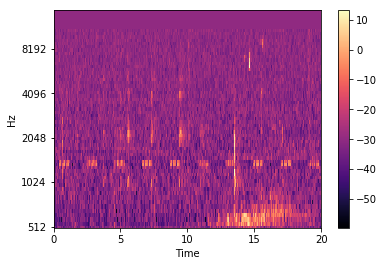

In [4]:
example_mel = melspec(example_data, example_sr)
print('Mel spectrogram shape:', example_mel.shape)
librosa.display.specshow(example_mel+example_mel.min(), y_axis='mel', x_axis='time', fmin=500, fmax=15000)
plt.colorbar()

ex (64, 862)


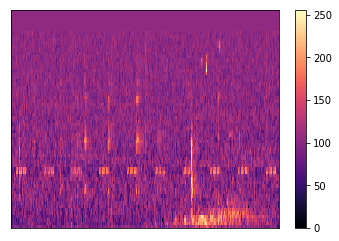

In [7]:
# Test quantiztion to 8 bit, saving to PNG
example_path = 'example.melspec.png'
skimage.io.imsave(example_path, quantize_8bit(example_mel))
example_read = skimage.io.imread(example_path)
print('ex', example_read.shape)
librosa.display.specshow(example_read)
plt.colorbar()

In [ ]:
gs = gcsfs.GCSFileSystem('mlcluster-217913', token='browser')
gs.buckets

In [9]:
def upload_image(filesystem, remote_path, spectrogram):
    ext = os.path.splitext(remote_path)[1]
    # NOTE: probably cannot open file twice on Windows filesytems
    with tempfile.NamedTemporaryFile(delete=True, prefix='bird', suffix=ext) as f:
        skimage.io.imsave(f.name, spectrogram)
        filesystem.put(f.name, remote_path)
        
upload_image(gs, 'dcase2018-bad/features/test.png', quantize_8bit(example_mel))
r = urllib.request.urlopen('https://storage.googleapis.com/dcase2018-bad/features/test.png')
assert r.status == 200, r.status

In [13]:
gs_prefix = 'dcase2018-bad/features/melspec-htk-b64-fmin500-fmax15000'
# I've seen that not all the files are a full 10 seconds
frames_length = 850

def http_exists(u):
    exists = False
    try:
        r = urllib.request.urlopen(urllib.request.Request(u, method='HEAD'), timeout=1.0)
        exists = r.code == 200
    except (urllib.request.HTTPError, urllib.request.URLError) as e:
        pass
    return exists

def feature_url(gs_prefix, folder, itemid, ext):
    path = os.path.join(gs_prefix, folder, itemid+ext)
    out_url = 'https://storage.googleapis.com/'+path
    return out_url

def upload_melspec(folder, itemid, ext='.jpg'):
    wav_url = dcase2018bird.wav_url(folder, itemid)
    path = os.path.join(gs_prefix, folder, itemid+ext)
    out_url = feature_url(gs_prefix, folder, itemid, ext)
    
    if http_exists(out_url):
        pass
        print('skip', folder+'/'+itemid)
    else:
        print('compute', folder+'/'+itemid)
        sr, data = read_audio(wav_url)
        mel = melspec(data, sr, n_mels=64)
        mel = quantize_8bit(mel)
        cropped = mel[:, 0:frames_length]
        upload_image(gs, path, cropped)
        
    return out_url

u = upload_melspec(*list(zip(dataset.folder, dataset.itemid))[10001])
r = urllib.request.urlopen(u)
assert r.status == 200

compute birdvox/4bdb31cc-6ee2-4255-a0ff-e1c763e2c6f6


In [17]:
from multiprocessing import Pool
p = Pool(5)

skip warblr10k_public/4753f59d-922f-41c7-bff2
skip warblr10k_public/722a5cae-7386-4f53-a7e2
skip warblr10k_test/6daf14ca-4514-4829-b692
skip warblr10k_public/dd897187-c975-4696-a446
skip warblr10k_public/d04d91b2-8e12-49cc-8126
skip warblr10k_public/7782b0ec-3451-43f1-9be2
skip warblr10k_public/4b5f7a79-c1d0-4d27-899f
skip warblr10k_public/506de801-48c5-4bc4-8534
skip warblr10k_test/2f13c25b-beb1-4e79-9735
skip warblr10k_public/d7af5519-3f08-4e2d-a3c3
skip warblr10k_public/fd6c497e-a56a-4f8f-a5e6
skip warblr10k_public/ac01240b-ffb0-4765-84d8
skip warblr10k_test/f26ed0d4-6ba0-40ba-99bc
skip warblr10k_public/6c499957-96e6-4e2c-a228
skip warblr10k_public/0d63b70c-bc66-4c13-a354
skip warblr10k_public/9073c574-602c-4e1a-b3af
skip warblr10k_test/322f5c09-05dd-48ab-94e7
skip warblr10k_public/3cf3aba2-72c6-4232-9194
skip warblr10k_public/7189c75c-1941-434f-92c5
skip warblr10k_public/9cdb1f5a-ec6a-4df9-9fc1
skip warblr10k_public/e07f7f88-8efa-4190-87c5
skip warblr10k_test/d20113f9-a0c6-4d86-9ae

skip warblr10k_public/60519f0f-97f4-40a3-ab97
skip warblr10k_public/f99d5ead-3653-4ad9-a9fa
skip warblr10k_public/e3d479e4-e0e2-4f27-aef8
skip warblr10k_test/d028fbd9-ec9b-4ab6-b743
skip warblr10k_public/91bf4278-b2cd-47f8-8f1c
skip warblr10k_public/503e87bc-782e-440c-b0a1
skip warblr10k_test/9e8c00a5-77e7-477e-b9e2
skip warblr10k_public/cf7f85f8-ac1d-427a-9dcf
skip warblr10k_public/1a3aaf6a-8476-4630-919b
skip warblr10k_public/d67b2b10-a14b-4867-ac7c
skip warblr10k_public/25625592-e82f-41c5-9bd3
skip warblr10k_public/a2342858-50da-4bdd-92d6
skip warblr10k_public/b90da024-bcd3-4c4c-b182
skip warblr10k_test/05a5a89d-49ad-4d3c-b41f
skip warblr10k_public/2378a8b8-68c5-4b0a-8aeb
skip warblr10k_public/f7589106-8cd3-4afd-925b
skip warblr10k_public/af7a80b5-89b6-4859-bd42
skip warblr10k_public/9d0e80af-4a3b-43aa-bfaa
skip warblr10k_public/390a0481-d556-4541-be45
skip warblr10k_public/19f04d07-3fd5-4573-9803
skip warblr10k_test/566d07a9-a11b-4745-870e
skip warblr10k_public/df9e7134-e606-48ce-8

skip warblr10k_public/2a6acce6-c129-4875-8cfe
skip warblr10k_public/d3344649-f541-4979-b227
skip warblr10k_public/61d82b4c-80a6-467c-bd48
skip warblr10k_public/92376de3-6b40-4ef0-bd74
skip warblr10k_public/ef590272-0daf-47a9-a289
skip warblr10k_test/f06d0c09-4169-412b-b47e
skip warblr10k_public/8cc6411d-9579-4d27-a9f2
skip warblr10k_public/0b856a74-0d5b-44b5-a204
skip warblr10k_public/14fe220c-fef7-46ce-8936
skip warblr10k_public/d22dcc18-e2a2-4561-9de2
skip warblr10k_public/b7aff7c6-1ccb-4402-9479
skip warblr10k_public/cc5ceca0-d4ad-4622-aca1
skip warblr10k_test/df51482d-57bd-40f1-8d3c
skip warblr10k_public/aef1e5d2-b1bc-4415-85aa
skip warblr10k_public/b6e096ec-c9e1-48ba-b877
skip warblr10k_public/f012257e-b6c5-4d6d-ad2f
skip warblr10k_public/e9b19827-19f5-4268-97d5
skip warblr10k_public/30e970a0-15ba-4838-9c6c
skip warblr10k_test/dfcfc1b3-6d61-4a2e-9a0d
skip warblr10k_public/07d74973-57c7-487d-ab26
skip warblr10k_public/7afe44db-c976-4053-979d
skip warblr10k_public/b9a24561-0bf6-4a30

skip warblr10k_public/e4cac27b-2f77-4fa0-8f92
skip warblr10k_test/a62353f0-83c9-4aad-8a83
skip warblr10k_public/989b31cf-9e40-47ec-919a
skip warblr10k_public/164a3a7c-c079-4598-be05
skip warblr10k_public/3884a395-c037-4757-ad05
skip warblr10k_public/1bb7132a-3290-4302-97e3
skip warblr10k_test/d06be67f-d733-4462-86fa
skip warblr10k_public/95e2c36a-3585-4936-9ee1
skip warblr10k_public/8d96c6d1-0efc-4031-a3da
skip warblr10k_public/7d90a797-d5bd-4580-beb0
skip warblr10k_public/2c8f496f-1582-4992-8123
skip warblr10k_test/f5022bd8-4fbb-41fc-b243
skip warblr10k_public/fcdef427-8f74-4aef-8e03
skip warblr10k_public/6ebcac68-ec10-4d74-b769
skip warblr10k_public/70c3d42f-a8d4-440a-a727
skip warblr10k_public/e40e220f-7677-4dd5-8427
skip warblr10k_public/363c1377-3522-4d17-9d1b
skip warblr10k_public/a1e70a68-ddf3-41ce-a980
skip warblr10k_test/1dbe9e18-0559-4395-9ffe
skip warblr10k_public/d0800c0e-1f53-44b1-995f
skip warblr10k_public/65ae79ce-4066-4703-8d20
skip warblr10k_public/c02a0685-c873-4242-9

skip warblr10k_public/043ebd71-6b7a-478e-ac88
skip warblr10k_test/18eadfbb-0c16-49e3-9b6c
skip warblr10k_public/80da0f30-564c-4dba-b874
skip warblr10k_public/bc797ca6-6b43-4ee1-ac00
skip warblr10k_public/4919bc7f-3da6-4deb-86c6
skip warblr10k_public/fed9acf4-882c-45ad-a328
skip warblr10k_test/7343d3a1-a3ca-4e0a-a877
skip warblr10k_public/4c7426b5-b999-4ab6-9285
skip warblr10k_public/34508a17-6bea-4d4e-8c1b
skip warblr10k_public/edcc5fcb-ec6f-4133-9c0b
skip warblr10k_public/fff64865-595b-448c-a196
skip warblr10k_test/6fc99c8b-2fa9-444a-8d3c
skip warblr10k_public/dd38e448-4bb0-462f-bc36
skip warblr10k_public/279a7928-4639-4729-9f40
skip warblr10k_public/865fb9a7-1f12-48c4-90b6
skip warblr10k_public/446df889-bea6-452b-8b19
skip warblr10k_test/07544f1c-557e-4a78-90c9
skip warblr10k_public/d5623be5-b02e-4bcb-b957
skip warblr10k_public/682c2622-f3fc-4ecc-b616
skip warblr10k_public/c9d2a28b-ac2e-4ce4-92e5
skip warblr10k_public/7f38b8d8-0212-44e5-b472
skip warblr10k_public/fe7e74c1-66ea-4ca7-9

skip warblr10k_public/2c05b734-ad54-4dc1-9fcf
skip warblr10k_public/58cbf8da-a761-44ee-aa27
skip warblr10k_public/8460624a-1955-4966-b27b
skip warblr10k_test/c2377020-9521-48c8-814a
skip warblr10k_public/c3bd76da-66de-4a61-b05d
skip warblr10k_public/06787dda-285a-4c98-93ff
skip warblr10k_public/e0a6753d-888f-400c-8b6c
skip warblr10k_test/c7816e44-7c11-41dc-8249
skip warblr10k_public/2b4e55bb-bf55-4f6f-b2a5
skip warblr10k_public/f800c2dc-792a-4af3-be13
skip warblr10k_public/02d38797-f392-4d6d-8622
skip warblr10k_test/49356760-c75f-4a2c-bdde
skip warblr10k_public/f0e1ae80-81af-4b3c-9f8e
skip warblr10k_public/960d8360-34ab-4f90-acbe
skip warblr10k_public/f66c6534-f618-411d-88ec
skip warblr10k_test/e0f84e80-2a1e-4e40-b0f8
skip warblr10k_public/ea3d430f-809e-4416-85ac
skip warblr10k_public/1930cfe0-194f-4b0c-9093
skip warblr10k_public/c52c3abd-ffa4-4576-bd1e
skip warblr10k_public/f1b9662e-bb79-4203-88e1
skip warblr10k_test/e69e7788-e450-46a4-8871
skip warblr10k_public/268bb165-521c-4200-965

skip warblr10k_public/de7f3ddb-56ce-4b5d-afa7
skip warblr10k_public/d25bbd96-3354-47c0-9142
skip warblr10k_public/6d4c9525-562e-433b-9062
skip warblr10k_public/790538e0-5af4-4277-82ff
skip warblr10k_test/d77a9f4c-d82c-4ff1-9321
skip warblr10k_public/656697ef-be60-4b05-988d
skip warblr10k_public/45f15568-cfc1-43bc-8a78
skip warblr10k_public/23ab30f2-d56a-4fe4-a13c
skip warblr10k_test/a7f262f6-5f8b-4887-9d0d
skip warblr10k_public/8ef0b045-ee40-40a6-8ffc
skip warblr10k_public/607b922c-72b1-4713-bb15
skip warblr10k_public/75840869-7acc-41a1-ac2c
skip warblr10k_public/0573a00b-efd8-45ef-93b5
skip warblr10k_test/6e9e1079-9df3-4c08-8b48
skip warblr10k_public/d9027281-7e36-45ac-9502
skip warblr10k_public/b6810019-cb45-43e7-a376
skip warblr10k_public/e1220339-6700-4d9c-9889
skip warblr10k_public/781f857e-381b-427e-b5af
skip warblr10k_test/d6cc457b-cdb7-4052-ab1a
skip warblr10k_public/7f01366b-df0b-474e-9996
skip warblr10k_public/74e6b4d9-3838-4d25-b3b6
skip warblr10k_public/7349a999-f113-420e-8

skip warblr10k_public/8572f273-c8c6-4b29-a776
skip warblr10k_public/5fa22aaa-f096-4901-a881
skip warblr10k_public/58ba353c-3d04-4f07-819a
skip warblr10k_test/0f74badf-ca6c-455d-9587
skip warblr10k_public/9602e838-fef5-496d-98ee
skip warblr10k_public/4eac3cb9-a047-4e83-9ea9
skip warblr10k_public/fc5af1a1-60f4-4e2c-905a
skip warblr10k_public/035c4530-f479-480e-889a
skip warblr10k_public/20eaf521-e88e-4e8f-947b
skip warblr10k_test/66d6f9a3-d18e-4e64-9b9d
skip warblr10k_public/7bf92514-1c92-4966-b436
skip warblr10k_public/8aadae5c-d771-41aa-b64f
skip warblr10k_public/325b1054-2dad-47ae-9cfb
skip warblr10k_public/16f8ca73-5a06-4693-af9d
skip warblr10k_public/4943c7f2-4d2d-4b9d-aff8
skip warblr10k_public/e46fc17c-c6a4-48a0-ac7b
skip warblr10k_public/cbac8d46-1e1b-4b08-87d1
skip warblr10k_test/a7a53a1a-d3ef-4ebf-ba70
skip warblr10k_public/dffd9912-62f5-4ed8-9955
skip warblr10k_public/4675dc7c-1eef-49c3-87db
skip warblr10k_public/12bbf543-541c-49fc-b26a
skip warblr10k_public/ad28837d-1e1d-43bf

skip warblr10k_public/40a84a07-2d3b-443a-9643
skip warblr10k_public/93fb9dfd-2776-44e6-8ddb
skip warblr10k_public/4b1f0408-a306-4a9f-88fc
skip warblr10k_test/08b778ba-87a3-4826-b6ab
skip warblr10k_public/666998e4-20c1-4765-bb39
skip warblr10k_public/b5dda38f-1624-4b0c-9d5a
skip warblr10k_public/8b559dd4-6b49-467a-9bc2
skip warblr10k_public/0349b135-dca1-4e45-b109
skip warblr10k_test/fd0e50b8-4c9a-4fc9-b980
skip warblr10k_public/64275a55-c5f5-49ca-a1cd
skip warblr10k_public/7ec420aa-1787-4d40-9b89
skip warblr10k_public/bf66f259-cbc7-4886-978a
skip warblr10k_public/4aed9671-dc8a-477d-b12b
skip warblr10k_test/2eeb880c-b75e-411d-8516
skip warblr10k_public/bbbe6be1-afb5-4b28-9203
skip warblr10k_public/aabaf510-320a-4c45-b16e
skip warblr10k_public/2bc65db1-0fb0-4289-b8c1
skip warblr10k_public/d04e7f5b-52ee-49d8-997b
skip warblr10k_test/375bf073-e669-46b9-b6cf
skip warblr10k_public/a28f6a31-52a2-484e-9a0c
skip warblr10k_public/1056e2b2-3683-40d0-b2af
skip warblr10k_public/cfcb0d51-e8e9-4882-a

skip warblr10k_public/d0b49b4e-f3fc-41a2-9019
skip warblr10k_test/fea652de-f9a6-4fc8-a9bd
skip warblr10k_public/e1fd170d-de21-4594-b855
skip warblr10k_public/fea82f93-24cb-4e49-86c8
skip warblr10k_public/6ce66c37-3a83-43b1-b0dd
skip warblr10k_public/19715470-9d74-4910-a687
skip warblr10k_test/e5fb039b-70b7-4cac-92cc
skip warblr10k_public/e23e83cc-a04b-4e6a-9f50
skip warblr10k_public/bd441cb5-78b7-4e8c-9cb8
skip warblr10k_public/a02ac7bc-5a29-40a1-89e1
skip warblr10k_public/7b3e2e78-65fd-4c60-aced
skip warblr10k_test/9a988702-7772-4e60-bdd6
skip warblr10k_public/a3b5b661-465e-4bda-b932
skip warblr10k_public/62c8c839-5dd2-46eb-8c9b
skip warblr10k_public/db89b696-5ca0-4ca8-982a
skip warblr10k_public/171b261e-cb89-48e8-b100
skip warblr10k_test/20478ee4-f0c9-4db3-a8a8
skip warblr10k_public/05f3f5f2-684e-485b-9f72
skip warblr10k_public/cf221532-bebc-4bbd-b887
skip warblr10k_public/6332d960-6f57-4ecc-8d1a
skip warblr10k_public/db0dc4f4-8db2-4362-8ebe
skip warblr10k_public/8ad078ea-6dc4-4894-b

skip warblr10k_public/1e8f9227-1afb-4bf8-992b
skip warblr10k_public/b5e2f904-cd8b-49fe-8777
skip warblr10k_public/9372ed5e-0e36-410e-983d
skip warblr10k_public/8f346c32-dd36-4b44-b416
skip ff1010bird/37797
skip warblr10k_test/1eb6a780-2179-47a0-ba75
skip warblr10k_public/30d4e71d-4bdc-4ed3-bbe7
skip warblr10k_public/8b1c7003-723d-40b0-b5d2
skip warblr10k_public/970f3a45-2eaa-46d0-ae0d
skip ff1010bird/167206
skip warblr10k_test/ca7aae7c-1537-4b81-8e70
skip warblr10k_public/611a0289-c394-4fcd-ac04
skip warblr10k_public/7ac6a15e-31a2-454f-8521
skip ff1010bird/56167
skip warblr10k_public/63c7fb71-0134-4460-94d1
skip warblr10k_public/3ad0f266-412c-4265-bcf7
skip warblr10k_public/c25b99cc-8137-4100-900e
skip warblr10k_test/886537e0-8a42-4691-956a
skip ff1010bird/76275
skip warblr10k_public/9721d899-7e24-4175-a736
skip warblr10k_public/93c41153-093f-4af8-af00
skip warblr10k_public/31ea6623-5604-48d2-9a02
skip warblr10k_test/8a05496d-495d-41de-8a06
skip ff1010bird/31747
skip warblr10k_test/a4f

skip warblr10k_public/c14d1b79-a976-43d7-950b
skip warblr10k_test/680888df-d49b-41aa-9d4f
skip warblr10k_public/16a81c4b-86f6-48a5-940b
skip ff1010bird/146853
skip warblr10k_public/b5090346-7581-4917-9c6a
skip warblr10k_public/e0474721-fc1a-403e-9183
skip ff1010bird/164192
skip warblr10k_public/e3f7fdca-4ff9-478d-b162
skip warblr10k_public/87e2e422-01b8-4be1-b683
skip warblr10k_public/80a7921f-5a3f-4c33-9e59
skip warblr10k_test/ce602708-748a-4f38-8a92
skip ff1010bird/126832
skip warblr10k_public/c715ac4c-2a71-485b-b031
skip warblr10k_public/4bd2e59e-993f-4453-93f9
skip warblr10k_public/90f145db-f340-4943-94d0
skip warblr10k_test/fd4513ff-6e74-4e1c-9430
skip ff1010bird/127671
skip warblr10k_public/3f5a7fce-6a91-4b50-86a9
skip warblr10k_public/de301d8c-e3ab-4a2c-a3e3
skip warblr10k_public/34f7f9d6-e9e2-43fc-926f
skip warblr10k_test/a2281907-6fad-4e27-84bf
skip ff1010bird/80707
skip warblr10k_public/9e14f39e-a8cd-468a-9e8a
skip warblr10k_public/7fad17be-0c53-40bf-9ddd
skip warblr10k_publi

skip ff1010bird/146196
skip warblr10k_public/468ab4f9-91eb-4177-8712
skip warblr10k_test/7a0db54a-3f10-41e7-a11b
skip warblr10k_public/cb7f1d61-738d-45c6-9f5e
skip ff1010bird/65246
skip warblr10k_public/ca682e73-0e85-4220-9b0b
skip warblr10k_public/38066ee5-3535-4ff5-b777
skip warblr10k_test/9301713f-46a8-4206-aef9
skip ff1010bird/73369
skip warblr10k_public/c82cf017-6ba9-42f3-a19f
skip warblr10k_public/16f678f3-7528-4ee1-bd5e
skip warblr10k_public/f6cd45a0-ebe2-4c7e-93e0
skip warblr10k_test/fe2c7185-3ae9-4e44-837f
skip warblr10k_public/b468f04d-342e-4e92-8a62
skip ff1010bird/55092
skip warblr10k_public/72d505af-8afb-4413-9762
skip warblr10k_public/a46e8d2b-eafc-4c4f-a738
skip warblr10k_test/5882fce6-4eaa-497e-8c14
skip warblr10k_public/011a75e4-f82c-4ec5-8532
skip warblr10k_public/1d1e2515-24a4-4ed9-abd6
skip ff1010bird/171750
skip warblr10k_public/1a6a414e-edda-49f9-aad0
skip warblr10k_test/a79f0ccf-dd7b-4426-a928
skip warblr10k_public/3ece4551-991d-4bd8-8f6c
skip ff1010bird/106491
s

skip warblr10k_public/ab902613-8f2f-4bb5-8611
skip ff1010bird/95026
skip warblr10k_public/49f47063-5d43-44e6-ad20
skip warblr10k_test/424e1d10-b061-467f-bac2
skip warblr10k_public/5d5fe074-4b88-45dc-8e56
skip warblr10k_public/371a1c34-4de8-448b-8093
skip warblr10k_test/6dd0a651-aa1b-4bd5-bedd
skip ff1010bird/30373
skip warblr10k_public/af6f0a85-4994-42d3-80a3
skip warblr10k_public/86c220b7-a537-4b10-b110
skip warblr10k_public/e5f2eca5-7299-4cd5-8c6e
skip ff1010bird/16783
skip warblr10k_public/9c469e79-77c3-4e8f-901d
skip warblr10k_public/237385a6-220d-4374-9b6a
skip warblr10k_public/114cd9c0-9d5a-4a00-ba37
skip warblr10k_test/492e3c51-bc56-402e-99b6
skip ff1010bird/161888
skip warblr10k_public/9c2dfaa2-095b-4aee-902e
skip warblr10k_public/b34152ee-797a-4f42-a919
skip ff1010bird/74215
skip warblr10k_public/135bfe5b-5349-4187-9b63
skip warblr10k_test/e6e8429f-db43-4010-980a
skip warblr10k_public/432b4cc9-1af9-440b-93ed
skip ff1010bird/124694
skip warblr10k_test/5f9ca8fd-57e3-4903-b55d
sk

skip warblr10k_test/4739a5c2-2b9c-4bca-9981
skip ff1010bird/72270
skip warblr10k_public/7702a2f0-957a-4c42-9a6b
skip warblr10k_public/9e8c9a53-aeea-4330-b201
skip warblr10k_public/c3801365-1827-4b82-a3ef
skip warblr10k_test/2f0f9b3d-a657-4c7b-a969
skip ff1010bird/16834
skip warblr10k_public/0e06915c-bad0-4089-a8e8
skip warblr10k_public/c102ae0d-09a9-44df-b397
skip warblr10k_public/de369564-5d81-4c20-8b49
skip warblr10k_test/67d20551-0475-400d-a2e0
skip ff1010bird/19782
skip warblr10k_public/129d1af1-bf2e-465b-8fba
skip warblr10k_public/bef4202e-31e2-4b6e-b577
skip warblr10k_test/d435a20e-b4ec-47fc-9827
skip ff1010bird/9134
skip warblr10k_public/55d8b226-3c8e-4430-8105
skip warblr10k_public/f6ec11df-81f9-41d2-b1b2
skip warblr10k_public/ec52621c-13f7-4485-afe4
skip warblr10k_test/8553781d-bed3-46f7-9db7
skip ff1010bird/66019
skip warblr10k_public/7ae348d5-c893-4591-aff2
skip warblr10k_public/0a160dd5-9c7e-4e2f-8bd7
skip warblr10k_public/e97f5c98-3911-4883-8a39
skip ff1010bird/156448
skip

skip warblr10k_public/b0956dff-bf3b-4e58-8b4f
skip ff1010bird/62313
skip warblr10k_test/9cd76ff0-133c-4d87-99fa
skip warblr10k_public/7ff0510d-8d2a-46d5-98fe
skip warblr10k_public/1006d6c7-7d31-415f-8059
skip ff1010bird/63758
skip warblr10k_public/350b41f9-c3cb-4e26-be55
skip warblr10k_test/8654dcfb-dd70-49e1-98c6
skip warblr10k_public/fd3dd16a-6d45-41ff-9302
skip warblr10k_public/16a22c47-8c9c-4100-bf0b
skip warblr10k_test/dc0512e6-ca45-4b4b-b8a6
skip ff1010bird/114622
skip warblr10k_public/44576cdd-7b0a-432b-ba2d
skip warblr10k_public/c0a1f30c-f274-445d-99b1
skip warblr10k_public/d0b669f8-199b-4b88-a686
skip warblr10k_test/62e63edd-c417-4469-b496
skip warblr10k_public/7f911c10-f6a7-43b7-ad21
skip ff1010bird/167357
skip warblr10k_public/b0861bae-7eeb-4bc6-885a
skip warblr10k_test/86335190-ae3b-448c-b4d5
skip warblr10k_public/e5f4e6eb-1929-4494-a1b8
skip warblr10k_public/dda2da09-2fca-4874-a9bb
skip ff1010bird/30476
skip warblr10k_public/5d023497-a43e-4d3f-bd7a
skip warblr10k_test/4bf5

skip warblr10k_public/142e194b-7b95-4733-93b9
skip warblr10k_public/0dc70bfd-3633-4d35-ab74
skip warblr10k_public/a8f85083-e489-48c5-9542
skip warblr10k_test/c45cb2a2-2f9e-4de8-ba6b
skip warblr10k_public/51a19fb5-08c9-409f-b03b
skip ff1010bird/80287
skip warblr10k_public/ce4c34ee-1931-453e-81ff
skip warblr10k_public/185af2a6-d66c-4048-aa19
skip warblr10k_test/fef44044-1a00-417c-a323
skip ff1010bird/153501
skip warblr10k_public/287e02ba-5a05-47f2-b556
skip warblr10k_public/11afad8a-0eb3-483b-881e
skip warblr10k_test/1aa3e656-2949-4577-a32e
skip warblr10k_public/e1cbc06a-0bb3-4ff0-95df
skip warblr10k_public/f55cf69a-3e1a-461f-9de1
skip ff1010bird/188246
skip warblr10k_public/752da6f6-40d4-4b00-a6f7
skip warblr10k_test/718d6dd4-8ce1-48cf-b573
skip warblr10k_public/14e31f91-ab65-4e99-b7f6
skip warblr10k_public/8fd9294c-25a8-4858-9858
skip ff1010bird/164379
skip warblr10k_public/e63ffaeb-9611-4c6f-8282
skip warblr10k_test/b69b6271-8d53-4b33-a41f
skip warblr10k_public/dc77135a-ca5f-43f1-800f

skip ff1010bird/73751
skip warblr10k_public/b484857c-3dab-48b2-b6c2
skip warblr10k_public/8c0c2877-d942-4689-8261
skip warblr10k_test/463355da-4ee1-4d2b-9479
skip warblr10k_public/a5a19e49-c3d7-4885-9f57
skip warblr10k_public/f8458f02-0654-47da-8e38
skip ff1010bird/57069
skip warblr10k_public/8ff87728-5f03-4c5c-8d44
skip warblr10k_public/0edc9c3c-7b69-4a5c-91b5
skip warblr10k_public/be1d5f97-96f3-408c-a854
skip warblr10k_test/ef055d94-70b5-4427-8b88
skip ff1010bird/111031
skip warblr10k_public/2f39633c-faca-4221-8422
skip warblr10k_public/1baf099e-8eb5-4748-925c
skip warblr10k_public/495c6e14-28bf-4eba-8887
skip warblr10k_public/f91682f2-be38-4ab3-a157
skip ff1010bird/141165
skip warblr10k_test/a3d65c2e-e957-4fe6-9bae
skip warblr10k_public/c17fe23d-6821-49a9-abc9
skip warblr10k_public/2c5c229e-2fb3-4005-b47d
skip ff1010bird/137153
skip warblr10k_public/df171452-6d72-40d8-bd3d
skip warblr10k_test/050b5ed2-3b10-4f23-b725
skip warblr10k_public/5af9bd96-453e-49aa-8b7f
skip warblr10k_public

skip warblr10k_public/e694bd9d-e71d-412f-a071
skip warblr10k_test/b06322cb-641c-4dfd-979d
skip warblr10k_public/ca0d90bc-bb9a-40dc-bd31
skip ff1010bird/20695
skip warblr10k_public/d7917465-7386-406b-95c4
skip warblr10k_public/e43cc757-cbb4-44a1-85bf
skip ff1010bird/59449
skip warblr10k_public/e153ed96-addc-42cf-81b0
skip warblr10k_test/f9ebae2a-0dd2-4a8f-948e
skip warblr10k_public/75d2cc74-7e71-4f0f-bf97
skip warblr10k_public/095f2167-fbe7-409f-9e22
skip warblr10k_test/d9e12501-21b6-4a8f-8215
skip warblr10k_public/60c77255-4844-41b3-ab8e
skip warblr10k_public/6b00477f-77b7-494d-9306
skip ff1010bird/86769
skip warblr10k_public/55a76043-e119-4b17-b3ef
skip warblr10k_test/f1a94677-f3ad-421f-8c44
skip warblr10k_public/1a9322d0-1fac-488b-a264
skip warblr10k_public/947156b4-9992-4247-acf2
skip warblr10k_public/3b29f6e0-9971-4dde-8b33
skip ff1010bird/98737
skip warblr10k_public/8ebb8b3f-a669-42c2-9b43
skip warblr10k_test/7dfdfa60-23dd-4767-ae66
skip warblr10k_public/cb61263b-b5af-466f-8c46
sk

skip warblr10k_test/62d6d1c3-9672-4926-ba4f
skip ff1010bird/166717
skip warblr10k_public/5a72b175-63e3-4054-815a
skip warblr10k_public/d5f2d270-4ed3-4f4f-9f72
skip warblr10k_public/1f938a0a-8d45-4e49-9ebb
skip warblr10k_test/f5630148-1e62-46ef-a0dc
skip warblr10k_public/005fe9f3-438a-41e5-9322
skip warblr10k_public/ff5989ea-d21b-4ba8-a4c1
skip ff1010bird/57272
skip warblr10k_public/afe73e12-0a7d-4e95-bbff
skip warblr10k_test/3cfce2b5-40c2-4942-8590
skip warblr10k_public/b8df4e85-fb8c-4f5c-b173
skip ff1010bird/175142
skip warblr10k_public/0f3a6873-c832-4785-bdae
skip warblr10k_public/f674a7b9-13ab-42a7-8946
skip warblr10k_test/363f28a7-4673-43a2-8ed2
skip ff1010bird/72758
skip warblr10k_public/697a6c2f-f8ff-4e1e-84e1
skip warblr10k_public/befce91e-058d-4764-8a78
skip warblr10k_public/c73a49c6-cc19-43fc-8c5d
skip warblr10k_test/225458ad-6ccc-4829-ad90
skip ff1010bird/180024
skip warblr10k_public/8dc2c7d5-7178-4ffa-a6e9
skip warblr10k_public/e5952a89-3fd2-4c8d-ac06
skip warblr10k_test/b0b

skip ff1010bird/127720
skip warblr10k_public/806ca787-3c95-4c8b-af36
skip warblr10k_public/327993ca-982c-4319-a68c
skip warblr10k_public/f547755d-0f24-4bde-afb6
skip warblr10k_test/3f6e8262-bc90-4559-9570
skip ff1010bird/77780
skip warblr10k_public/81797d2c-eefd-4592-b986
skip warblr10k_test/8f8b5d50-5c39-49b6-8b03
skip warblr10k_public/e6260a99-2b80-4461-abda
skip warblr10k_public/99f9066e-8d38-4766-8af8
skip ff1010bird/105288
skip warblr10k_public/19be6b3a-d3ea-4a1b-bae7
skip warblr10k_test/507e1379-45cb-4982-ab15
skip warblr10k_public/2ce42a8b-7311-42ee-8320
skip warblr10k_public/1dda31c7-bb19-45b3-ada3
skip ff1010bird/157910
skip warblr10k_test/a1b22aaf-818f-4ab7-aa77
skip warblr10k_public/38855525-c20a-45a2-b675
skip warblr10k_public/2dcf5ee0-605c-4bdf-9794
skip warblr10k_public/21f1a25e-ec4b-445c-bea1
skip ff1010bird/16771
skip warblr10k_test/6deeab1f-1992-4b3d-ad2e
skip warblr10k_public/dc82052f-1b83-463d-b6b6
skip warblr10k_public/f342212e-6ff4-4cd1-96b2
skip warblr10k_public/7

skip warblr10k_public/d830fc29-911b-4a6e-a09c
skip warblr10k_test/f7c62a74-d20c-4386-b445
skip ff1010bird/172773
skip warblr10k_public/7dfaa6f2-80b2-45cf-8406
skip warblr10k_public/efeb1574-f9c8-4068-a95d
skip warblr10k_public/f3a616da-f25e-41f7-9d34
skip warblr10k_test/f326bb8f-d3f8-4f51-9500
skip ff1010bird/147950
skip warblr10k_public/c984f52a-dcd3-44aa-ad0c
skip warblr10k_test/175c342e-a497-4905-a7b7
skip warblr10k_public/a8aa8d89-0606-47c0-a6a6
skip warblr10k_public/fc643bad-c7bf-427b-a494
skip warblr10k_public/f0d0f7f4-f5e9-4ce9-a1c9
skip ff1010bird/39977
skip warblr10k_public/d85f77d6-5a87-4db8-bba7
skip warblr10k_test/e05946e1-abb8-4474-970c
skip warblr10k_public/b9de644e-3145-4904-bd6f
skip ff1010bird/75273
skip warblr10k_public/9d275d43-9001-4258-a7d5
skip warblr10k_public/18c6f25c-0c8d-479a-9f94
skip warblr10k_public/5de2dbe1-ec53-4c50-a0d2
skip warblr10k_test/3930e1c9-ab91-4183-8a1f
skip ff1010bird/155231
skip warblr10k_public/767b26dd-5ed6-4821-8122
skip warblr10k_public/6

skip ff1010bird/128093
skip warblr10k_public/71ffdb75-6ea0-4d30-a767
skip warblr10k_public/923eb21b-3bf4-45c8-a8e3
skip warblr10k_test/9db69597-5fc4-46c0-9b27
skip ff1010bird/192261
skip warblr10k_public/6152b0ee-6cef-4ef7-9038
skip warblr10k_public/4452a539-9b0e-4f6b-9f8f
skip warblr10k_public/e54e9787-b03a-4d27-be96
skip warblr10k_test/00016765-bad0-4e2c-ad4e
skip warblr10k_public/778df7c9-04a4-45c9-a407
skip ff1010bird/158439
skip warblr10k_public/07f78e3e-bec3-4cd5-8a50
skip warblr10k_test/52c62157-a43b-4bfa-8a97
skip warblr10k_public/b41fda4c-4974-4450-8fb2
skip ff1010bird/103375
skip warblr10k_public/40676aa6-f07d-4231-b84f
skip warblr10k_public/eb8ab881-d5d9-4adf-ab2c
skip warblr10k_test/4f697919-dfaa-46a6-bca5
skip warblr10k_public/332e4dc6-f57d-410c-a140
skip warblr10k_public/bfd5dc30-cc75-45d8-b3f7
skip warblr10k_public/ac79c536-b42d-4c89-b6b3
skip ff1010bird/127737
skip warblr10k_test/40b92fa1-1643-4b6b-9f5d
skip warblr10k_public/95776f54-4c8c-43af-aace
skip warblr10k_public

skip warblr10k_public/f1419e29-094b-45b3-ae88
skip warblr10k_test/44e427d8-2ac1-4230-b3a7
skip warblr10k_public/9c1d6ffa-b601-443d-bfda
skip warblr10k_public/e60b24cd-21b7-487d-84e9
skip ff1010bird/160469
skip warblr10k_public/c5274fc3-f903-46fa-a40a
skip warblr10k_test/a5cd7c36-6475-4df9-b334
skip warblr10k_public/1e069b5a-047e-4ad6-b07a
skip warblr10k_public/ea4ff5a4-4bb7-43c5-b696
skip warblr10k_test/c58ccd4e-b565-4f2c-b536
skip ff1010bird/55856
skip warblr10k_public/e0f6d8d5-75cb-415b-8c29
skip warblr10k_public/92dd4189-f3b4-467a-82a2
skip ff1010bird/169093
skip warblr10k_public/279095b2-05b8-4028-9990
skip warblr10k_test/9faea2a7-19c0-42ae-b0c0
skip warblr10k_public/f056738d-1445-46b0-a3cb
skip warblr10k_public/37182b9b-8617-48c4-bee4
skip warblr10k_public/a14dc8f4-d116-48fd-86f0
skip ff1010bird/20384
skip warblr10k_test/92fba5a1-0e49-4b5a-863c
skip warblr10k_public/f9869c27-ff1b-4b07-99cf
skip warblr10k_public/b4743ee7-6b5c-431b-8b4a
skip warblr10k_public/2157f951-2c86-4b61-ac0a


skip warblr10k_test/c31f26cc-1a2f-4af6-b3a8
skip ff1010bird/89947
skip warblr10k_public/0c24931a-48e0-4a68-9a34
skip warblr10k_public/4e41885d-f88e-4684-a099
skip ff1010bird/167105
skip warblr10k_public/0308e50f-098d-4b05-b2e0
skip warblr10k_test/f88a9311-eb36-42dd-afdc
skip warblr10k_public/974307bc-3413-40f1-a043
skip warblr10k_public/8ce9f67e-a0b1-412c-90c1
skip ff1010bird/143292
skip warblr10k_public/49c5cd07-ecc4-4f04-abc9
skip warblr10k_test/88887e20-fb9f-40f7-ada1
skip warblr10k_public/97bf01cd-8f2a-47a0-b4ac
skip warblr10k_public/f67cf698-01f6-4513-aaf0
skip warblr10k_public/a7fe909a-a71d-4eee-8f7c
skip warblr10k_public/31caed8d-29ee-4efa-afc8
skip ff1010bird/79086
skip warblr10k_test/4de6a0cd-bf42-44f1-9ee9
skip warblr10k_public/78d1029b-d18d-439a-a5ad
skip warblr10k_public/679a96ff-3844-41ce-b44f
skip warblr10k_public/9911447f-168c-4ca6-9781
skip ff1010bird/66600
skip warblr10k_public/2069d52b-0f8e-4666-a25b
skip warblr10k_public/2cb57b53-a94c-43c3-b81a
skip warblr10k_test/06

skip warblr10k_test/7e2a7d17-908e-40f2-a95c
skip warblr10k_public/d5e28a06-c52b-4d52-bbd7
skip warblr10k_public/0a8957e6-2647-4cec-ae72
skip warblr10k_public/7c26e6b2-a99d-4f57-a572
skip ff1010bird/45990
skip warblr10k_test/1dff64e2-cd6c-44dd-bac1
skip warblr10k_public/23c84601-1966-49f5-b8f8
skip warblr10k_public/088b2195-6699-4da6-b195
skip warblr10k_public/d3aabaaf-2394-499b-b580
skip ff1010bird/168906
skip warblr10k_test/8d54b487-9661-40ab-8ba5
skip warblr10k_public/fd05e495-e5dd-43b1-bf3d
skip warblr10k_public/5c65d831-0a26-41ea-a38e
skip ff1010bird/189848
skip warblr10k_public/62402b51-3f59-4116-9b5d
skip warblr10k_test/c1099b70-866f-415b-8544
skip warblr10k_public/3e6a59c0-be72-4f95-9a1f
skip warblr10k_public/093d2679-eb84-44b5-bc1e
skip warblr10k_public/cdf72734-715d-4366-87b5
skip warblr10k_test/da154923-36cc-48b7-8a62
skip ff1010bird/159169
skip warblr10k_public/64851676-30d5-4646-ad41
skip warblr10k_test/9b050a74-322d-4076-8d06
skip warblr10k_public/081b6d8e-6a0f-4539-a944
s

skip ff1010bird/44279
skip warblr10k_public/23d96aed-b4f4-4970-9ae6
skip warblr10k_public/02b99018-a4ec-4e22-a2b3
skip warblr10k_test/a57e19d5-645d-4d55-9624
skip ff1010bird/116222
skip warblr10k_public/4b9e7d08-b8a3-48b1-a561
skip warblr10k_public/db851a23-63d5-43b1-a478
skip warblr10k_test/83dfb565-586a-4b08-bd3b
skip warblr10k_public/a25417b4-c263-4a5e-9fe9
skip ff1010bird/95819
skip warblr10k_public/2a668c73-8cf2-4777-8b01
skip warblr10k_public/a0037c6d-6a7f-47c1-bfbf
skip warblr10k_public/ef7eb546-a570-49f7-af8e
skip warblr10k_test/900d8497-421d-4270-a0d6
skip ff1010bird/134984
skip warblr10k_public/7d37a0ac-3b96-407f-8dac
skip warblr10k_public/822a9fe8-7f82-47c7-a763
skip warblr10k_public/92633400-0c71-465d-be6a
skip warblr10k_test/988f937e-514e-440a-a695
skip ff1010bird/39011
skip warblr10k_public/7e382afc-ef1b-4cbe-85cb
skip warblr10k_public/963d9691-1e65-40ed-84c6
skip warblr10k_public/db6c4c5e-8b58-43a4-ad53
skip warblr10k_test/20063cd9-df9d-4226-ac79
skip ff1010bird/93664
sk

skip warblr10k_test/e352b2c9-4c8f-4e74-b859
skip warblr10k_public/36c60153-06eb-4ec3-be88
skip warblr10k_public/bad7b118-4f11-47a2-a9ec
skip warblr10k_public/8d80f68a-8aa5-467a-a616
skip warblr10k_public/4eeb35f1-2c1d-4784-8f54
skip warblr10k_test/4f5c347c-75ab-4574-b6ec
skip warblr10k_public/203c573c-91b2-4010-b150
skip warblr10k_public/02be4bb5-068e-498c-9cdb
skip warblr10k_test/47e7e667-7e78-4ce4-8ce3
skip warblr10k_public/4d6397f0-0750-438c-9fe1
skip warblr10k_public/7b92c932-85e2-4865-890d
skip warblr10k_test/5525a44e-0be6-43d8-90f3
skip warblr10k_public/d894f5d9-2459-430b-8e6d
skip warblr10k_public/6aa2d378-bf74-41a1-8856
skip warblr10k_public/4e44c4b3-6138-4f0e-b58b
skip warblr10k_public/041f9eaa-849a-4556-ba38
skip warblr10k_test/62302ea8-87be-4d8c-8861
skip warblr10k_public/c1f4cb15-1712-42fa-8424
skip warblr10k_public/17a3c0d5-cd44-4e5c-8161
skip warblr10k_test/95dfadac-c82e-4b7d-8e2e
skip warblr10k_public/9119c35d-a92c-433e-b9a8
skip warblr10k_public/e90130b3-7d10-4985-80a7


skip warblr10k_public/c5f07e33-e1b0-4217-ad5f
skip warblr10k_test/6bce7896-5acc-4991-b729
skip ff1010bird/139093
skip warblr10k_public/a8df66ae-6306-4591-88f0
skip warblr10k_public/e0038fd7-a1de-46d2-bf50
skip warblr10k_public/92024a8b-5b7e-40ba-8a8c
skip ff1010bird/96967
skip warblr10k_test/8219d944-5035-4c93-8561
skip warblr10k_public/e6878c86-4dbb-4020-936a
skip warblr10k_public/61b04068-178f-43a9-9281
skip warblr10k_public/01cf9018-c805-4848-add5
skip warblr10k_test/25191ef3-be9d-4f46-93b9
skip ff1010bird/23537
skip warblr10k_public/4d4bedbe-b673-44c0-8d50
skip warblr10k_public/68b035bf-3e49-42a2-b76e
skip warblr10k_public/1c27179b-3783-449b-ac18
skip warblr10k_test/f2694103-40d7-4a45-b6fa
skip ff1010bird/44329
skip warblr10k_public/f621dfd4-10bc-42b9-b757
skip warblr10k_public/b7a8fac6-2632-463d-9763
skip warblr10k_public/d01dfbf6-0867-4a08-a277
skip warblr10k_test/fb9e3a7f-a0c5-41d8-a6be
skip ff1010bird/3093
skip warblr10k_public/3703fce8-8583-419e-ac61
skip warblr10k_public/32b1

skip warblr10k_test/ae269346-1492-48b5-a9fa
skip warblr10k_public/0e1cde43-2287-4df5-a968
skip ff1010bird/79608
skip warblr10k_public/5b76d798-9f93-471d-9f2d
skip warblr10k_public/4caeff61-8d66-474e-aa49
skip warblr10k_test/0c1d9067-f09e-4d3f-81a9
skip warblr10k_public/a1769159-d3a5-47a4-ab2b
skip warblr10k_public/f0acd973-3e41-4309-9679
skip warblr10k_public/be503851-72f2-47b7-ba69
skip ff1010bird/137154
skip warblr10k_public/6a0ba4a9-64a9-48b4-b6ce
skip warblr10k_test/3adf8335-f4fe-4eb8-ba93
skip warblr10k_public/b1bcb928-cc1b-45bc-bcdd
skip ff1010bird/173902
skip warblr10k_public/541d512e-93fc-4497-bb2f
skip warblr10k_test/041515c1-b92a-4421-ad6f
skip warblr10k_public/64ea23d9-e752-4eb5-8c8f
skip ff1010bird/126845
skip warblr10k_public/78f5a9c0-dfe7-4436-81f8
skip warblr10k_public/e3c16151-7ccc-49c6-a445
skip warblr10k_public/19603f9d-fd90-418e-8cfa
skip warblr10k_test/60801220-5f39-4bf5-8866
skip ff1010bird/33639
skip warblr10k_public/28590add-a8c0-4e26-8720
skip warblr10k_test/ca7

skip warblr10k_public/91b5fba7-3785-4ee4-b62d
skip warblr10k_public/5a9b3995-519d-4c0f-b173
skip ff1010bird/92891
skip warblr10k_test/fe6471d0-066b-472e-aa59
skip warblr10k_public/97a0edab-1028-48ec-986d
skip warblr10k_public/e2c1b9e7-6465-4d81-ab07
skip warblr10k_test/ba7ff9b0-c0c8-4741-86b2
skip warblr10k_public/97af43f8-c536-4f2e-a3d2
skip ff1010bird/130089
skip warblr10k_public/63fef1d4-0933-4826-9a20
skip warblr10k_test/2653724e-959a-4040-b815
skip warblr10k_public/4ac7a12c-7198-4db5-b823
skip ff1010bird/101317
skip warblr10k_public/b5856e38-d656-4fc5-9959
skip warblr10k_public/d3d6852b-3d64-49ff-a123
skip warblr10k_test/b1df9994-04e7-45a1-bc09
skip ff1010bird/144152
skip warblr10k_public/eaff1748-bf12-44dd-b4f3
skip warblr10k_public/ff39b229-27cf-456f-b15a
skip warblr10k_public/4273ea45-5f6a-477b-8114
skip warblr10k_test/6d737d86-0251-4aed-b4da
skip warblr10k_public/4fe276f4-32f9-4175-8b13
skip ff1010bird/78559
skip warblr10k_public/dd18f162-2ca8-46fc-8563
skip warblr10k_public/3

skip warblr10k_public/a815cdda-3d19-4afa-a848
skip warblr10k_public/33a5ad54-077a-478b-b670
skip ff1010bird/17144
skip warblr10k_public/83d4c8d6-a330-48ee-8b51
skip warblr10k_test/18b9c6ed-b6d6-4c24-9070
skip warblr10k_public/f5e3a3c9-24a9-4bef-b57f
skip ff1010bird/73752
skip warblr10k_public/84597a34-c70b-4a6f-b4f2
skip warblr10k_public/07a39a63-19ee-4ab9-b787
skip warblr10k_test/7080f177-367e-4fcc-a28f
skip warblr10k_public/3df6a278-5ade-4077-8744
skip ff1010bird/107605
skip warblr10k_public/9bd42c81-d785-4e41-ae94
skip warblr10k_public/04316c95-edd8-4814-b07a
skip warblr10k_test/f06b1ab7-2549-42d3-8555
skip warblr10k_public/9a110298-4d11-4f49-bae0
skip ff1010bird/134979
skip warblr10k_public/05e89f91-d72d-4506-83d5
skip warblr10k_public/7ac76340-0e6d-48f1-adb9
skip warblr10k_test/3ea15d2a-3a23-402a-a9ef
skip warblr10k_public/c72f6909-dbb8-4dcc-a895
skip ff1010bird/59509
skip warblr10k_public/7b048fc2-32e6-41d4-a7bc
skip warblr10k_test/2fe7a842-3783-4333-8a0d
skip warblr10k_public/90

skip ff1010bird/111081
skip warblr10k_public/75d9fd33-716d-4631-bf2b
skip warblr10k_public/3bb93342-bf4a-4843-aa4a
skip warblr10k_test/9b95af90-c67f-4303-bdd5
skip warblr10k_public/a86a3b33-295f-4117-b5b5
skip warblr10k_public/a8bc1241-894b-4e42-b403
skip ff1010bird/162563
skip warblr10k_public/bad463ba-a00a-4a81-9a4c
skip warblr10k_test/b8d0afb8-f977-4749-b2b3
skip warblr10k_public/c706b721-43d3-46a6-9d74
skip warblr10k_public/b4f9f37d-ee4f-475f-b51c
skip ff1010bird/51729
skip warblr10k_public/7fbf3ff3-80b2-4d1c-ae1d
skip warblr10k_public/d217bfb2-3dd1-4184-9065
skip warblr10k_public/32ab1189-9893-4792-bb00
skip warblr10k_test/6d5c0b48-edc6-451c-a00c
skip warblr10k_public/8ab65344-a2b0-4c12-b5c5
skip ff1010bird/38365
skip warblr10k_test/5f1c3f49-8577-498a-81fa
skip warblr10k_public/e06ae878-7403-47bf-ba5e
skip warblr10k_public/ac7cf2bf-20c9-4748-b331
skip ff1010bird/121956
skip warblr10k_public/4827d25e-e974-47cd-bf15
skip warblr10k_test/659805a2-4221-4103-b74a
skip warblr10k_public/2

skip warblr10k_public/f823b3f5-6c36-4648-8cdd
skip warblr10k_public/6a7c52ab-3c5c-4530-969a
skip warblr10k_public/10488aa0-4242-4a8b-87a4
skip ff1010bird/86746
skip warblr10k_public/72ccb834-575c-4b87-b197
skip warblr10k_public/b4f88af7-fb7f-4b9c-b13d
skip warblr10k_public/0a69a7ce-5aeb-4627-9266
skip warblr10k_test/4346dbc8-13bb-4152-b907
skip ff1010bird/95029
skip warblr10k_public/dedf6a14-c2c9-4459-8bd4
skip warblr10k_public/daf028d0-40b7-4ee6-a17f
skip warblr10k_test/53628689-81b5-4c45-aafa
skip ff1010bird/137836
skip warblr10k_public/d2b41380-5cef-4a36-8860
skip warblr10k_public/ce657fc3-2b87-44f2-a1f2
skip ff1010bird/168894
skip warblr10k_test/5169ef7a-1499-49a2-af48
skip warblr10k_public/1962f468-f698-4281-ad46
skip warblr10k_public/f76f483a-3e5a-430a-bcb9
skip warblr10k_public/4aef62ee-f2bb-417a-9f89
skip warblr10k_public/f1a0251d-407c-4a41-940d
skip warblr10k_test/2e113b78-ab08-4184-a431
skip warblr10k_public/9287c9e4-3a5c-4711-a772
skip ff1010bird/146843
skip warblr10k_public

skip warblr10k_public/30499ec4-5a68-4e9e-851c
skip ff1010bird/53431
skip warblr10k_public/b82dfc99-d53b-4066-a5fe
skip warblr10k_public/a6b9a02a-baca-43b1-bdc9
skip warblr10k_test/c19e0850-b82e-439c-af21
skip warblr10k_public/a0ee4df2-d3b5-45b1-924c
skip ff1010bird/85227
skip warblr10k_public/41c7c686-f2e3-4b74-a853
skip warblr10k_public/d8b254ab-a15e-4c21-bb5c
skip warblr10k_public/940ea52b-84c8-4465-b482
skip warblr10k_test/1d93143e-d71d-4e6f-b358
skip ff1010bird/54806
skip warblr10k_public/91e2e266-bd12-4a30-96cd
skip warblr10k_public/eb44f200-8f14-4634-903e
skip warblr10k_test/cdb390cd-a16e-4a33-bbd6
skip warblr10k_public/c4fd6b2d-45df-4aad-aa1a
skip ff1010bird/26911
skip warblr10k_public/7ac32fbe-0647-4611-aced
skip warblr10k_public/60dd82db-792b-4c99-a9be
skip warblr10k_test/8fea3421-696a-4603-b1e5
skip warblr10k_public/9a844074-86f7-406a-96fb
skip warblr10k_public/8cc1f85d-e77a-4cba-a1a4
skip ff1010bird/126824
skip warblr10k_public/773b2f6d-49ea-4592-bf5b
skip warblr10k_test/7d3

skip warblr10k_public/79f3c75b-2119-4caf-9976
skip warblr10k_test/77ed0a44-4624-4e6e-b6c8
skip warblr10k_test/e506a0cf-2083-49ec-803e
skip warblr10k_public/f5384bf5-9766-42c9-bf29
skip warblr10k_public/44b1c3a2-cc9e-4b62-a155
skip warblr10k_test/d48fca0a-0072-4966-b7f0
skip warblr10k_public/94ddb9b3-b15f-458c-8bdf
skip warblr10k_test/a06d900c-6a25-4652-b96e
skip warblr10k_public/2a498827-3f93-46d6-be4e
skip warblr10k_test/073abed8-f9f7-4e3f-aceb
skip warblr10k_public/2b0f9ec3-f75e-4ddf-8235
skip warblr10k_test/5236ca49-b52c-4f13-9915
skip warblr10k_public/7e1ab9f1-713e-4f51-b186
skip warblr10k_test/ce8261bf-fade-4571-82c6
skip warblr10k_public/57d06638-0772-456d-ad72
skip warblr10k_test/8a37a2b5-c278-4f4f-9be5
skip warblr10k_test/1b52c4e9-f019-4342-bc86
skip warblr10k_public/ac1ddcbf-3d92-48ba-8445
skip warblr10k_test/0de9c2b9-4b33-43a0-8b88
skip warblr10k_public/4566e34a-1ee1-4eef-89be
skip warblr10k_public/8e8eec2a-3679-4032-b4b3
skip warblr10k_test/f933c147-1e04-43f5-96da
skip warbl

skip warblr10k_public/9ae2f8ec-d835-4cb9-9ca6
skip ff1010bird/184355
skip warblr10k_test/14cfc6cd-0b49-4a27-8fc6
skip warblr10k_public/688e0028-87a7-4a79-aed7
skip warblr10k_test/a93ac2a1-6d82-451d-bcdb
skip warblr10k_public/66f52ca8-0c81-4f95-ab05
skip ff1010bird/111017
skip warblr10k_public/c4e232a7-5773-4180-ac36
skip warblr10k_test/2b719771-ff51-4b4e-9c68
skip warblr10k_public/f6202523-89a5-44aa-911e
skip ff1010bird/165527
skip warblr10k_public/7b4dfbfb-cfda-45c0-92f7
skip warblr10k_public/8eb99388-a0f1-42dd-9a15
skip warblr10k_test/66de2f61-4116-4f5b-a9a5
skip warblr10k_public/16f5ed03-ac33-4f2e-850a
skip ff1010bird/28164
skip warblr10k_public/d0abafa0-1cf8-42b2-b390
skip warblr10k_public/b5f8ef12-e382-4e5f-9db1
skip warblr10k_test/0fd401e7-e685-41e1-9669
skip warblr10k_public/28685d03-5771-4751-b8b6
skip ff1010bird/17001
skip warblr10k_public/a7468e86-c602-4eae-bc93
skip warblr10k_public/68c0e036-7e19-4e7e-b77d
skip warblr10k_test/a76c0a2f-ab66-4234-9288
skip warblr10k_public/781

skip ff1010bird/58564
skip warblr10k_test/9b5d9066-6785-4fe1-9320
skip warblr10k_public/af605be1-c8e0-4e65-a46b
skip warblr10k_public/31af269a-f088-44cf-a98b
skip warblr10k_public/3f96c09f-1062-43f7-be13
skip warblr10k_public/74ba9810-5420-49ff-beff
skip warblr10k_test/2b0bf077-e395-49c2-91a8
skip ff1010bird/155124
skip warblr10k_public/642f7045-a43b-4423-8048
skip warblr10k_public/45dec5a3-d000-4f79-a3f5
skip warblr10k_public/77195e61-79ad-490f-9729
skip warblr10k_test/15fc7b81-f3d9-4ba5-b6ea
skip warblr10k_public/4373f3c3-63c3-4ac2-87f4
skip ff1010bird/62834
skip warblr10k_public/dec99684-1bce-478f-a250
skip warblr10k_public/97cc9442-5bec-445b-abcb
skip warblr10k_test/05854b87-b26c-429e-9290
skip warblr10k_public/436a847f-756f-430a-a024
skip ff1010bird/77787
skip warblr10k_public/f1ca3411-1fa2-4a17-84eb
skip warblr10k_public/395e22d9-9148-4c84-b622
skip warblr10k_test/db7182cb-a549-4c28-a88a
skip ff1010bird/74214
skip warblr10k_public/110dd113-8827-487f-befc
skip warblr10k_public/9d1

skip warblr10k_test/1e2d0fcb-0aab-43d9-9fa2
skip ff1010bird/79688
skip warblr10k_public/7b074ddb-a894-41e1-84db
skip warblr10k_public/66371b43-8f78-4957-aa1a
skip warblr10k_public/b5824f5c-14ca-44d7-8545
skip warblr10k_test/e6eebda1-ec08-473f-8e15
skip warblr10k_public/5cb34570-5783-43f7-847b
skip warblr10k_public/8f58ad9d-f782-4baa-8675
skip ff1010bird/121112
skip warblr10k_public/3a9561fa-1f0c-4779-8c1f
skip warblr10k_test/963247e4-5957-416d-b514
skip warblr10k_public/e26f3ad5-7782-4f5c-b444
skip ff1010bird/32480
skip warblr10k_public/56613108-2535-48c7-824c
skip warblr10k_test/606f2333-967f-4248-b0ea
skip warblr10k_public/c80e26c5-fd7a-4506-8d14
skip warblr10k_public/cb12d9ad-b87c-4ddc-a783
skip ff1010bird/25383
skip warblr10k_public/6d066974-6649-4927-a024
skip warblr10k_test/ff36c31b-bfcb-42d1-a334
skip warblr10k_public/30ddaa0d-147a-4f39-8994
skip ff1010bird/38884
skip warblr10k_public/9e4d8233-edbc-4f6e-95d9
skip warblr10k_test/87670f94-62ef-4c69-98a1
skip warblr10k_public/a1953

skip ff1010bird/45904
skip warblr10k_public/e7f8ef4b-96d5-440a-9c54
skip warblr10k_public/799e6621-e896-48f8-92f0
skip warblr10k_public/10008780-d50e-4930-8af9
skip warblr10k_test/402f15e8-dbd3-48f1-9ddf
skip warblr10k_test/4493c905-cc56-4914-ad8b
skip warblr10k_public/379ce4dd-4645-45e2-a06d
skip warblr10k_public/ae35dad9-06c9-4aca-9078
skip ff1010bird/14528
skip warblr10k_public/acc1016c-62fb-493e-ba1e
skip warblr10k_public/c3d8b2d4-3b01-4ce3-88a7
skip warblr10k_public/04d1314d-2b79-4c5b-9d38
skip warblr10k_public/e04e171e-3a8b-48f2-b14c
skip ff1010bird/141453
skip warblr10k_test/1e5a0d32-38cc-44ba-8fdb
skip warblr10k_public/4dfd1dfa-adc6-4c39-b59e
skip warblr10k_public/fadee0f7-4962-4c8c-889e
skip warblr10k_public/6b32b0f1-5e88-4051-aaf4
skip ff1010bird/109230
skip warblr10k_test/c566ad99-bc75-493d-8386
skip warblr10k_public/ec0fdeb7-833a-45e4-912f
skip warblr10k_public/beecfaaf-c31a-4bb7-be45
skip warblr10k_public/2ab9b188-b94f-4184-96e0
skip ff1010bird/75094
skip warblr10k_test/bc

skip warblr10k_test/03a910b6-a6ae-424e-8cbd
skip ff1010bird/46221
skip warblr10k_public/50dc6e96-f1be-4a88-abf7
skip warblr10k_public/7cc461df-94f8-4402-8bb0
skip warblr10k_public/7177df96-5504-4e28-81bf
skip warblr10k_test/3ae3e3ee-e29b-4f25-b7ad
skip ff1010bird/9223
skip warblr10k_public/97eddcb4-b947-49e6-bb4e
skip warblr10k_public/c79d33d4-32d9-4eb5-a830
skip warblr10k_public/65d641b9-9c01-49fa-a65c
skip warblr10k_test/e6277b78-a99d-491b-a0f1
skip ff1010bird/32394
skip warblr10k_public/97c2b4b1-a719-4dc2-a6c8
skip warblr10k_public/5c220863-47a7-43ce-ac75
skip warblr10k_public/d1844ddd-e692-40a2-b592
skip warblr10k_test/780a5bee-a40e-44d7-8d21
skip ff1010bird/108769
skip warblr10k_public/1e4bcdf4-2f0c-4652-99c2
skip warblr10k_test/4be7eb35-83ab-44a2-b486
skip warblr10k_public/38770ccd-04dd-4c61-9c78
skip warblr10k_public/20b5f82b-51e8-4559-bfbb
skip ff1010bird/32255
skip warblr10k_public/73718501-e61e-4c4d-acfa
skip warblr10k_test/167ffb56-490c-45ea-8d38
skip ff1010bird/155395
skip 

skip ff1010bird/22523
skip warblr10k_public/4a179f3d-6455-4ec2-9b74
skip warblr10k_test/48fcbdf8-8332-4553-870c
skip ff1010bird/145274
skip warblr10k_public/51663ea3-f457-43e2-acf5
skip warblr10k_public/cd4a71fc-c6e8-4a5e-b31e
skip warblr10k_public/51c8bcd1-0a45-4fd1-bc98
skip warblr10k_test/015345dc-e036-479e-9172
skip warblr10k_public/86703303-22c1-4edb-9e1b
skip ff1010bird/174091
skip warblr10k_public/30c212bd-3d3c-4247-a625
skip warblr10k_test/13660d39-48dc-4016-8d84
skip warblr10k_public/21ac67ee-8409-4890-b1f2
skip ff1010bird/150164
skip warblr10k_public/65a8f6aa-312f-4d94-a677
skip warblr10k_public/e44730ce-5bb3-4972-9d1d
skip warblr10k_public/49285ba6-3ade-4473-8a19
skip warblr10k_test/9da8eef4-bef4-4754-ab20
skip ff1010bird/190037
skip warblr10k_public/813ef883-9ce2-4b3c-b222
skip warblr10k_public/c682c11e-b24e-4d90-a31a
skip ff1010bird/166427
skip warblr10k_test/8a1f5e22-e87c-4798-a06c
skip warblr10k_public/a178bd66-21b1-4d91-85dd
skip warblr10k_public/bbd6342b-b340-4911-ac37

skip ff1010bird/127365
skip warblr10k_public/fe7ef707-ca9b-48dc-8a2b
skip warblr10k_public/d857ff25-03b5-40ef-b20b
skip warblr10k_public/42ec03b9-8759-4ad7-9621
skip ff1010bird/143958
skip warblr10k_public/4f54bf3c-60a0-4cea-81ee
skip warblr10k_test/07b2eafb-bf56-4a7f-a94b
skip warblr10k_public/aaa19355-3113-4983-8d70
skip warblr10k_public/c589eb45-ddd1-4e5c-a072
skip ff1010bird/110695
skip warblr10k_public/7bc555fb-a7f9-42d7-b6d6
skip warblr10k_public/ec0e0376-a5fd-4c74-9625
skip warblr10k_test/7a0b922c-3062-4867-a14b
skip warblr10k_public/cf8ed5f5-c7fe-4aba-9df6
skip warblr10k_public/a041c370-172e-4373-a4e1
skip ff1010bird/181096
skip warblr10k_public/d1c8c1a1-5bd5-4f5c-9d39
skip warblr10k_test/8b816827-7cd6-414d-b17a
skip warblr10k_public/a83f9c72-b6ec-47e2-a405
skip ff1010bird/1933
skip warblr10k_public/3d27638f-efd5-4805-9095
skip warblr10k_test/f6f0cea7-e36c-4cb3-b520
skip warblr10k_public/0afa203d-cb76-44ba-a2bd
skip warblr10k_public/2c4fc009-fe20-4f4e-8c3e
skip warblr10k_public

skip ff1010bird/69301
skip warblr10k_public/f261e0d1-0539-4b22-a3a0
skip warblr10k_public/f0a933a5-528e-42b5-a510
skip warblr10k_public/9c5175b7-4a15-4952-a9ee
skip warblr10k_test/50b1bd4e-64cc-431e-b3d3
skip ff1010bird/80717
skip warblr10k_public/e4702d24-4977-48e5-bfbf
skip warblr10k_public/9dd9a9ed-e3dc-4ba6-87a5
skip warblr10k_public/b26f0f9c-738a-4011-8aa4
skip warblr10k_test/5f4ecde8-e19a-47fe-bf0d
skip ff1010bird/187942
skip warblr10k_public/6325c90c-9c4f-4e9f-bd64
skip warblr10k_public/abf923e2-5bf5-4032-a4d2
skip warblr10k_public/f2e9bb5f-c8e5-468d-9a7e
skip warblr10k_test/8273d7d2-b6a1-4cff-9492
skip ff1010bird/60041
skip warblr10k_public/c6b51393-aeaa-4d67-9e83
skip warblr10k_public/bf882881-0f3e-4f72-89dd
skip warblr10k_test/462270b6-26cf-4c82-9c24
skip ff1010bird/172315
skip warblr10k_public/0b21f83d-8d49-49f5-86de
skip warblr10k_public/76798077-b865-4038-b889
skip warblr10k_public/fff9ad21-2052-48a7-87df
skip warblr10k_test/d36afcb9-5b86-4da6-85b3
skip warblr10k_public/36

skip ff1010bird/34978
skip warblr10k_public/95929113-f92c-4c99-8f0f
skip warblr10k_public/43c36771-8b33-44c4-9a0a
skip warblr10k_test/7e0a651e-b60f-46d9-be44
skip warblr10k_public/281326ad-f189-4d89-a5ce
skip ff1010bird/50124
skip warblr10k_public/c875b394-06f5-43d6-8702
skip warblr10k_public/a678666a-d6b4-4f0f-ad52
skip warblr10k_public/7608ab2d-7e0c-4e35-8fb9
skip warblr10k_test/5f084ade-f96a-4931-9ba9
skip ff1010bird/165034
skip warblr10k_public/35da4137-34a7-4e65-9cbc
skip warblr10k_public/d222b6b0-23aa-45fb-a80a
skip warblr10k_public/393cc947-dbeb-4e39-a242
skip warblr10k_test/ed0e826a-15d5-47ff-954c
skip ff1010bird/19424
skip warblr10k_public/9f9b3adb-2ea5-4215-8e8c
skip warblr10k_public/5807e2ea-168b-4f8b-ba40
skip warblr10k_test/faa9d5bf-4bba-4251-b7ef
skip warblr10k_public/44c1e295-2846-40cd-b0ac
skip ff1010bird/171425
skip warblr10k_public/5588f7f5-3ebf-4c25-b89c
skip warblr10k_public/2081932e-4daf-4652-bb4d
skip warblr10k_public/f0a4872a-0274-4b73-b561
skip warblr10k_test/26

skip warblr10k_test/9ab1a27b-3c47-4534-b48d
skip ff1010bird/102849
skip warblr10k_public/cccbf87f-b04f-45fa-abef
skip warblr10k_public/7f3a4a85-27e9-4d5e-bf41
skip warblr10k_public/8eb43e32-7363-43b6-a360
skip warblr10k_public/d39e455a-1307-4ccb-8faf
skip warblr10k_test/9590ef47-3f80-44c7-bda2
skip warblr10k_public/9a8175e2-a003-4ce5-881a
skip warblr10k_public/65a6c40e-1d24-4d3d-a234
skip ff1010bird/173865
skip warblr10k_public/d4434f28-d27f-4652-a7ae
skip warblr10k_test/8d9233fd-7386-4e39-858a
skip warblr10k_public/14c736ce-b6da-489f-91fd
skip warblr10k_public/fb99d2ee-5360-47e9-905e
skip ff1010bird/130585
skip warblr10k_public/8050a99a-99ca-4f8a-9d07
skip warblr10k_test/8f3af2f0-0fbf-4cf6-abba
skip warblr10k_public/81be70e7-f678-4527-8111
skip warblr10k_public/4c77e5a7-a7c4-4893-8e4a
skip warblr10k_public/7b7a32c8-1d05-4e26-8eb8
skip warblr10k_test/34696939-122b-44a6-ae79
skip ff1010bird/33195
skip warblr10k_public/f6599fe7-cfe0-40b9-8934
skip warblr10k_public/bd837309-4777-4707-a9e7

skip ff1010bird/139326
skip warblr10k_test/3b469692-0b15-4ac1-a680
skip warblr10k_public/9d6970df-462d-46d7-afa8
skip warblr10k_public/de041fb4-cbea-42ee-a83f
skip warblr10k_public/d896c05f-539f-462e-9fc4
skip warblr10k_test/097185c6-4ed7-47b7-a062
skip warblr10k_public/9dd236ea-f4be-4054-8ab0
skip ff1010bird/128017
skip warblr10k_public/d55074f5-5784-4459-bc61
skip warblr10k_public/c1a80dff-d89f-4bb5-a32e
skip warblr10k_public/66203767-1c15-4f2c-8ca0
skip warblr10k_test/248f0a32-5ce3-4fc5-9d80
skip ff1010bird/103959
skip warblr10k_public/a4a41016-4f6b-48c5-8bec
skip warblr10k_public/5677fc9a-63c2-42bc-bee6
skip warblr10k_public/6f927d33-2048-426f-9297
skip warblr10k_test/d0c5ffb9-fa97-4b89-9746
skip ff1010bird/126571
skip warblr10k_public/4ccd80e3-6614-4af4-9660
skip warblr10k_public/2b83bfa2-11d1-499a-93f4
skip ff1010bird/133746
skip warblr10k_public/1aca66a8-028d-40f7-96c2
skip warblr10k_public/02652e2d-9a32-4e79-bf90
skip warblr10k_test/aef81256-efc4-4db5-9555
skip ff1010bird/10877

skip warblr10k_public/8ae286fd-8444-4c61-ae95
skip ff1010bird/166386
skip warblr10k_test/b2c9d917-af8c-4798-86f0
skip warblr10k_public/9fd40fa9-9af8-4162-bf7f
skip warblr10k_public/0831d0d6-9934-47d0-8925
skip ff1010bird/52076
skip warblr10k_public/779432c2-c8ea-46c6-a69f
skip ff1010bird/124493
skip warblr10k_public/db15f43a-e17b-42d0-aa15
skip warblr10k_test/c7caaf87-124f-4cfd-9d94
skip warblr10k_public/44dcdfdb-994b-4c41-8d0b
skip warblr10k_public/678be069-5cc1-4180-860a
skip ff1010bird/91746
skip warblr10k_test/6fd9e00c-1030-4ea8-a22f
skip warblr10k_public/1c3f98c9-4510-4fac-a091
skip warblr10k_public/2d6b620f-d845-48a6-b95f
skip warblr10k_public/35f3f8fb-60da-48db-9e6d
skip ff1010bird/95616
skip warblr10k_public/690d6054-3c0a-426e-b6fa
skip warblr10k_test/2ccc1170-9b41-47bc-aa6b
skip warblr10k_public/9620220f-41dc-4b2d-a9ae
skip warblr10k_public/20632aa7-0096-403b-824e
skip ff1010bird/186700
skip warblr10k_test/c725bac9-caeb-47df-93ed
skip warblr10k_public/03e81297-34c5-4a7b-9400
s

skip ff1010bird/369
skip warblr10k_test/1ec32c95-b7e6-4dec-8eb1
skip warblr10k_public/e36b8f02-5005-4951-9fe6
skip warblr10k_public/54494f2f-3fa2-4cf8-a315
skip warblr10k_public/65fa7a23-37e1-433a-a1cd
skip ff1010bird/132823
skip warblr10k_test/3b09cb0a-7309-4eb6-8c33
skip warblr10k_public/f4752348-e05b-4c50-b499
skip warblr10k_public/c763293f-85a8-46ca-adf0
skip warblr10k_public/c37a53a1-0e29-464a-a34d
skip ff1010bird/3179
skip warblr10k_test/1eb77c16-99e4-46d3-857a
skip warblr10k_public/11d47d9a-07c3-46fd-b81e
skip warblr10k_public/3646f1e7-76f5-45d1-a7bd
skip warblr10k_public/ab7b0939-f156-4730-b219
skip ff1010bird/23538
skip warblr10k_test/601180b8-958e-41a3-bc16
skip warblr10k_public/bc34a07b-2023-4241-8f57
skip warblr10k_public/2cb67a86-dbf2-4027-bf2d
skip warblr10k_public/37997d2c-3b00-43ed-83db
skip ff1010bird/44549
skip warblr10k_test/42878220-204f-4198-9db8
skip warblr10k_public/c50e3485-5b59-405b-9334
skip warblr10k_public/0ea49adc-fc85-4c75-8275
skip warblr10k_public/8f2639

skip warblr10k_public/aff9b5c6-0a41-440c-9ef1
skip ff1010bird/64398
skip warblr10k_public/d1c61209-9185-4e62-94b1
skip warblr10k_public/396ff8f7-16ef-4aa9-8fde
skip warblr10k_test/d763e36f-f925-4067-92a7
skip warblr10k_public/f83d81ce-c32d-4092-bf8d
skip ff1010bird/39418
skip warblr10k_public/5c21cc2f-7da2-46e9-a501
skip warblr10k_public/f92037ed-6bc1-4cec-bfe4
skip warblr10k_public/420a6f6a-6fde-4209-9c6e
skip ff1010bird/69313
skip warblr10k_test/8b37f7bc-58d7-40dc-a7e9
skip warblr10k_public/1df315f3-4997-4914-9e23
skip warblr10k_public/37cb5bb7-7493-4002-88e3
skip warblr10k_public/58ddf819-b4d7-44f8-bb0e
skip warblr10k_test/93a6ee5b-2ff8-4348-b83a
skip ff1010bird/121222
skip warblr10k_public/2cae2622-f230-426f-98b9
skip warblr10k_public/ddd048ae-4bb3-4a64-a215
skip warblr10k_test/abd0512b-47c2-4e71-8214
skip warblr10k_public/71952672-18a4-4757-a0a2
skip ff1010bird/195405
skip warblr10k_public/3177ebd9-a62a-42b9-a818
skip warblr10k_public/8a0686da-eee0-4161-975a
skip warblr10k_test/17

skip warblr10k_public/844dfb4b-ba84-438c-a608
skip warblr10k_test/9e23a282-8d31-4066-9ba2
skip warblr10k_public/94b0c366-8b01-404f-9698
skip ff1010bird/127510
skip warblr10k_public/02c75126-970c-469b-999f
skip warblr10k_public/9adb3180-448d-46a0-9de8
skip warblr10k_public/0ce55600-24ea-419f-95a2
skip warblr10k_test/40d4a78c-42e9-412d-ae90
skip ff1010bird/160573
skip warblr10k_public/ee1e460f-e077-4308-ba31
skip warblr10k_public/3ba22a5a-727e-4e59-b0fd
skip warblr10k_public/f5b59669-7712-4e2d-9fbc
skip warblr10k_test/733286f1-83db-4240-b52d
skip warblr10k_public/ad66ba43-4973-455c-bfc9
skip ff1010bird/78779
skip warblr10k_public/5b0f15a2-6208-46aa-a2a6
skip warblr10k_test/4527a02a-3bf3-4c28-9fa5
skip warblr10k_public/8d5140fa-cc63-4ae8-81c9
skip warblr10k_public/58034ba2-1414-4f00-be26
skip ff1010bird/165932
skip warblr10k_public/b438d842-3c3d-42b0-aaac
skip warblr10k_test/7a3967a6-29f0-40d7-9861
skip warblr10k_public/d8dc9506-cac9-4fd3-a006
skip warblr10k_public/956ac663-66de-47c4-a8f5

skip ff1010bird/168048
skip warblr10k_public/3194afde-4e55-4919-a990
skip warblr10k_public/f3dc8654-e742-4e4b-b117
skip warblr10k_public/72f83e9a-e348-4858-972e
skip warblr10k_public/2cc8b31b-cb27-48de-8041
skip warblr10k_public/f0a420c9-57fb-403a-a963
skip warblr10k_public/1a2d1049-a594-42b8-8b00
skip warblr10k_public/76d3a226-68f0-4b51-82f8
skip ff1010bird/123997
skip warblr10k_public/cbecf023-93c5-4bf7-be0e
skip warblr10k_public/66ee59c2-53ba-4372-8575
skip warblr10k_public/1356908b-fc3d-4728-aa3b
skip ff1010bird/66349
skip warblr10k_public/69346fbc-f4f2-434e-bf45
skip warblr10k_public/2f9cf13b-ac57-44e1-8b22
skip warblr10k_public/c501660f-a41f-46c4-b44c
skip warblr10k_public/3ad98365-5bb4-44b1-980c
skip warblr10k_public/b72c7dce-cbb9-4931-a332
skip ff1010bird/128011
skip warblr10k_public/496baf36-87f3-4f5a-abe5
skip warblr10k_public/be40e3cf-5b65-48b3-86f6
skip warblr10k_public/6b6df1d7-0b4e-4e4b-b6c2
skip warblr10k_public/175c58e8-f247-449c-ac16
skip warblr10k_public/e3bba308-ea3e

skip warblr10k_public/5e5b6f09-c49e-408a-bab3
skip warblr10k_public/55ac7d78-fd61-46ff-919d
skip warblr10k_public/24d3bf07-04dd-46f9-ab4c
skip warblr10k_public/622993d6-eab6-4f05-9729
skip ff1010bird/96408
skip warblr10k_public/0d38b9a2-fe37-445c-b5e4
skip warblr10k_public/62d0304d-a7fb-41a0-9900
skip warblr10k_public/dcce524d-bca2-41e3-bd6a
skip warblr10k_public/50fd3dbb-548a-44ed-84fe
skip ff1010bird/155637
skip warblr10k_public/96f69ad1-b7ad-4740-af5e
skip warblr10k_public/c948e7fb-9f53-4f00-97fe
skip ff1010bird/54816
skip warblr10k_public/2c40f2b8-e8df-46d9-aa5e
skip warblr10k_public/1edd3da4-22aa-437c-8f18
skip warblr10k_public/74f17d17-da85-4299-ae2b
skip warblr10k_public/23b75e29-efab-4a1b-8bae
skip warblr10k_public/2bfd5363-b94e-47ea-a3d9
skip warblr10k_public/c50308f5-af8d-425a-8f0f
skip warblr10k_public/11201dbf-c560-44c1-a5ac
skip ff1010bird/141179
skip warblr10k_public/cace85dd-f51c-4ba3-a844
skip warblr10k_public/9f012e9d-fdec-4afe-ac1b
skip warblr10k_public/cad8aca1-b179-

skip warblr10k_public/552a39bb-acf8-4367-a730
skip warblr10k_public/79aff670-4264-4c27-acf1
skip ff1010bird/127619
skip warblr10k_public/544dc1ad-9c09-4bb6-b44a
skip warblr10k_public/3a9975c7-3819-4f31-ada4
skip warblr10k_public/4a2f6141-feff-46af-8a35
skip warblr10k_public/1eb2935c-b8d8-4256-8763
skip ff1010bird/90406
skip warblr10k_public/cec8fc1f-2f8f-41db-80ed
skip warblr10k_public/6c16e02e-1f44-4c25-a45e
skip warblr10k_public/12faa025-12f5-4632-ab96
skip warblr10k_public/1b94ae1f-3101-464b-98e6
skip ff1010bird/109083
skip warblr10k_public/8211c5bf-5106-4450-8f37
skip warblr10k_public/7520ee21-b94a-4831-893e
skip warblr10k_public/c169b345-e0b3-4982-abf0
skip ff1010bird/47494
skip warblr10k_public/55e6ef3e-7016-4030-91eb
skip warblr10k_public/7dd86076-c067-4ad0-9476
skip warblr10k_public/d496fe17-908a-4a06-a0d9
skip warblr10k_public/aaf8aae4-9d4b-4b62-b107
skip ff1010bird/73187
skip warblr10k_public/65726635-a77d-4c97-96a9
skip warblr10k_public/3880f863-2cf5-446b-9462
skip warblr10k

skip warblr10k_public/5e365642-bd42-4956-922a
skip warblr10k_public/f72c98f0-d417-488a-bb13
skip warblr10k_public/419c5147-5bfd-4b54-9363
skip warblr10k_public/2e82a1b2-4efe-484c-b7df
skip warblr10k_public/cba5325a-7d8c-43fa-a627
skip ff1010bird/181357
skip warblr10k_public/ff9de4d0-1d80-4c58-96b5
skip warblr10k_public/80b3d891-199b-494e-9184
skip warblr10k_public/31d38a49-d108-4b37-a77c
skip warblr10k_public/fe1d0713-911c-46bd-916e
skip warblr10k_public/3adc1d37-9518-4ae4-87c6
skip ff1010bird/65142
skip warblr10k_public/1d1bfeca-4cdd-4b6e-b63e
skip ff1010bird/156144
skip warblr10k_public/5f0479b3-c66f-4657-9097
skip warblr10k_public/1810bd53-9949-4402-b7fc
skip warblr10k_public/e700a6fb-1b2c-4de3-a6f0
skip warblr10k_public/151dd0b8-fea8-4bf0-af04
skip warblr10k_public/dee124f2-ce0d-4ad6-a4a9
skip warblr10k_public/421248ed-dc1a-49aa-ba04
skip warblr10k_public/2bb69a44-dc02-4120-8d8d
skip ff1010bird/43553
skip warblr10k_public/dbff5977-ce4e-497a-9ff8
skip warblr10k_public/8e5270b4-9171-

skip warblr10k_public/d41d137f-9381-45b8-9f61
skip warblr10k_public/1db06bb1-b4a9-4fe4-8a22
skip ff1010bird/95547
skip warblr10k_public/2bed1ce3-e45f-4b31-9eb0
skip warblr10k_public/b44cedbf-5166-4dbe-9143
skip warblr10k_public/f582c50b-09a4-4aa1-9844
skip warblr10k_public/3087b520-7dc2-4cd3-aeba
skip ff1010bird/63737
skip warblr10k_public/89848f5b-c381-428d-ac18
skip warblr10k_public/987e94fb-d743-4f97-be7c
skip warblr10k_public/8d0750ee-8eb2-4dbc-8de1
skip warblr10k_public/384ea087-29f7-40a8-afcb
skip warblr10k_public/5b615fe2-3d33-43d8-bdfd
skip warblr10k_public/6db8e4df-d870-4eca-8408
skip ff1010bird/131108
skip warblr10k_public/2828d609-cedc-4e40-b068
skip warblr10k_public/d0e0c65f-4530-4366-be20
skip ff1010bird/126271
skip warblr10k_public/a22c9c80-4cc2-4b13-9623
skip warblr10k_public/6605e4a8-dfd9-48ed-89b1
skip warblr10k_public/13ce25ae-73ac-4c89-ae9c
skip warblr10k_public/40824ebe-15c3-4bff-9553
skip ff1010bird/103671
skip warblr10k_public/c3c592b1-6ca1-43e8-866f
skip warblr10

skip ff1010bird/168088
skip warblr10k_public/7238f21e-d2af-42ce-97c2
skip warblr10k_public/9c3d130c-069e-47c7-9fd8
skip warblr10k_public/4bc6a739-2548-4f4c-adc0
skip warblr10k_public/02c3e61f-11a6-47f1-b050
skip ff1010bird/150029
skip warblr10k_public/d67ed72d-b271-4221-bebc
skip warblr10k_public/5029db36-8cbd-43a7-856e
skip warblr10k_public/612bb69e-2277-46f8-a707
skip warblr10k_public/7cfa76ee-4a1c-4d48-b705
skip warblr10k_public/a9c26fec-55c7-4795-b32b
skip warblr10k_public/7dc7fd82-7bfa-478a-b64c
skip ff1010bird/71336
skip warblr10k_public/c06166fb-86fd-4b4a-b58f
skip warblr10k_public/e421f86b-61d7-497b-a585
skip warblr10k_public/d06f8d26-91fc-49bb-97db
skip warblr10k_public/ccec7a89-28ec-4c72-8d69
skip ff1010bird/15220
skip warblr10k_public/5784b71e-d8c8-44ce-b372
skip warblr10k_public/bbdba2e6-03be-4b1b-a319
skip ff1010bird/65395
skip warblr10k_public/938a1e2d-d9c2-4011-8215
skip warblr10k_public/70121a27-ce42-43f1-aced
skip warblr10k_public/30b606cc-f4d0-43dc-90b7
skip warblr10k

skip warblr10k_public/d034eeb6-0a65-4cd2-934d
skip ff1010bird/91268
skip warblr10k_public/7d3ded87-3e59-4fab-8640
skip warblr10k_public/4ccf04a0-b656-4ce4-b892
skip warblr10k_public/28b469f0-a863-496a-8107
skip ff1010bird/127439
skip warblr10k_public/837075e7-33f1-41f3-a762
skip warblr10k_public/1dc0a8d3-e657-4ad7-9b99
skip warblr10k_public/b46a0a2f-3701-4224-b413
skip warblr10k_public/fbf1c0db-7df2-426d-a0a9
skip ff1010bird/115533
skip warblr10k_public/8cb4f93d-4f93-49d9-884b
skip warblr10k_public/c1e391af-b27e-4a1c-bbad
skip warblr10k_public/ab5e7815-faa7-4130-af0c
skip warblr10k_public/384739ec-31c4-4464-9fd2
skip warblr10k_public/ff8de3d9-ae5a-420d-aff5
skip ff1010bird/161923
skip warblr10k_public/548fbcb2-178e-401d-b318
skip warblr10k_public/f2443870-25a7-423f-8b21
skip warblr10k_public/9892e008-bb8e-406e-920b
skip warblr10k_public/3e31831a-9c67-4c18-b149
skip warblr10k_public/584c9287-868e-409d-8a71
skip ff1010bird/35128
skip warblr10k_public/1f6eab10-1ed2-4532-8e6a
skip warblr10

skip warblr10k_public/11fd6a99-a120-40f4-9ed2
skip warblr10k_public/44035f0f-4ec3-4255-885f
skip warblr10k_public/f76bac0f-0b1a-45a3-aa8d
skip ff1010bird/147586
skip warblr10k_public/b4fedf89-f8df-48d5-a8e8
skip warblr10k_public/ca63b8cd-118f-449f-941a
skip warblr10k_public/9f4a6d0d-612d-4843-aa55
skip warblr10k_public/cb3df232-7772-4f91-8e27
skip ff1010bird/147930
skip warblr10k_public/a5b31fbf-6576-499f-9c6b
skip warblr10k_public/7b53f4f6-6318-49b7-92e5
skip warblr10k_public/f3929e67-3ca0-40e0-90a9
skip warblr10k_public/8ac1a45a-c005-4778-b432
skip ff1010bird/127513
skip warblr10k_public/673f4b3c-f380-476e-8313
skip warblr10k_public/82916fce-5005-46bb-9754
skip warblr10k_public/a0a61c00-f97e-42eb-8717
skip warblr10k_public/91125615-f95d-4d4f-9fc0
skip ff1010bird/54580
skip warblr10k_public/20866f95-b93d-4495-bb2f
skip warblr10k_public/b40c9dba-edb3-45c8-a571
skip warblr10k_public/5b6a25b0-76eb-438e-9625
skip ff1010bird/17140
skip warblr10k_public/65dde42b-0db2-496b-bbe8
skip warblr10

skip warblr10k_public/9a11b1a8-760d-412f-96fb
skip warblr10k_public/6b56748c-e377-4ba5-ad8d
skip warblr10k_public/86619f59-f0d7-4b50-ab53
skip warblr10k_public/27d1f774-c239-4810-926f
skip warblr10k_public/1dc33701-55f2-4704-b6c2
skip ff1010bird/143555
skip warblr10k_public/2dc06f79-d6c2-4ea3-a32a
skip warblr10k_public/6694ff55-4f6d-4d9e-8cf6
skip ff1010bird/93666
skip warblr10k_public/d3da0d01-e76b-49f0-964e
skip warblr10k_public/fbe77a2f-c766-414b-a12c
skip warblr10k_public/510a166b-1335-432b-8799
skip warblr10k_public/d546403d-e4aa-4482-9027
skip warblr10k_public/551cdabf-a970-4ced-a400
skip warblr10k_public/7e343a71-a410-4beb-b2ad
skip ff1010bird/33794
skip warblr10k_public/dd519a19-a676-4000-ac95
skip warblr10k_public/e0b9f2b0-85f9-4844-9256
skip warblr10k_public/c1712149-c2a7-4200-9ba3
skip warblr10k_public/4488637f-733f-4e6d-8093
skip ff1010bird/23295
skip warblr10k_public/00ed8c75-160e-462d-b7b6
skip warblr10k_public/3cdbc5a9-b9fd-4206-b612
skip warblr10k_public/c30c1158-5a1e-4

skip warblr10k_public/31bf35dd-c015-4e79-8ab7
skip warblr10k_public/b71e28ae-fc2a-43e6-af30
skip warblr10k_public/7070de6a-323f-4574-be2c
skip ff1010bird/87522
skip warblr10k_public/3ac7f024-179d-4a6d-afa9
skip warblr10k_public/df459232-410d-424d-a407
skip warblr10k_public/3c44fc00-fd42-471f-967e
skip warblr10k_public/2208df78-da01-45fa-a5b2
skip warblr10k_public/99bf2a59-0e43-44e2-b3df
skip warblr10k_public/4b94b830-78d9-4c77-b796
skip ff1010bird/9188
skip warblr10k_public/74b583c0-d633-44a6-a4cc
skip warblr10k_public/4795a216-f0cf-478a-92f3
skip warblr10k_public/fea6238f-f326-4d26-821a
skip warblr10k_public/668cbb6a-0a48-4e51-bf57
skip ff1010bird/104743
skip warblr10k_public/73f45a7b-5a2f-4ce0-89e3
skip warblr10k_public/49b38cb1-36f3-43bc-82a7
skip warblr10k_public/fdacb0cb-2cfb-4f38-a4a6
skip warblr10k_public/b1cce8ae-681b-43ee-b38d
skip ff1010bird/71335
skip warblr10k_public/0891c2eb-449b-4cd6-8fa6
skip warblr10k_public/f4fc0510-3666-41fd-bf0d
skip warblr10k_public/059abf41-4013-49

skip warblr10k_public/b6b496c2-6636-4723-90aa
skip warblr10k_public/b9270dd3-5fdf-4e3a-85fb
skip ff1010bird/86727
skip ff1010bird/3177
skip ff1010bird/187939
skip warblr10k_public/33a33c42-56ec-4256-a8f4
skip warblr10k_public/fdfc8e6f-9abb-4b8d-8477
skip ff1010bird/43699
skip ff1010bird/114462
skip ff1010bird/188821
skip warblr10k_public/9a0662a7-07e4-4a70-9d9c
skip warblr10k_public/04b8d96b-ee7e-4149-bc23
skip ff1010bird/137961
skip ff1010bird/24949
skip ff1010bird/92825
skip warblr10k_public/d635ef46-b2f7-42b2-a4e3
skip warblr10k_public/2c11495c-7043-43a3-bcb6
skip ff1010bird/126827
skip ff1010bird/113320
skip ff1010bird/121523
skip warblr10k_public/209bfd2c-333a-4134-8d01
skip warblr10k_public/3763f221-83b5-4792-82a2
skip ff1010bird/127631
skip ff1010bird/166479
skip warblr10k_public/709c9cbf-d5d4-40ca-af05
skip ff1010bird/168690
skip warblr10k_public/8c91b108-ab62-4eba-a807
skip ff1010bird/126838
skip warblr10k_public/36c6c703-c7e2-4831-a087
skip ff1010bird/158603
skip ff1010bird/5

skip ff1010bird/32046
skip chern/6e5a539c-a08e-4012-bdbf
skip ff1010bird/28221
skip ff1010bird/167207
skip chern/139156d7-86e5-4731-8148
skip ff1010bird/127350
skip chern/f75e4233-6d04-4447-84da
skip ff1010bird/131920
skip ff1010bird/32490
skip ff1010bird/137289
skip chern/f3ad301d-347f-462b-bfa1
skip chern/812f4295-6229-4d1f-8393
skip ff1010bird/50935
skip ff1010bird/58173
skip chern/6b42df1c-e739-4204-bcca
skip ff1010bird/20021
skip chern/03e31cd9-0c06-4925-8e09
skip ff1010bird/20989
skip ff1010bird/72220
skip chern/98f32245-5237-45e1-90f7
skip ff1010bird/80487
skip chern/04b2a17f-6f19-48c4-a3e7
skip ff1010bird/161924
skip ff1010bird/157862
skip chern/dd2b8340-7e64-4584-8a9f
skip chern/b149c060-01aa-4099-ae0d
skip ff1010bird/187126
skip ff1010bird/77916
skip ff1010bird/38275
skip chern/d977ae8c-5ef2-4162-b0d6
skip chern/752b88a4-8e52-49af-8359
skip ff1010bird/32834
skip ff1010bird/182800
skip ff1010bird/110997
skip chern/7e94444e-0691-4bb4-a448
skip chern/a1fce9b2-0d6d-4ca3-a93f
skip

skip ff1010bird/191925
skip chern/3634b5ab-e0e8-404e-b7aa
skip chern/4cdf41c7-57ac-49f6-86db
skip ff1010bird/76935
skip chern/1099d3f9-cf27-4ab0-a12b
skip ff1010bird/55169
skip ff1010bird/180025
skip chern/8f9e9ecf-bd70-4e1c-9dae
skip ff1010bird/54814
skip ff1010bird/127626
skip ff1010bird/52045
skip chern/b73b4242-a57c-400d-be2a
skip ff1010bird/127441
skip chern/0af29c1f-9b83-4ecf-97ad
skip ff1010bird/38585
skip ff1010bird/37209
skip ff1010bird/190896
skip chern/a87e8dda-9052-4661-8eee
skip chern/787a18d4-a9df-4c06-bd15
skip ff1010bird/126105
skip chern/4fa012ab-a35c-470b-abc0
skip ff1010bird/127382
skip ff1010bird/56135
skip chern/ebd17c90-8696-4d7b-beb2
skip ff1010bird/43716
skip ff1010bird/145546
skip chern/53bb8c24-3af0-4584-91aa
skip ff1010bird/141162
skip chern/cbe73172-67d2-4682-921a
skip ff1010bird/113475
skip ff1010bird/66053
skip chern/56627385-ef51-4eb8-b80e
skip ff1010bird/158613
skip chern/f799eba2-696b-4c72-b4d3
skip chern/772df019-d66f-4200-814f
skip ff1010bird/71706
sk

skip chern/1962161b-e740-414d-84d8
skip ff1010bird/30789
skip ff1010bird/34195
skip chern/951b8df0-ac1d-4167-b9bb
skip chern/80f06eea-b06e-4e94-bc4f
skip ff1010bird/65677
skip ff1010bird/162717
skip chern/2e26b332-1ca1-4e8a-9f73
skip ff1010bird/127279
skip chern/4ab2dcb6-ed88-4580-9728
skip ff1010bird/114492
skip ff1010bird/131236
skip chern/8b5d7831-40b5-481b-a4d7
skip ff1010bird/123685
skip ff1010bird/148355
skip chern/d7676b7d-5856-4d6d-877b
skip ff1010bird/7889
skip chern/8fb818cf-2d2f-4ac4-aaf2
skip chern/618f1689-f3f7-4c3c-ba8c
skip ff1010bird/118596
skip ff1010bird/157397
skip chern/cae3b01a-8e08-45ce-82c0
skip ff1010bird/47703
skip chern/661dd559-2153-4d83-9fca
skip chern/491823f2-b485-419a-81cf
skip ff1010bird/146273
skip ff1010bird/49598
skip ff1010bird/126159
skip ff1010bird/17007
skip ff1010bird/121221
skip chern/8af02409-e62d-4075-b225
skip chern/e1b60524-0b32-46dc-8963
skip ff1010bird/98154
skip ff1010bird/172442
skip chern/5938431b-70ae-49e9-b592
skip chern/b40cf533-1d69

skip ff1010bird/30338
skip chern/462f18c5-3bbf-4a3b-97c8
skip chern/686db84c-2b60-4764-925c
skip ff1010bird/186333
skip ff1010bird/121553
skip chern/adbdff34-bc12-4c83-aa62
skip chern/27b461d0-6044-4942-bfa3
skip ff1010bird/149276
skip ff1010bird/25377
skip ff1010bird/73518
skip chern/29af187e-6d65-48df-a9f1
skip ff1010bird/121958
skip chern/d33c868b-0583-4ed1-9028
skip ff1010bird/159695
skip ff1010bird/181606
skip chern/3a0e950a-e4af-4064-9a73
skip ff1010bird/16628
skip chern/6761f955-3d3c-4098-96ed
skip ff1010bird/161928
skip ff1010bird/56955
skip chern/4e585621-bd6b-4276-8423
skip ff1010bird/32499
skip chern/62cd1152-3565-4fb7-aa80
skip ff1010bird/15293
skip ff1010bird/102046
skip ff1010bird/132836
skip chern/0e5cfb76-3131-424d-828e
skip chern/d2609ade-67f4-4276-8a68
skip ff1010bird/110921
skip ff1010bird/77915
skip chern/d585001a-35e7-4c86-bf37
skip chern/ef9248c0-e8c9-4e1a-9572
skip ff1010bird/49662
skip ff1010bird/146842
skip ff1010bird/151773
skip chern/faa81ffa-a151-4c0a-925a
s

skip chern/2791b5ed-f1eb-4d22-ad69
skip ff1010bird/54537
skip ff1010bird/32536
skip ff1010bird/127841
skip chern/a7215e91-3a70-49ef-9def
skip chern/768677de-daea-4a4a-8292
skip ff1010bird/121764
skip ff1010bird/157294
skip chern/f2f2f815-1807-4d33-ada4
skip chern/40dddaef-1307-451f-a439
skip ff1010bird/157474
skip ff1010bird/155196
skip ff1010bird/98735
skip ff1010bird/16633
skip chern/9ca03cc6-3e62-4b4b-8797
skip chern/4dc383ae-49d5-4a20-a737
skip ff1010bird/44123
skip ff1010bird/91134
skip ff1010bird/66596
skip ff1010bird/164373
skip ff1010bird/157228
skip chern/97b49af4-07cd-42e5-9e09
skip chern/ceb586b7-aeb6-4bb2-a65c
skip ff1010bird/111023
skip ff1010bird/90357
skip chern/6b9350b4-481e-49d4-96cc
skip chern/4031af6f-9f21-4756-be73
skip ff1010bird/36047
skip ff1010bird/73257
skip chern/1b31d745-7a02-4be1-8a49
skip ff1010bird/127621
skip chern/be9ed2ad-35eb-4452-913b
skip ff1010bird/164903
skip ff1010bird/78384
skip chern/527c7a50-f643-48c1-8829
skip ff1010bird/64626
skip chern/6af42

skip ff1010bird/155197
skip chern/f90ea6d6-5621-44a3-b8cd
skip chern/40bf48b5-87aa-4db0-b708
skip ff1010bird/38109
skip ff1010bird/69532
skip chern/8c9a66fb-e664-4a1c-933e
skip ff1010bird/18050
skip ff1010bird/188494
skip chern/18e8ab69-098c-4451-b2e7
skip chern/1b2f8503-4923-4d1a-8e3d
skip ff1010bird/20008
skip ff1010bird/98646
skip ff1010bird/154976
skip chern/9c241472-2f01-48e7-9731
skip ff1010bird/62280
skip chern/ae7b1bb8-6465-4322-9886
skip ff1010bird/120380
skip chern/13646bef-9202-44dc-a10f
skip ff1010bird/120325
skip chern/f603cfec-4a69-4da1-ab7f
skip ff1010bird/92846
skip ff1010bird/108772
skip chern/9181e700-cc3e-4be0-851f
skip ff1010bird/111001
skip chern/4726f6f7-1a37-458a-befd
skip ff1010bird/54884
skip ff1010bird/82171
skip chern/f608cb5a-82c6-4afd-8d59
skip ff1010bird/126156
skip chern/ee05408d-bee5-41e0-a2c7
skip ff1010bird/137720
skip ff1010bird/164844
skip chern/ad02c288-6b9a-468f-a682
skip ff1010bird/127563
skip chern/0fcc95aa-eb87-4d28-a804
skip ff1010bird/94635
sk

skip ff1010bird/184234
skip chern/5a0e97d9-3248-4988-891e
skip chern/89ad94cc-dd43-4307-b6cb
skip ff1010bird/17156
skip ff1010bird/59465
skip chern/74e6fb7a-eae1-4fb5-b6e4
skip chern/ed2b14fa-33c7-4406-a062
skip ff1010bird/28809
skip ff1010bird/143285
skip chern/f371ae28-2784-4491-bc92
skip chern/2641fd89-11e3-476f-aac7
skip ff1010bird/155291
skip ff1010bird/160004
skip ff1010bird/121569
skip chern/e07f0776-e960-4a82-a34c
skip ff1010bird/186730
skip chern/eebf3668-2159-47ec-8f58
skip ff1010bird/54539
skip ff1010bird/127390
skip chern/b627cc7f-0b45-4b93-867a
skip chern/dcc4b95f-03ba-403c-b720
skip ff1010bird/173192
skip ff1010bird/80703
skip ff1010bird/68471
skip chern/0b8c9f0a-aadd-4274-baa5
skip ff1010bird/30679
skip ff1010bird/147899
skip chern/72c5d1b8-5cc1-45e0-ac47
skip ff1010bird/180050
skip chern/db7fcba0-d1b1-457b-94b2
skip ff1010bird/150889
skip chern/a54365f8-b0f2-4066-9dda
skip ff1010bird/89438
skip ff1010bird/128705
skip chern/99dd927e-d54a-4cba-b4b4
skip ff1010bird/160530


skip ff1010bird/191747
skip ff1010bird/133879
skip ff1010bird/191991
skip chern/ff0d29e0-0c93-4207-bc61
skip chern/681c4d6e-16dc-4273-ba4a
skip ff1010bird/34348
skip ff1010bird/95811
skip chern/c33c68f6-9b02-4eb2-9001
skip ff1010bird/162719
skip chern/f447e260-47a1-40b0-894c
skip ff1010bird/184209
skip chern/4f05f448-2d70-44fa-8392
skip ff1010bird/184204
skip ff1010bird/85423
skip chern/394627e2-ad5f-4535-8a10
skip ff1010bird/113331
skip chern/b907ba8b-5df9-47f9-90e8
skip ff1010bird/145553
skip ff1010bird/72858
skip chern/01057746-b2af-439d-841d
skip ff1010bird/133473
skip chern/23a77e41-1abf-4358-bc8e
skip ff1010bird/171005
skip ff1010bird/144066
skip chern/d419583b-bb2a-455e-96b9
skip chern/40887bd5-7b73-42d2-b2a4
skip ff1010bird/42199
skip ff1010bird/128104
skip ff1010bird/19264
skip ff1010bird/147942
skip ff1010bird/17347
skip chern/c0656c62-afca-4717-bfc6
skip chern/b420f988-8f6d-4e9e-93ae
skip ff1010bird/151830
skip ff1010bird/153572
skip ff1010bird/57668
skip chern/ac9ed450-a151

skip chern/b2d73549-a837-4c28-9b5f
skip ff1010bird/191926
skip ff1010bird/161519
skip chern/9026556d-1e35-40fc-9819
skip ff1010bird/157911
skip ff1010bird/120830
skip ff1010bird/164165
skip ff1010bird/74316
skip ff1010bird/49768
skip ff1010bird/43114
skip ff1010bird/60135
skip chern/6553fbdd-33b2-42db-b60b
skip ff1010bird/345
skip chern/0fbff581-709a-491e-9c62
skip ff1010bird/162682
skip ff1010bird/24054
skip chern/f9b45e7b-1c09-436f-b435
skip ff1010bird/162667
skip chern/0daa358e-be97-45e8-9d7a
skip ff1010bird/146693
skip chern/4c9f6bc0-b867-47f1-ab19
skip chern/858fb245-b13e-4d90-a1b2
skip ff1010bird/113383
skip ff1010bird/93648
skip chern/678f96df-5753-4c69-9897
skip chern/79a7dfe4-d7ad-484b-9046
skip ff1010bird/127229
skip chern/00270340-40d5-4947-9255
skip chern/f9c36e92-62bd-4333-9dd0
skip chern/d4beccb2-1136-4da9-8137
skip chern/11815fad-e83f-46ba-b869
skip chern/3006e57b-91bc-4570-95e9
skip chern/b99fb106-6fcd-4b72-9737
skip chern/df20836a-541a-40fd-a147
skip chern/6814a0c3-f18

skip ff1010bird/137072
skip chern/bfefa17a-d8eb-4279-9af3
skip chern/0ddddc78-b77a-45bc-8129
skip ff1010bird/100389
skip chern/31dd81ce-a8f4-4fdc-9e2f
skip chern/38002a89-b374-4e22-b613
skip ff1010bird/180544
skip ff1010bird/43724
skip ff1010bird/162665
skip chern/706cdc40-65b7-4046-ad97
skip ff1010bird/173900
skip ff1010bird/127282
skip chern/87ef6979-999b-442f-8dc7
skip ff1010bird/162332
skip ff1010bird/94835
skip chern/48439fc9-6b2d-4557-90f0
skip chern/a0fb9117-63f8-4e58-81e7
skip ff1010bird/31454
skip ff1010bird/131114
skip chern/fb21f9fc-3da1-45d9-8d69
skip ff1010bird/152548
skip chern/bacfff5d-36eb-45a4-b465
skip ff1010bird/69103
skip ff1010bird/64490
skip chern/38ffb777-f6cf-4a2e-b041
skip ff1010bird/133747
skip chern/571c2d51-2124-4b55-862a
skip ff1010bird/144078
skip ff1010bird/3188
skip chern/38f43940-a7fa-4261-9a5c
skip ff1010bird/55114
skip chern/acabb7e6-7297-4e84-b241
skip ff1010bird/40831
skip ff1010bird/20019
skip ff1010bird/168811
skip chern/d1928213-a277-4715-8500
sk

skip ff1010bird/147777
skip ff1010bird/175143
skip chern/c5e54d13-8d83-48fe-92d1
skip ff1010bird/80713
skip chern/453f6494-cc0d-4ba5-9e5f
skip ff1010bird/171427
skip ff1010bird/110160
skip ff1010bird/66758
skip chern/9d94ddf9-8706-4f67-8a78
skip ff1010bird/178878
skip ff1010bird/36739
skip chern/20f6d1ab-0bbf-4bf8-9d57
skip chern/94752aed-de1f-4369-84f2
skip ff1010bird/60086
skip ff1010bird/103026
skip ff1010bird/46349
skip chern/d7e39322-6090-43af-bd56
skip chern/bbe76de8-06dc-4e91-9711
skip ff1010bird/102245
skip chern/463ec5ac-a09f-4f47-a36b
skip ff1010bird/73116
skip chern/844fd9fd-79da-4d82-b6e2
skip ff1010bird/20191
skip ff1010bird/154920
skip chern/676650c2-813b-4c70-a6f9
skip chern/507480e7-01a8-4488-8810
skip ff1010bird/76236
skip ff1010bird/155209
skip ff1010bird/194801
skip chern/55efa851-ab03-47bc-95db
skip chern/92cadec0-a23c-4c71-9195
skip ff1010bird/147946
skip ff1010bird/80689
skip ff1010bird/127237
skip chern/4b85bd48-da45-4e51-a624
skip ff1010bird/91476
skip ff1010bir

skip ff1010bird/126154
skip ff1010bird/17135
skip chern/f2b3b28a-f71f-4941-8315
skip ff1010bird/125736
skip chern/0e6fea3e-43c9-407c-8bdb
skip ff1010bird/159435
skip ff1010bird/160784
skip ff1010bird/193761
skip chern/9305d978-d0dd-47f5-a96d
skip ff1010bird/65331
skip chern/34210a67-2b4b-4056-ba4e
skip ff1010bird/32479
skip chern/519af5b5-dab8-45ab-9c30
skip ff1010bird/38683
skip ff1010bird/56928
skip ff1010bird/109156
skip chern/1b327783-8b4b-45e2-a5ba
skip ff1010bird/67771
skip chern/b7bbe4d6-0b35-4030-ac18
skip ff1010bird/46085
skip ff1010bird/67419
skip chern/0b999973-1e9f-4a52-b8a6
skip ff1010bird/162127
skip ff1010bird/189696
skip chern/85477c04-c171-40d7-91c2
skip ff1010bird/146713
skip chern/95991ee2-9ec6-4161-8b7a
skip ff1010bird/168775
skip ff1010bird/40130
skip chern/86169d22-4351-4953-9d39
skip chern/80771213-2402-4ca3-9095
skip ff1010bird/157305
skip ff1010bird/22515
skip ff1010bird/43443
skip chern/2d553024-d102-45a4-b8e6
skip chern/a2d79d5b-4184-4e70-b1f4
skip ff1010bird

skip chern/4b47b15d-535b-48aa-b399
skip ff1010bird/149930
skip chern/6fb1b84a-b917-448f-9f49
skip ff1010bird/64170
skip ff1010bird/165746
skip ff1010bird/102114
skip chern/bce3241f-6f2d-491f-ac4a
skip chern/fb563433-5111-4d6d-8516
skip ff1010bird/101323
skip ff1010bird/127836
skip ff1010bird/133818
skip ff1010bird/44981
skip ff1010bird/127632
skip chern/69b4ee70-2c96-4898-8038
skip chern/f64f2497-109c-4118-aea2
skip ff1010bird/182314
skip ff1010bird/2525
skip ff1010bird/73102
skip chern/3f0dafb7-7094-44b4-aa99
skip chern/454dde30-a3c3-40eb-bd0f
skip ff1010bird/87128
skip ff1010bird/184356
skip chern/8c635a57-a3de-4432-8ee9
skip chern/a76ba952-7503-4cff-b9da
skip ff1010bird/64486
skip ff1010bird/101411
skip ff1010bird/121377
skip chern/7a7cb4eb-0295-4fc6-a57d
skip ff1010bird/111000
skip chern/20d1bb8b-3883-426e-a2b3
skip ff1010bird/73616
skip chern/dad755a3-6f7d-47a3-806f
skip chern/5eab872e-5e24-4096-ac5c
skip chern/ea7ac251-3618-434c-823c
skip ff1010bird/25945
skip ff1010bird/72933
sk

skip chern/312b113c-1f40-4b1f-8f7b
skip chern/7f38b079-e0ef-4acc-b059
skip chern/484c3003-7d3a-4358-b44d
skip ff1010bird/40824
skip ff1010bird/73273
skip chern/b0a536f5-0ac7-4b00-8cf3
skip chern/dd239a4e-2241-4109-b92e
skip ff1010bird/191746
skip ff1010bird/125227
skip chern/cf20be26-b36e-4b63-a74f
skip chern/19cc3d38-211c-425c-9a13
skip chern/f7c713b4-356a-49b9-a8e1
skip ff1010bird/152778
skip ff1010bird/127433
skip chern/e8c78c41-e8c4-4d93-8735
skip chern/3f4dc8d0-b1a6-48a4-ad1c
skip chern/48c39b05-cb22-41c0-a2b8
skip ff1010bird/115870
skip ff1010bird/57607
skip chern/d95891a1-51be-4973-9882
skip chern/761d7de8-a2cb-442f-8946
skip chern/015e5478-99a0-4c4a-a3b8
skip ff1010bird/69874
skip chern/7e55d5f6-3a39-4661-94e2
skip chern/c9552a35-056f-4505-b819
skip ff1010bird/160521
skip chern/1bd2492e-db81-4501-baeb
skip ff1010bird/107223
skip chern/221d5208-0bac-4a55-b5c5
skip ff1010bird/93649
skip chern/f71728ba-29d1-4d3f-803d
skip chern/c651d544-bb4a-4b7e-a496
skip chern/505aff1e-772d-4823

skip ff1010bird/71761
skip chern/b3626222-6364-4bb0-88c7
skip ff1010bird/109484
skip chern/1d6f2949-cf02-4029-9d43
skip chern/602887a0-2234-478e-872e
skip ff1010bird/105270
skip ff1010bird/191928
skip chern/f6617820-3586-4540-a954
skip ff1010bird/161883
skip chern/d0746da2-3507-4c8c-a27f
skip chern/22554834-d0aa-4a9a-a2ff
skip ff1010bird/160575
skip ff1010bird/90353
skip chern/533ed17b-e85e-4b4e-b30a
skip chern/d8cdd445-1a39-4931-ac16
skip chern/b07818b8-0bde-46b9-81c4
skip ff1010bird/17912
skip chern/f45ad0fb-21ac-4630-a3cf
skip chern/37a4aaaf-4ae5-4374-b78a
skip ff1010bird/96922
skip ff1010bird/69236
skip chern/f8901cd0-e11c-4c64-9fec
skip chern/479bc74b-572a-4c34-be19
skip chern/a54267dd-abc2-4e8a-803a
skip ff1010bird/104756
skip ff1010bird/32330
skip chern/1b661f07-b1c4-4b27-ad15
skip chern/3f5109f0-426b-4247-b8b2
skip chern/10bf45a5-8879-4836-814a
skip ff1010bird/110987
skip ff1010bird/141859
skip chern/35ba9311-35ce-42b0-ad5e
skip chern/d08efe04-f6c7-42be-bf19
skip chern/b30fef33

skip chern/10fbac93-7924-4cb2-bb9d
skip ff1010bird/155298
skip chern/08feb24d-9b94-469f-b3ef
skip chern/06909a9b-b74c-431d-95d4
skip ff1010bird/46874
skip chern/dc0e8894-a4d2-41fb-b0fb
skip ff1010bird/177240
skip chern/6017b60b-fca6-46b3-a857
skip chern/4d7d02fc-809d-4e65-af84
skip ff1010bird/48927
skip chern/c1eb4456-12de-4026-85e6
skip chern/14e3f5bf-952f-4037-8e8e
skip ff1010bird/61184
skip chern/da917261-f27e-44ed-a449
skip ff1010bird/140707
skip chern/b5b562a3-b787-457c-a4d8
skip ff1010bird/64544
skip chern/c6a5aab6-efbe-4fcb-ae4a
skip chern/bc926304-f551-46cd-9838
skip ff1010bird/52790
skip chern/f665f32e-578a-4fa0-9224
skip ff1010bird/86930
skip chern/329bdd91-d2a9-459a-b3df
skip chern/388ed4c3-79da-42dd-b15e
skip ff1010bird/67883
skip chern/579ea613-58b3-4642-806e
skip ff1010bird/104393
skip chern/8aca791e-bdeb-4506-8fc1
skip chern/d521716d-c642-4075-88da
skip ff1010bird/127997
skip chern/51de9d11-121f-402d-bc2c
skip ff1010bird/161608
skip chern/234780b1-9cc9-4756-ad4b
skip che

skip chern/a0c1a1d0-b82a-45be-a5f0
skip ff1010bird/65537
skip chern/ca88c4d5-4563-47a4-acd4
skip chern/e58fada1-779d-422f-97c1
skip chern/c51795d6-bdc3-4bd1-bfb8
skip ff1010bird/62932
skip chern/7a6caa31-765a-4d8e-87ab
skip ff1010bird/191917
skip chern/af94a960-eefa-4fbf-85a0
skip ff1010bird/44125
skip chern/280e2309-d2ae-4f2e-b6a7
skip ff1010bird/141175
skip chern/9df6ec71-fda1-40ed-aef1
skip ff1010bird/27232
skip ff1010bird/75254
skip chern/bcff5416-c0e9-4915-9271
skip chern/16cecad7-a4a2-4b0d-8e84
skip chern/7b4605f2-243b-43ff-872e
skip ff1010bird/77747
skip ff1010bird/190528
skip chern/713dcd9b-eafc-408d-be72
skip chern/de45d0a7-6e2d-486f-9322
skip chern/93e4932a-8b20-45fd-9abc
skip ff1010bird/130542
skip chern/e8efdc51-94bd-4956-919d
skip ff1010bird/47468
skip chern/06fc3aa9-4fae-42a6-9a11
skip chern/a171eec3-7bf3-4afc-87a0
skip ff1010bird/36865
skip ff1010bird/111006
skip chern/2e8bbaae-a809-4c04-80a5
skip chern/8660d137-f45b-4e0d-8c80
skip chern/8cf25b64-1eb0-4b38-bf8b
skip ff10

skip ff1010bird/187701
skip chern/fb6d0b27-7e12-4828-8874
skip ff1010bird/33395
skip chern/e0cbe9d6-feaf-4c02-a6f8
skip chern/27261e68-1f03-4d4d-9dc9
skip ff1010bird/42798
skip chern/e38c5de5-6fe9-48e1-a596
skip ff1010bird/68637
skip chern/9c7eea8e-22ff-42af-8eaf
skip chern/432dc861-cc75-4d71-8c7e
skip ff1010bird/62683
skip ff1010bird/146200
skip chern/512337b3-7304-4177-b743
skip chern/32a9a441-dac4-45c2-b690
skip ff1010bird/65454
skip chern/e275ecac-3b86-4722-a55b
skip chern/4d15a2a0-930a-48c6-a995
skip ff1010bird/107610
skip chern/e1b0d9b4-77c4-434e-8ed1
skip ff1010bird/91761
skip chern/4bde5319-bdf9-4f07-8897
skip ff1010bird/75070
skip chern/b6523831-2515-4d2f-9780
skip ff1010bird/189517
skip chern/d5c65af6-ed42-4b8e-9b30
skip chern/aa5dcb7b-cad4-480e-8200
skip ff1010bird/153538
skip chern/8e22e70e-5f8a-4429-8069
skip ff1010bird/38591
skip chern/70faa56e-968d-459a-945d
skip ff1010bird/158611
skip chern/f65d9c3b-90f6-4007-9401
skip chern/9cc9b19e-1e22-444b-b5eb
skip ff1010bird/14685

skip ff1010bird/72226
skip chern/db6b7f40-a7f8-46b0-9132
skip chern/7236495d-18cb-49db-a5ed
skip chern/045c3ea0-c930-4ab7-9afc
skip ff1010bird/157391
skip chern/ba399338-1f0f-4012-858c
skip chern/bb2c8713-0027-4c96-9857
skip ff1010bird/72756
skip chern/441a00c9-3ebd-4d26-b2de
skip ff1010bird/71699
skip chern/53c2292e-bb70-4e87-9614
skip chern/120452d8-40e0-40b5-bd99
skip ff1010bird/128704
skip chern/fdf0c8e9-4a5e-4042-a045
skip chern/905b3566-b415-44ea-bfe4
skip ff1010bird/63220
skip ff1010bird/156143
skip chern/187b19bb-45c8-4c31-b6d9
skip ff1010bird/122175
skip chern/83183965-ec2d-4728-84bb
skip ff1010bird/164205
skip chern/fafe46ec-dee9-44e8-9fcd
skip chern/d6015773-2085-4da4-bcf4
skip chern/dadbac51-050e-44f4-ac7a
skip ff1010bird/36056
skip chern/0ff4f0e8-f4d6-48d4-a9df
skip chern/5650313c-55d5-45e7-9a7a
skip ff1010bird/100277
skip chern/524a2572-df9b-4e93-b4af
skip chern/1cdbc41d-445d-4239-bfee
skip ff1010bird/98329
skip ff1010bird/117103
skip chern/dc09ec26-5311-4e12-9d77
skip ch

skip chern/ba211660-3f51-4bf7-a2ba
skip chern/9856aebb-5f6a-4add-b79c
skip ff1010bird/180749
skip ff1010bird/23064
skip chern/ab13a4a8-b7d7-4e3e-a11d
skip chern/25ba24b5-534d-4b95-abb1
skip chern/4ba4e908-6777-4bb2-b852
skip ff1010bird/61986
skip chern/17dd7392-7912-4fec-ae7a
skip ff1010bird/45477
skip ff1010bird/115412
skip ff1010bird/103560
skip chern/d9290525-4c67-4618-ae50
skip chern/aea3f585-e690-4100-aa28
skip chern/0199a1f3-b735-46fc-bfb5
skip ff1010bird/160564
skip ff1010bird/41741
skip chern/ecb203f7-82a4-482a-a312
skip chern/f7a50086-3104-43d3-bf36
skip chern/53692596-22f6-450e-8915
skip ff1010bird/377
skip chern/55bdffd5-bfb8-4ea8-a084
skip ff1010bird/95943
skip chern/d56d7e65-e52a-4f29-966b
skip chern/64814ac7-591e-43c5-8ba7
skip ff1010bird/108768
skip chern/cb1668c5-b864-4b63-953a
skip chern/bb5fb2d2-340e-4893-adb9
skip ff1010bird/127236
skip chern/ce5aa110-3a20-4a52-aa4f
skip ff1010bird/176090
skip chern/b04fd825-ce1c-49af-923f
skip ff1010bird/153567
skip chern/d0ce5073-7

skip ff1010bird/104937
skip chern/65ab8eb9-158c-4bbe-97ca
skip chern/03d7355e-f2cc-47fc-b1c1
skip ff1010bird/56136
skip ff1010bird/160520
skip chern/36dd7cca-32e0-4550-a1c2
skip ff1010bird/118212
skip chern/10946b3f-636f-4ed4-894f
skip chern/0005ae67-efdc-446f-aeee
skip ff1010bird/194713
skip chern/f81c93aa-0ae7-4f51-abd4
skip chern/dfb35a68-d40f-4723-a12f
skip chern/17fac471-f5e4-4faf-ab73
skip ff1010bird/190695
skip ff1010bird/87558
skip chern/e1333b0d-904c-4a5d-9fce
skip chern/754cf665-d3fd-40bb-8a64
skip ff1010bird/162713
skip chern/97e2544b-6988-42c1-b1aa
skip ff1010bird/73222
skip chern/3f4d71c9-e22c-42a3-a0c0
skip chern/be9bcbf2-f2e5-47a0-b536
skip chern/835773fc-befc-44ee-a3c7
skip ff1010bird/110121
skip chern/4c49c853-d831-4b62-aa1d
skip ff1010bird/162752
skip chern/e2c424f4-253d-4b9c-98fd
skip chern/a8920e1b-40c3-427a-892a
skip ff1010bird/125561
skip ff1010bird/159438
skip chern/c76406f1-9fdd-4941-95f4
skip chern/21b7d5b0-e93b-480f-95e3
skip chern/a960d9ce-70b9-47ef-8726
skip

skip ff1010bird/107518
skip chern/0ed0a58c-9b0e-4932-ad1c
skip ff1010bird/135488
skip chern/0d2892ce-62c1-4ba0-a5a5
skip chern/3dec654d-be62-45eb-a68c
skip chern/30c15f90-e819-419e-93f2
skip ff1010bird/121567
skip chern/79ead568-0147-470b-9a22
skip chern/dd67c3c3-f05c-4012-9084
skip ff1010bird/157643
skip chern/48aa8a8e-2372-43d3-8580
skip ff1010bird/131113
skip chern/72b1e8c9-6627-4f54-ba62
skip chern/2d48b688-2799-4768-a142
skip ff1010bird/155217
skip ff1010bird/133084
skip chern/ba20a0a9-f2a4-4dd4-83df
skip chern/c7b6bc49-8f06-484e-89a0
skip chern/582b523f-1f98-48ec-9bcc
skip ff1010bird/192289
skip ff1010bird/106289
skip chern/4a590e60-d879-4f67-b42e
skip chern/2ca0090e-f18d-4a87-a8f0
skip ff1010bird/139100
skip chern/dd19091d-25fc-4930-99dd
skip ff1010bird/151598
skip chern/5dba8874-a6e9-46dd-aa6a
skip chern/d7f7f317-8f2a-4dad-bb01
skip chern/15fa66c0-2f4a-40df-9f9c
skip ff1010bird/169300
skip chern/a46eae5f-ba53-4b88-8b30
skip ff1010bird/86739
skip chern/86a3cd37-76ef-4dc0-b145
sk

skip ff1010bird/3178
skip ff1010bird/94408
skip chern/8f14e64e-b9bf-4c42-b724
skip chern/ef08c069-e3e9-454c-8690
skip chern/63c0b6d2-e1e8-4fbc-a324
skip ff1010bird/46228
skip ff1010bird/115407
skip chern/a5dcce38-2c81-49a5-acaa
skip chern/3085b5ba-efa7-46a3-820b
skip chern/965b743f-6cd4-41a7-b789
skip ff1010bird/64396
skip ff1010bird/193799
skip chern/6c296296-af85-42b1-b007
skip chern/7024b46f-68b6-4b59-8d40
skip chern/013d3638-4ffc-42b3-a727
skip ff1010bird/167374
skip chern/e1f4f74b-68eb-4fd7-a849
skip ff1010bird/46069
skip chern/d9f96067-5d2d-4a6e-8d74
skip chern/99f20ffc-6535-4193-ac4f
skip chern/1c4d5258-d0b5-43cf-b8fd
skip ff1010bird/153457
skip ff1010bird/80485
skip chern/895e4cf6-0d71-47c6-ad55
skip chern/9bee0282-7c9b-4c08-b3ad
skip chern/7ecec529-7596-4419-af3f
skip ff1010bird/152907
skip ff1010bird/116663
skip chern/d23ec615-6d1d-48d9-88df
skip chern/12718fd0-a466-4cf0-aff5
skip ff1010bird/157240
skip chern/373dbdf7-152f-4e5b-ac76
skip ff1010bird/95714
skip chern/117073b2-9

skip ff1010bird/101320
skip chern/81b7da25-6cd6-49a9-a87b
skip chern/b2afc9ea-3789-47a2-99c7
skip chern/32660b46-c13e-4d49-b691
skip ff1010bird/74471
skip ff1010bird/155279
skip chern/31db8c59-c3a4-4157-b0ad
skip chern/b014c25b-5969-4ec5-a588
skip chern/7899d3f8-0e2a-47d8-8f4b
skip ff1010bird/148871
skip ff1010bird/11732
skip chern/4a93ee1d-d685-49c2-a45c
skip chern/925b200d-fb48-4145-9b7e
skip chern/a8cffb08-8db3-44d5-ab29
skip ff1010bird/65472
skip ff1010bird/188031
skip chern/d89dbf95-5a71-4e1b-85a1
skip chern/3ec6adb0-aa35-49ff-aa39
skip chern/ae0ad2e8-7a2d-40d1-8b46
skip ff1010bird/122067
skip ff1010bird/94216
skip chern/fe27acff-be11-4c8f-b71d
skip chern/8170848b-9ae1-4a51-82df
skip ff1010bird/149049
skip chern/cbbf30bb-6a67-436e-9fbd
skip ff1010bird/54046
skip chern/b1550922-e4cf-49b4-859d
skip chern/c6c2a998-4dcd-43bc-96d8
skip chern/2f89ed28-aaf7-410e-9c06
skip ff1010bird/145555
skip ff1010bird/123995
skip chern/f318bd22-d032-4f3b-8a60
skip chern/308ad1d2-4f5b-4e5d-a12a
skip c

skip ff1010bird/176049
skip chern/98006f42-38c6-48c5-9c7a
skip chern/9600fd40-09f1-4684-902f
skip ff1010bird/104
skip chern/6a58c482-4057-4f74-b16a
skip chern/14ab5d7c-a12f-43ca-8ffb
skip chern/f7b55eb8-1627-459b-a1c5
skip ff1010bird/185552
skip ff1010bird/130016
skip chern/7a931ff3-ae26-4604-bfeb
skip chern/ad02d01f-0a64-47db-9f38
skip chern/4327f99c-9505-427a-ad9c
skip ff1010bird/104484
skip ff1010bird/108605
skip chern/69ca6e85-acbf-45ed-8c51
skip chern/e29aed36-312a-43b8-a769
skip ff1010bird/71694
skip ff1010bird/174035
skip chern/6ff0aeb0-75db-4fd3-a73b
skip chern/ec552148-f7d0-47d5-9f45
skip chern/8de4b9ed-b074-41df-8f79
skip ff1010bird/69960
skip ff1010bird/55174
skip chern/910d5899-8b45-420d-b216
skip chern/5ed314e1-c67a-4f58-875e
skip chern/774eaa7d-9415-49e5-bdfb
skip ff1010bird/20693
skip chern/f11ff0ae-1ec3-4626-bf99
skip ff1010bird/155093
skip chern/f9330a38-07b7-4b65-95cf
skip chern/42e47504-d703-4ef6-9e57
skip ff1010bird/44066
skip chern/903a1564-01d3-4105-8707
skip cher

skip ff1010bird/105219
skip chern/5951d692-918f-4654-b306
skip ff1010bird/148643
skip ff1010bird/121223
skip chern/4d4ea3f0-2266-4ed0-83cb
skip chern/1bf00b6a-6072-4f8f-b5f3
skip chern/141b2467-2478-486d-bc4d
skip ff1010bird/137115
skip chern/2cb6101c-da4d-4523-a9df
skip ff1010bird/69241
skip chern/d5b15482-f196-470f-b3d2
skip chern/d521fb5e-3d91-4ecd-a578
skip ff1010bird/82540
skip chern/e9617c7a-ee18-484d-85d7
skip ff1010bird/104585
skip chern/311c6913-9ea1-4f2b-9584
skip chern/4d53127a-de6a-4da4-ad41
skip ff1010bird/95537
skip chern/cfd0bd21-8bd3-4ae9-a33a
skip ff1010bird/50885
skip chern/0cd2131b-66c1-4e15-9ba5
skip chern/9e8b8c61-b6c0-4dca-99ec
skip ff1010bird/139096
skip chern/2c60d252-3b7e-465d-b8ad
skip ff1010bird/77244
skip chern/395be1fb-2ad2-467a-8a4a
skip chern/99bc4ff0-342b-4b1e-a89d
skip ff1010bird/53786
skip ff1010bird/2155
skip chern/ab553625-84bf-4438-8ead
skip chern/b754ed28-6301-47a6-a6e0
skip chern/c94f5b36-c823-40b5-9ea9
skip ff1010bird/87376
skip chern/46cbc2fc-bc

skip chern/d6e6769b-da37-4e45-bc09
skip ff1010bird/109376
skip ff1010bird/143293
skip chern/c3df9ecd-d250-487c-8e97
skip chern/09836095-5bb1-459b-8733
skip chern/00b2e034-e2b5-4c0a-89db
skip ff1010bird/95255
skip ff1010bird/63748
skip chern/5e4c66c3-aa64-4cb0-b9b6
skip chern/8bf2c604-0928-41bf-a4bb
skip chern/072a6c45-22cb-4e11-8f72
skip ff1010bird/71054
skip ff1010bird/127209
skip chern/4fc70b20-61a1-4c15-9eb3
skip chern/4eb77fdc-501e-44f1-a229
skip chern/f206eb6d-6466-40c1-931c
skip ff1010bird/111022
skip chern/d8be64fd-f3f9-4327-81eb
skip ff1010bird/179506
skip chern/81598295-97e8-42b2-9e1f
skip chern/da1b1655-0d03-4207-94da
skip ff1010bird/25588
skip chern/3baf048f-f0d6-4866-9d08
skip ff1010bird/131485
skip chern/729cc818-71b1-4c68-b19d
skip ff1010bird/135717
skip chern/fc4a354a-99cf-4788-85f4
skip ff1010bird/160534
skip chern/418888cc-04ee-4a0a-a00c
skip chern/35f03724-8bae-462e-be40
skip ff1010bird/188812
skip chern/5318a73e-9ace-4d5b-951f
skip ff1010bird/112184
skip chern/3f2251

skip chern/eb42b0c7-b0b0-401d-addb
skip ff1010bird/52114
skip chern/84c6a42b-0cd7-4cb7-a113
skip ff1010bird/44681
skip chern/2b4a3b99-ea55-45db-b299
skip chern/0202dde7-fb47-4d2a-9c75
skip ff1010bird/15528
skip ff1010bird/17511
skip chern/f060157a-17ec-4862-9115
skip chern/c018cbae-17de-483b-80d3
skip chern/203f0b97-f5a0-41f7-823e
skip ff1010bird/155239
skip chern/75a71c07-8df1-4234-9cd2
skip ff1010bird/42191
skip ff1010bird/54639
skip chern/3468b4cb-3062-4e62-8d6e
skip chern/336109c5-83ca-4f1f-9797
skip ff1010bird/176132
skip chern/85005026-8a75-4c58-b4d8
skip ff1010bird/181026
skip chern/77cdf656-eddb-4df1-b329
skip ff1010bird/157912
skip chern/243b0364-244a-4c3f-b4fc
skip chern/c4c34c3e-9610-4246-a0b6
skip chern/82723fca-e0e4-4fdb-976e
skip ff1010bird/188170
skip ff1010bird/148813
skip chern/0a4fb000-a57a-49f1-ba8c
skip chern/6f57aa58-84fb-48a8-a8b2
skip ff1010bird/15222
skip chern/8953d1fa-cd90-4ecb-a4ee
skip chern/2ec72991-ca72-42e3-86b3
skip ff1010bird/135123
skip chern/9c3caa51-

skip chern/bede8db5-ebeb-4338-b6bc
skip ff1010bird/155280
skip ff1010bird/101389
skip chern/b22d40eb-c862-430e-a676
skip chern/bd269c5b-c7b2-4d27-8e9c
skip chern/5eb7aec7-9f18-4232-accc
skip ff1010bird/132031
skip ff1010bird/48263
skip chern/1cd6243d-4b04-4249-99a5
skip chern/122ff0cd-4de4-4c31-89a1
skip chern/abc501ed-fad6-4439-a4f3
skip ff1010bird/68379
skip ff1010bird/127207
skip chern/c319d5c5-94f9-4139-a520
skip ff1010bird/78649
skip chern/c52a9060-3efc-44f4-92be
skip chern/05988c62-b855-4999-a03c
skip ff1010bird/160040
skip chern/00925c3e-9015-4f31-9e46
skip chern/c7096cef-5f95-4915-a570
skip chern/4b3c8d56-6b7c-4a90-9659
skip ff1010bird/74946
skip ff1010bird/25907
skip chern/4dc90df4-0a55-4912-8c2f
skip chern/90599360-f36c-41d8-ae1f
skip chern/b950d911-a871-4d78-890f
skip ff1010bird/192382
skip ff1010bird/110124
skip chern/3d32c03d-06f4-4312-9467
skip chern/7cafaf15-79b1-48f3-8274
skip ff1010bird/135483
skip chern/a8690a78-8e36-450a-a092
skip chern/71551142-2aba-401c-8a87
skip f

skip chern/3a23f97f-0ecc-4aad-81cc
skip chern/f390e575-3f18-451c-8e78
skip ff1010bird/186331
skip chern/ec9808ea-a117-4fe3-b82a
skip ff1010bird/172521
skip chern/9511074e-7a56-4cc4-bdee
skip chern/0ffba42d-76bd-47be-9336
skip ff1010bird/146858
skip chern/d3e9f891-8311-4236-a15d
skip chern/22c38c1b-49aa-4748-8f54
skip ff1010bird/167896
skip chern/fcf78420-037d-4710-a8e3
skip ff1010bird/156609
skip chern/3a40d1bb-a437-4bce-b661
skip chern/f14b05f5-d510-424e-ae2c
skip chern/4c0537b3-9578-490b-a6b6
skip ff1010bird/15351
skip ff1010bird/145482
skip chern/cadce410-5a63-457b-9648
skip chern/ce1dd156-8fb0-43f7-9769
skip chern/48532867-59e6-40a3-970c
skip ff1010bird/44049
skip ff1010bird/72017
skip chern/798ea2cc-82c6-41c2-834e
skip ff1010bird/99002
skip chern/71a8384c-88ec-4987-b484
skip ff1010bird/38274
skip chern/ebd11c62-5aec-4b00-8713
skip chern/5f95be0f-44f8-4dbf-83d7
skip chern/ee3bb462-778d-4dcf-9272
skip ff1010bird/61077
skip ff1010bird/32797
skip chern/353f4f7f-c92a-4592-99e6
skip che

skip ff1010bird/161980
skip chern/894b8151-5d7b-45b2-b3ca
skip ff1010bird/156646
skip chern/a4869fb6-8ada-4e9e-a990
skip chern/9808fd93-bae6-41bb-8bd2
skip ff1010bird/64122
skip ff1010bird/127376
skip chern/72f57b04-684d-45ce-b213
skip chern/fc7b11a9-a126-40da-b8b6
skip chern/e05336e0-694d-48ca-a033
skip ff1010bird/77918
skip ff1010bird/15349
skip chern/ecb1e4de-9560-4347-8243
skip chern/fb5e18ea-2104-4c7b-9a10
skip ff1010bird/113324
skip ff1010bird/145554
skip chern/86f5f288-10a0-4216-92ec
skip chern/e7755e85-ea7b-449b-980f
skip chern/c9eded62-a9ca-400e-99b8
skip ff1010bird/1046
skip ff1010bird/69965
skip chern/5d911ad3-cc1b-4843-8c69
skip chern/32482c65-bbf6-4745-97d6
skip chern/c40439f4-0f31-4857-8aa6
skip ff1010bird/78797
skip chern/9f37446d-d552-48d0-a08a
skip ff1010bird/51213
skip chern/96cbf61c-aca0-4515-9527
skip chern/41a28a2f-a2b0-49d5-b881
skip ff1010bird/143956
skip ff1010bird/132176
skip chern/c6685735-890a-4893-b251
skip chern/fea425dd-acdf-48f0-b2da
skip chern/8a8554f2-2

skip ff1010bird/119173
skip ff1010bird/59136
skip chern/0e7faa00-601d-49c7-b3f6
skip ff1010bird/60586
skip chern/5201a1fd-c2de-4c10-bdc5
skip chern/5b935462-dfd6-4220-b4cd
skip chern/d49bc549-205c-47d0-9e67
skip chern/41149bce-557c-4155-8f5e
skip ff1010bird/82271
skip chern/88ef225b-ac17-4edf-a882
skip chern/2a856b79-f0d4-4bc1-807d
skip ff1010bird/78803
skip chern/f1325fa9-c005-4f17-a3e8
skip ff1010bird/113351
skip chern/ba6157a3-8132-456a-acef
skip chern/18410de3-f819-4839-b81a
skip chern/10878f8b-9c09-4ea3-99d9
skip ff1010bird/172441
skip ff1010bird/184191
skip chern/fdadb869-d9aa-4aeb-9782
skip chern/843a80ce-5097-4d15-a7f0
skip chern/c090f04b-40e0-4cd6-8162
skip ff1010bird/95694
skip ff1010bird/80785
skip chern/d216bde1-4ba3-4537-9e6c
skip chern/a4763b7e-a833-4e64-8eda
skip chern/8deffb9e-1f4f-4e67-a581
skip ff1010bird/157371
skip ff1010bird/89291
skip chern/eba3d973-ee2d-4afa-ae8f
skip chern/4c87a142-87c3-491b-943d
skip chern/bc10e77a-3a9c-424c-b647
skip ff1010bird/86929
skip cher

skip ff1010bird/41321
skip ff1010bird/90090
skip chern/113d11dc-17a2-4460-b4d8
skip chern/05277eb4-53cc-4e47-987d
skip chern/94944730-953b-4267-98ce
skip ff1010bird/146201
skip ff1010bird/56294
skip chern/b319b470-b5af-4ab8-b416
skip chern/db9e36b0-8ae3-4651-9443
skip chern/ea43f2ce-d053-412b-bb2e
skip ff1010bird/95030
skip ff1010bird/60576
skip chern/5ba0936b-8a23-4a51-81f1
skip chern/fe55fc8e-7e2c-47cc-a64c
skip chern/a94f6036-e65d-4cc3-bd9c
skip chern/6461cd9c-b5e8-4263-8e86
skip ff1010bird/139094
skip ff1010bird/7886
skip chern/00346b3a-9553-4902-8830
skip chern/cf3a9553-5131-449a-b3f3
skip chern/3eba377d-de46-4672-bae5
skip chern/dd640b09-1980-4e87-ab7f
skip ff1010bird/56508
skip ff1010bird/104388
skip chern/b4432f4f-5715-464b-924e
skip chern/dc2a9188-cb49-478d-8c45
skip chern/1023317e-743e-4a50-a01f
skip chern/5dd4b00a-fb5e-42a2-9845
skip ff1010bird/56371
skip chern/9734f8bc-ce93-4a28-9129
skip ff1010bird/56565
skip chern/f045c202-cb37-421e-871c
skip ff1010bird/18930
skip chern/f

skip ff1010bird/47194
skip chern/93aaa920-2242-4764-90cf
skip chern/15dc7f99-57c8-418d-a747
skip chern/474f0c96-f710-4795-a797
skip ff1010bird/33256
skip ff1010bird/49799
skip chern/fb7ada54-d457-449d-a053
skip chern/d5581a71-f860-41b1-9e16
skip chern/ff4368d8-88b1-4371-bb49
skip chern/8a688343-f0dd-4325-88be
skip ff1010bird/188687
skip ff1010bird/174029
skip chern/54afecb8-d0d0-49a2-801b
skip chern/820371bb-d766-4db9-aac9
skip ff1010bird/174776
skip ff1010bird/192150
skip chern/345a3376-bd07-4d8f-97bf
skip chern/2ed44031-b151-43b2-acd8
skip chern/709d5c70-0893-4ef0-91bb
skip ff1010bird/120368
skip ff1010bird/72008
skip chern/1592a224-282c-4b99-b7ea
skip chern/4b3fa153-3f5b-4ba8-ae77
skip chern/c0cec4b4-b4d1-4466-8fe8
skip chern/5b95c434-fc97-4048-851a
skip ff1010bird/111090
skip ff1010bird/155288
skip chern/9ad6aa30-6cfa-4018-80b3
skip chern/4df296ef-4e39-4fe1-aea2
skip chern/6359449b-141b-4108-a591
skip ff1010bird/150856
skip ff1010bird/138040
skip chern/affe1aea-61c8-47ce-92b8
skip 

skip chern/bcf83689-67aa-496e-8d2a
skip ff1010bird/176028
skip chern/035e15b4-6f38-4ff7-be52
skip chern/3e823aa4-d144-4f8c-9432
skip ff1010bird/173907
skip chern/fae74597-e221-41ed-be05
skip chern/2054d7bd-6c2a-43b4-9071
skip ff1010bird/58237
skip chern/2044db7c-8e7b-4540-b6cf
skip ff1010bird/118331
skip chern/07249e6a-5832-4188-8c38
skip chern/a41f5ec6-6a25-497e-83ba
skip ff1010bird/124586
skip chern/0a12e2f4-6bb5-4da4-873f
skip ff1010bird/124676
skip chern/809a2873-22f1-4d6f-8d0f
skip ff1010bird/91755
skip chern/abcf21f5-501b-479c-93e9
skip chern/35630a58-4121-411a-adeb
skip chern/01147910-4964-4367-b662
skip ff1010bird/91559
skip ff1010bird/82908
skip chern/3d2d7e21-9e42-4ee5-8883
skip chern/2b536f09-19dd-4674-b8fb
skip chern/09da099b-6784-4be0-adf7
skip ff1010bird/42367
skip ff1010bird/15598
skip chern/92a301c4-0f14-41de-b4d4
skip chern/c2a7daaf-df04-4320-ad74
skip chern/7fdd76fb-811e-4f96-8582
skip chern/d94e13eb-9a4b-45af-b1f1
skip chern/b3604ddb-4656-45ae-b9cb
skip ff1010bird/13

skip ff1010bird/22326
skip chern/2348b781-769f-48e8-9a83
skip ff1010bird/187662
skip chern/11b057bf-17f3-4157-ac87
skip chern/c4e28bf6-676e-4a1d-a4a8
skip ff1010bird/141168
skip ff1010bird/33542
skip chern/9e7e4867-6ecf-4a7e-b344
skip chern/e390ff04-12a8-4059-ad90
skip chern/39770e02-028a-4f3f-be40
skip ff1010bird/70095
skip ff1010bird/171165
skip chern/a2020a67-511f-4249-886a
skip chern/047f0fec-1a93-48c5-8cf2
skip ff1010bird/101454
skip chern/c9a7abf5-8d6f-478c-a2c1
skip chern/e297ea60-a54c-4f35-8d2b
skip chern/1d6b657b-199b-4043-a9ec
skip ff1010bird/48409
skip chern/3395efcd-d105-4105-945f
skip ff1010bird/44397
skip chern/d2dc5eec-f044-442c-aaa8
skip ff1010bird/124492
skip chern/b9862d48-79bb-46b5-b6f0
skip chern/6a790740-5c18-4c92-b7ef
skip ff1010bird/105236
skip chern/6dcc8b30-4c45-4f4c-828b
skip ff1010bird/97739
skip chern/d5d70422-af37-432a-b3a7
skip chern/7be95c37-46ef-4708-958c
skip ff1010bird/15290
skip chern/a5dff40c-c56c-44e3-9762
skip chern/1617e7a3-eed6-4496-bd34
skip ff1

skip chern/9dfc7e4a-0ca8-4a80-98b7
skip ff1010bird/190682
skip ff1010bird/187560
skip chern/4bb1fad1-9cb3-4b28-a628
skip chern/7a1991e7-2206-466e-a690
skip chern/efc94492-ad88-492d-bb6f
skip ff1010bird/121364
skip chern/1ab92507-08b9-481d-acaf
skip chern/3aaa4b86-4f53-4563-853e
skip chern/79f91c73-a03b-41f4-b5a0
skip ff1010bird/164927
skip ff1010bird/104583
skip ff1010bird/93657
skip chern/b0275644-a4ce-4c02-bb09
skip chern/083f39d6-3b72-48e4-9121
skip chern/e6bef935-846a-4e9f-bf8f
skip ff1010bird/127180
skip ff1010bird/17054
skip chern/fab04420-b27d-48ea-b0ae
skip chern/e244102a-fbf3-4004-b6ea
skip chern/c085bac0-650b-4715-9c2c
skip chern/2e76165e-4b62-40ce-99e5
skip ff1010bird/17082
skip ff1010bird/191743
skip chern/27c03f82-3415-4dd5-b54c
skip chern/34472023-f2b1-4f09-a9cb
skip chern/e7864129-ad89-4af5-9364
skip ff1010bird/92824
skip ff1010bird/47704
skip ff1010bird/30547
skip chern/c99eb6a0-a737-4978-a357
skip chern/9690295f-2edd-4f7f-8bac
skip chern/badbc619-34a9-4639-ab62
skip ff

skip ff1010bird/52170
skip chern/8aa9acb5-ccc5-4b30-a58b
skip chern/5cfca869-bc4f-4882-8708
skip ff1010bird/31169
skip ff1010bird/191918
skip ff1010bird/157711
skip chern/d0f5a189-2baa-4764-b1c9
skip chern/ea316ed2-8406-4e1f-894d
skip chern/c3b536ca-cbb3-4c0a-8ca5
skip ff1010bird/44109
skip ff1010bird/104014
skip chern/9a9b937d-5994-440d-9523
skip chern/9e1efd46-55f1-4807-8a8d
skip chern/1bc6f5b8-4c4d-4cf9-b2ab
skip ff1010bird/50061
skip ff1010bird/113577
skip chern/458ecc06-85fe-4f81-a501
skip ff1010bird/46345
skip chern/5cddaf5b-6ccc-416e-be24
skip chern/6200c177-c271-480a-9544
skip ff1010bird/2537
skip ff1010bird/30414
skip chern/4337d297-65c7-44b0-9b8b
skip chern/5fdc13ad-2f58-4fec-b83d
skip chern/5b0d1a86-eee2-4eca-8912
skip ff1010bird/76407
skip chern/deebfa27-0559-4f21-a4fd
skip ff1010bird/52791
skip chern/ac2ad965-9ada-4734-b589
skip ff1010bird/127251
skip chern/55fb16d3-1f44-4d22-8a3f
skip chern/96c072d6-9342-43a8-9d40
skip ff1010bird/20714
skip chern/f4762f97-340d-407d-929b
s

skip ff1010bird/63583
skip ff1010bird/151384
skip chern/23bccb1c-1fef-49ed-bb34
skip chern/91296517-5e68-4352-9444
skip chern/aec1730c-288b-4637-a2eb
skip chern/03c43150-b24b-4388-8d2c
skip chern/6d3d660d-8251-4606-8c13
skip ff1010bird/80793
skip ff1010bird/56908
skip chern/35487301-5e37-41fb-9332
skip chern/fd7ddb76-0356-4239-a97f
skip ff1010bird/38396
skip chern/0e159dd7-ab0f-4598-9514
skip ff1010bird/138465
skip chern/4f6e10c7-a0e6-4c18-8e25
skip ff1010bird/167403
skip chern/d8b29eed-b474-4cf3-b8ef
skip chern/5148c083-7ddf-49be-8afe
skip ff1010bird/44110
skip chern/0b130344-067d-4349-b93f
skip chern/1fdff728-ce4e-440e-8ad8
skip ff1010bird/148154
skip ff1010bird/127171
skip chern/f35642f5-aef0-439a-b69d
skip chern/74dcfe65-d64f-432b-863b
skip chern/06763d28-fe31-4f01-9526
skip ff1010bird/155048
skip chern/de204baa-aaca-4555-8c92
skip ff1010bird/124681
skip chern/5f555d88-6f5c-4926-a831
skip chern/075b9a1b-56ea-4ada-99bb
skip chern/cd09623d-e356-47b1-ac40
skip ff1010bird/173896
skip f

skip ff1010bird/39943
skip ff1010bird/183162
skip chern/3515f7b8-80eb-43aa-ac66
skip chern/36d56ca1-f55d-4b22-9f8b
skip ff1010bird/91286
skip chern/71fdedb2-d6e3-4b7f-8ebd
skip ff1010bird/91753
skip chern/9e5c8c42-6292-4766-b9ad
skip chern/d99b671a-0d75-47ec-93f8
skip chern/b4b3af15-2bc1-42e0-b6ca
skip ff1010bird/28776
skip ff1010bird/150338
skip chern/63ab4091-067d-430f-ac8d
skip chern/c7ae8a28-4b69-4c5e-b58f
skip chern/409f3647-a678-4d6b-aef4
skip ff1010bird/76372
skip ff1010bird/46225
skip chern/9a6218a3-772e-4352-bf92
skip chern/9d49e68a-6c1d-40e9-a38f
skip chern/cbf889a7-3aa6-4996-b166
skip chern/bf501cb6-775a-4140-afcc
skip ff1010bird/118743
skip ff1010bird/58174
skip chern/b6cda405-a5a8-4421-b25d
skip chern/b8573d6c-be46-4900-8435
skip chern/38633d99-15ec-4665-9217
skip chern/187ec4f7-0e05-4e0e-9c17
skip ff1010bird/150947
skip chern/7bdbb73b-efb6-4deb-a807
skip ff1010bird/149931
skip chern/c50c7fc4-ffe0-400d-9569
skip chern/93a39a7d-fe5a-45aa-bf74
skip ff1010bird/102068
skip ff1

skip ff1010bird/110913
skip chern/6f46d2c6-6d6d-461e-9471
skip chern/07e9e6a9-3dda-406f-8087
skip ff1010bird/65811
skip chern/ecacbfa8-c67f-4c31-a479
skip chern/74f9ec49-410a-4641-9667
skip ff1010bird/23025
skip chern/d32345fe-1d7e-4f14-b5f2
skip chern/a742dce6-0768-4bed-b019
skip ff1010bird/49408
skip chern/7cfd8367-e745-4992-981e
skip ff1010bird/111012
skip chern/27ab6606-e945-4327-98dd
skip ff1010bird/122191
skip chern/10c84ad2-c440-44ec-bdeb
skip chern/ff4f5979-cc53-4472-a1a8
skip chern/e3976487-d2d9-48fe-9803
skip ff1010bird/34266
skip ff1010bird/98941
skip chern/0bfa47f4-1c22-4ea8-bbde
skip chern/90c7965e-7605-40ef-8138
skip chern/b3a8ee90-ee06-4eb8-b1cd
skip ff1010bird/170599
skip ff1010bird/80716
skip chern/bf6516f0-d1f9-49c1-a3ef
skip chern/1eb8389a-fad5-45dc-8232
skip chern/7061ccd9-065e-4f32-a5c9
skip ff1010bird/54488
skip ff1010bird/89690
skip chern/d26f0800-4f67-4d86-9d1f
skip chern/9f787388-599c-40c7-895e
skip chern/d0ee0ec5-f29e-4d6f-8bf2
skip ff1010bird/47052
skip ff101

skip ff1010bird/127370
skip chern/a57b1abd-0a26-4345-9a7e
skip ff1010bird/111178
skip chern/0eaf3a5e-0458-43bc-aa90
skip chern/f60b956f-f83c-4964-9fbc
skip ff1010bird/54914
skip ff1010bird/127518
skip chern/b52746e9-5c52-4bd7-9918
skip chern/ed82118e-576b-42a7-8e64
skip ff1010bird/162744
skip chern/27edee20-2cc7-41c3-8688
skip ff1010bird/159329
skip chern/9afd5698-5ab9-4083-af75
skip ff1010bird/111049
skip chern/534622ab-4cb9-4889-9649
skip chern/ce57bce7-6278-429f-b1d1
skip chern/69d82251-d9f7-4914-8e14
skip ff1010bird/58501
skip chern/c512ec94-201c-44c9-9d16
skip chern/28dc5433-c13e-4aff-8459
skip ff1010bird/188937
skip chern/2cb20463-51f9-4ee8-81f1
skip chern/661ec2e7-4f90-4843-aef5
skip ff1010bird/52102
skip chern/ef304644-9a7d-4218-b6b4
skip chern/ae9bdfd9-2598-4f63-8846
skip ff1010bird/173893
skip chern/c1521a0a-dce4-4492-a87e
skip ff1010bird/24023
skip chern/b6952d35-5ce5-4387-95d3
skip chern/3c1080c0-8a3d-43b9-98b8
skip ff1010bird/86749
skip chern/8cc67818-f912-44d8-b381
skip f

skip birdvox/c4a0c006-0d93-43f0-ac1a-d6dd19e342e8
skip chern/61f536d1-d5df-480b-8442
skip birdvox/e3877bd2-ae93-4f2e-a4ea-0aea30d0b60e
skip chern/b0432313-52d9-468b-a440
skip chern/767eded4-42be-411d-8d84
skip birdvox/e38741bd-ab11-4127-a12b-689188169cf7
skip chern/69fc880a-cd7d-43f9-a4a3
skip chern/775a0616-4be8-4cdc-a9a7
skip birdvox/c49efc3c-26c5-4654-a78c-6470c1fc797a
skip chern/86a96543-ca5e-42ab-abc8
skip chern/65d488db-45cb-4984-bf88
skip birdvox/e3849ef9-75cd-41d6-aec2-9711ef257af2
skip chern/8389c3d1-4536-4b63-b795
skip birdvox/c49c1f3d-8122-48b9-a669-ccbbfccc0df0
skip chern/3684e5df-5b66-4c4a-b500
skip chern/979bcd6e-62fc-42c8-aefc
skip birdvox/e381dd04-271d-4829-a0f1-49acca29600e
skip chern/73faece2-88e4-4e6a-9483
skip birdvox/c49966fb-1a4c-4477-ae60-93f4bd407658
skip chern/573481a3-e961-4ec2-960e
skip chern/b5fa7b5d-f560-4125-89ff
skip birdvox/e3767500-7940-494b-a4d4-4898781c2487
skip chern/6ea91a35-e57e-45fe-93e3
skip birdvox/c4975607-ba83-4eb8-aec3-e5e9de903bd4
skip birdv

skip birdvox/c4406959-6c30-4a1b-aa69-0b11d97da95a
skip birdvox/e2f2511c-57c4-4a92-ae5c-395102e3e2d7
skip chern/529d3a10-70c2-4747-96f9
skip chern/314fd2d4-a01b-4344-bf9c
skip birdvox/a586e12e-a653-40a6-a506-810d7bf8c507
skip birdvox/c43e73c0-df53-41a7-a9b3-f9d90955b35d
skip birdvox/e2ed65a3-3ef6-45a4-a52b-fcd231806dfe
skip chern/44214bae-f74d-4563-9648
skip birdvox/a583d5af-49d0-43ba-a3e4-5dfe4e89a5de
skip chern/d632693c-36b1-4599-9052
skip birdvox/e2ec900b-ee34-4204-a75b-46a093c30d7d
skip birdvox/c4390d18-1341-4b3d-a1a7-57c857856785
skip chern/bb79f268-063d-4ac3-8178
skip chern/01f64d73-805c-44ce-935b
skip birdvox/c43535e6-0dfd-4726-a31a-5e4cf89c0938
skip birdvox/a5802329-9cb0-4e01-ab31-819a270141dc
skip birdvox/e2eb4458-d2d4-4d8c-aeee-2eeb8a21c736
skip chern/4d55bfca-2647-4eb6-a1b0
skip birdvox/e2e3eba6-efe2-4325-ac75-9be9bd5caeac
skip birdvox/a57ce439-1d5a-4154-aaf6-40a686923ef5
skip chern/3378828f-28f7-4b37-ba4a
skip chern/133807a9-8b93-48cb-97f0
skip birdvox/c430b6aa-57ab-4f7a-a75

skip birdvox/8621b929-f351-425a-a822-9196b68d54f0
skip chern/ee28b38c-9c59-4c91-8b03
skip birdvox/c3aaadff-13d0-4f99-aec4-fb3e1616da15
skip birdvox/e26ac927-81c8-434e-a1db-9c8d4764125a
skip birdvox/a52063d2-a725-4a86-aecd-979f7e32cb52
skip birdvox/861fee3f-00e3-4098-a416-a7ab2160f9c8
skip chern/5198f8f3-473a-4e08-9acf
skip birdvox/c3a48cbe-4bbd-4455-ac76-91facfdfea00
skip birdvox/e2664c79-dc07-41a9-a213-b421138471e3
skip birdvox/a51ace67-1c43-4774-aa06-b83646fad00b
skip chern/e8e1a5ec-88fc-475d-bb84
skip birdvox/861eebaa-d94b-4866-aef9-ecdf280c4729
skip birdvox/c3a11613-4a41-4ca5-a0d6-bc1a99c34512
skip birdvox/e262169e-d436-4a88-ad79-aaa1bcb6dfd5
skip birdvox/861d3bdb-4084-459a-a0d4-758d579f6f1d
skip birdvox/a5158527-b5e1-40b7-a2f1-68313225f124
skip birdvox/c392e66d-c9f9-4362-a4c7-0c5ddfd3cbff
skip chern/b7150a2c-868f-4284-a5fe
skip birdvox/861679e2-383f-4d6d-a008-f68f368403b4
skip birdvox/a50b76c3-0fd9-45ff-a44c-79d0b5f9b9e8
skip birdvox/e25e688f-5635-4177-a21a-7b061ac62703
skip birdv

skip birdvox/a4b914a5-03e2-4f26-a0d9-b6512ea8c7e1
skip birdvox/c3208742-6277-4ce7-ac47-c3606b2fece8
skip chern/4edf6822-d784-46f1-8641
skip birdvox/85bc7374-e8ff-4698-a117-40406689d995
skip birdvox/e1f5be26-7431-4781-a034-26febbe7e220
skip birdvox/a4b3a969-9ea2-4cb5-a8d6-80f3e4a06d51
skip chern/45c5ed79-1674-4e33-a149
skip birdvox/c3206b73-3d8f-46a1-afc8-64a6ca35f613
skip birdvox/e1f4074b-b44f-4839-adba-fa0c7cfbe1f7
skip birdvox/a4ac9215-a0fb-4574-af89-f2bdcec83f29
skip birdvox/85b79e48-db20-4dab-a2cd-e6551508ee04
skip chern/722cfa89-a20e-4cd9-86f2
skip birdvox/c31e397b-b085-4924-a798-fc3998d17f2a
skip birdvox/a4ac3b23-e07a-41b6-aee4-d70e4b8669a6
skip birdvox/85b559f1-7e37-42f3-aa79-4c31bb072027
skip chern/cdb3ec69-d208-4be9-b1d2
skip birdvox/e1f0bdc2-6bce-48b7-a5c7-f3b4db13261c
skip birdvox/c31c86b5-d2cc-4d81-af58-b73705d8efb0
skip birdvox/a4a68ecf-fa21-4c25-a66f-f9867d34bb96
skip birdvox/e1f0a745-c8fe-4714-a196-0397dcebbd16
skip chern/5c100934-2195-44c8-a507
skip birdvox/85b10b97-eee

skip chern/149a895a-68cf-41b0-8b56
skip birdvox/a455216c-0d05-475b-af24-94f6b7aba659
skip birdvox/857a8df2-ab42-4634-a12b-49243a9a922b
skip chern/64dbf3fd-bb82-4d76-b40e
skip birdvox/c2bbd82e-1772-4c11-aba0-67cd3e4fdf51
skip birdvox/a451cdcc-2c27-4c06-a024-8da656648e25
skip birdvox/e194f504-04bd-465a-a96c-30266f0f857f
skip birdvox/8578e144-7c31-4727-a976-9bc01b970054
skip birdvox/a45039e1-1573-4907-a99e-dc9498a200b6
skip birdvox/c2bb1e94-dc4c-4238-ac81-277baeb8759c
skip birdvox/e1931510-8ed1-4e89-abaa-52fec4717ad9
skip birdvox/fffda998-2df9-4055-ab82-2e16b95338a7
skip birdvox/85760e7c-e288-4e8e-a1be-c3abae8adb73
skip birdvox/c2b9b7b2-ea03-4191-a21f-1cb60bc79c22
skip birdvox/a44c80d0-c383-4fe1-a3bb-bd03c2cf0d0c
skip birdvox/e192c4e2-da0b-4845-afac-38bad1c86cb6
skip birdvox/fff847f3-fcfe-43b6-a7c2-85cd84a05cee
skip birdvox/8573c599-ab11-470e-aa2c-ddabc13d7dfb
skip birdvox/c2b895d3-ce10-4fdc-a8bf-7b3ab4fc882f
skip birdvox/e192bc39-6854-4a66-a82c-ffbd91dc4612
skip birdvox/a4498c82-f42c-460

skip birdvox/e12b1048-0645-4f3c-ac52-ea79d5f74841
skip birdvox/c23b389e-0493-4a16-a849-d0a5e648d5cd
skip birdvox/ff978688-a9ec-4c48-a4ce-7bdaad33b645
skip birdvox/85005b18-067e-4c93-a1ef-cdb9f625b04e
skip birdvox/a3ec3de5-0332-4a2d-a35a-73fcac13a478
skip birdvox/e128efad-a1b5-4d2d-a5a3-c01c197bc15c
skip birdvox/c2358db9-6a57-4030-a925-b02c4de2c71e
skip birdvox/ff972ee4-9266-4fce-a1fc-752e2ebbfbf6
skip birdvox/84f5bbb6-c9d8-4d5f-af7a-3b5681a50e1a
skip birdvox/e11e45b3-fa30-471c-ad84-fcc5db6e9f68
skip birdvox/a3e6d85e-6471-4a1c-a8e9-3b73a88ba7ff
skip birdvox/c22b5393-6680-43d1-af70-ffe6e528bbdf
skip birdvox/84f53817-4dff-4f72-a19f-59fd72d40e48
skip birdvox/ff95d33b-d878-4aaf-a445-0d7ffbd647d4
skip birdvox/a3e6c924-20a1-4bba-afe7-4898909a76c6
skip birdvox/c228dfaa-7239-44fb-a864-fa7b0b524562
skip birdvox/e11da2db-a50e-4268-a0ad-ce0672758033
skip birdvox/84ead5bc-517f-4a87-a2fd-dc83068804cd
skip birdvox/ff8d359a-5410-4e96-a7ba-a85ea7b3a4ca
skip birdvox/a3e5739b-c541-4461-a89c-d4fb1519e567


skip birdvox/a37f5331-8beb-42d1-a5a3-182f113141db
skip birdvox/ff2b7aa1-1697-45d4-a637-5cbc93b7f5cb
skip birdvox/846c7dda-e636-45ed-ae53-08f8e50ed0da
skip birdvox/a37c5c97-885e-405c-a02c-10a38a544311
skip birdvox/e0a71273-c882-4a73-aa89-836075a57d85
skip birdvox/c1dc30de-1cbd-454e-a565-b1d929fecf73
skip birdvox/ff2a2d56-e1d8-4873-a7dc-f568d104d7c5
skip birdvox/8464aea2-f037-47b1-aa1b-f4b48324b2ea
skip birdvox/a37b8460-f23b-4d67-afe5-2c39e5d2f2da
skip birdvox/c1d666c8-9f49-4844-ab63-ddc7bae5710e
skip birdvox/ff29c56c-6616-4d2a-a43b-143edc4b0f55
skip birdvox/e0a6b945-e7da-4982-af54-891b271d530e
skip birdvox/84611e38-b3e8-4157-a0ba-0f0263d38b83
skip birdvox/c1d42540-e6ae-4bc1-a361-756f31a90714
skip birdvox/a37b125f-4460-4569-a06d-fbbf4baeeb50
skip birdvox/8460d4d2-d0ef-47c6-a8af-5b586483d740
skip birdvox/ff2861d0-aaf9-4a6e-aeb5-5b8e68d730f6
skip birdvox/e0a5e6a7-06c1-4107-acf0-7c2747148cb8
skip birdvox/ff2852c1-9bad-4984-a438-91ba0b71e2a4
skip birdvox/845ac592-0888-4f80-ab8b-b0d2809bffc2


skip birdvox/83fd024c-3a4f-46eb-a8df-25726eba89c4
skip birdvox/c17bd0c6-9854-49d7-a428-985f13d10591
skip birdvox/a3126b26-3b4f-4cc1-a9f5-56b88fdb637c
skip birdvox/fec4a728-a8ac-4fe9-a844-d6a4b50f89e6
skip birdvox/e04526e0-bd01-4932-a0d5-f9e4b8360400
skip birdvox/a3119922-2634-49bf-a2e9-5d829a217ddd
skip birdvox/83fcfd08-808f-4771-aa04-76c7452f6b10
skip birdvox/c16fc34b-a36a-427e-a93c-014b10cbbf94
skip birdvox/fec37536-dfe3-49f3-a8a2-cefe135753fd
skip birdvox/e04422b8-6f6d-46e9-a267-9800ff0eda33
skip birdvox/c16c4bf1-e054-4361-a9c4-8073a20eec34
skip birdvox/83fcfcba-eaa5-46de-a943-a5c138e42861
skip birdvox/a30d5cb3-8d79-477d-ac73-67919977d545
skip birdvox/e03b85c2-b113-4fc2-abdf-85324568574b
skip birdvox/fec2640f-1de7-42ae-acfb-feb5f8ed2792
skip birdvox/c16bde41-3861-46bc-abd9-d31daba082b4
skip birdvox/febdf450-2564-49fb-a703-a93dd1218311
skip birdvox/e0395fae-f2cd-4e7e-a6a1-a54b7d8272fe
skip birdvox/a30a7cd9-e56b-407f-a128-4f2dc29057d2
skip birdvox/83facc2b-2c76-4708-a38d-319b3227b0ce


skip birdvox/dfbfca5e-fac2-455e-a9b6-7dc0cde48735
skip birdvox/a296ccab-e1eb-4216-a687-70bd0ef47bee
skip birdvox/fe6c94ce-5445-4465-a02c-a811a12af742
skip birdvox/c1176f86-2829-4adc-a1a8-fc1f56c25c46
skip birdvox/83a5714f-7cad-4dfc-a949-7b25e0c9c952
skip birdvox/dfbf23a7-9897-4a2a-a632-c991d1135ce0
skip birdvox/a28fed85-cb83-49a5-a727-ad64f104c049
skip birdvox/fe669e69-d15a-4149-a950-8215b61a4f56
skip birdvox/83a52204-1364-4fa8-a841-0c21d14e00a0
skip birdvox/dfba42ae-31ce-40a5-a1b8-fca5d8e10901
skip birdvox/c1171680-8772-4ede-a693-df463696bb06
skip birdvox/a28e0946-0be0-4d99-a78e-86f05475fd4c
skip birdvox/fe658631-e86b-4f33-a584-14d9895e6c96
skip birdvox/83a3e12c-17d5-4939-a0ab-733c95a0ce27
skip birdvox/dfb123b3-5a0d-44b4-a802-bd224dcddf5f
skip birdvox/a2899bd6-29b6-482b-ad70-f9709b1ae8a8
skip birdvox/fe621103-856b-42cd-a451-cae018f1176e
skip birdvox/839710e0-8629-494a-a7eb-0af3d2fa7d3e
skip birdvox/c116636d-6097-4468-ac9b-15774a0fba69
skip birdvox/dfabe407-56e1-4020-a821-fc89e7dc57ec


skip birdvox/df3f508c-5e6f-4226-a7bb-616d5bb6b254
skip birdvox/8325c401-035e-48c9-ada2-9b44ecaf3aca
skip birdvox/fde835e4-9f23-4573-a885-343209f5467c
skip birdvox/a2124e90-5d40-409f-a311-b33d32853a14
skip birdvox/c0a25b26-14a5-4e81-abe5-350f97aca311
skip birdvox/df3d65af-1aa3-460c-a5e7-82801c71754e
skip birdvox/a20a872e-945a-4575-a19e-8abb031d9049
skip birdvox/83245450-1c7b-4b89-aaca-baea315fa4d9
skip birdvox/fde25293-38fb-4f18-a332-9b99a1ff78b1
skip birdvox/c0a092d4-342e-4c75-ad1d-ba50d7ffcbe7
skip birdvox/df374811-ee6d-459b-af51-b494b681200a
skip birdvox/a20a3f36-9e8e-497c-a069-39271919e73a
skip birdvox/fddd225a-aaf5-4ad3-ad46-be79752f024e
skip birdvox/c09ff69f-ced3-4ad4-acd0-9631ea61c04c
skip birdvox/831b6bc5-9c58-44bf-a9e9-3d0b55213e12
skip birdvox/df3633b7-6d45-4c63-a500-42a05551f154
skip birdvox/a20268ef-5e58-4c6f-abeb-58d9a57bbe81
skip birdvox/83196340-d713-45a1-a72f-6fca1cef0e9b
skip birdvox/df362d36-2cba-4908-a998-b88cf4f9c1cb
skip birdvox/fdc98434-290a-402f-a215-570ccc0d1ebc


skip birdvox/c04d21f1-bbee-40df-a2bc-176e4a645367
skip birdvox/ded8c244-addb-44fe-a405-0eef16d539ce
skip birdvox/82c1d7ca-6a41-4060-a4bb-286fd96e76ae
skip birdvox/a18c7b6e-3582-493e-a1f8-65defc7bf836
skip birdvox/fd70cbc3-d72a-4c1a-aa1f-fca8c6d18ebc
skip birdvox/82c18659-0c04-4c9f-afc8-006d47afe837
skip birdvox/ded2a02f-a211-4cde-a288-6acbaab1f573
skip birdvox/c0478b23-6e78-48a2-a18a-2acae7d67f64
skip birdvox/a188977e-d9fa-4e5f-ace6-1e70bbfa1b9c
skip birdvox/fd6be489-ca64-4857-a2fe-2cdbe3b320c0
skip birdvox/c0472981-8776-4f42-ab58-5b3241432610
skip birdvox/82c0e7c4-847b-48a0-a562-6f6ffbbe67f8
skip birdvox/dec757f1-4742-4487-a3b7-4db1f7909396
skip birdvox/a181ac14-531d-46f9-a2dc-ca798deadd21
skip birdvox/fd6a1a68-2e99-4d25-a1e5-acbb95fd5692
skip birdvox/c04414e8-3924-4c23-adb1-6f3b4adac379
skip birdvox/a17928c2-eeb9-4b8d-a3d5-bcb18aa4ef43
skip birdvox/dec4ac39-1e80-41b8-a0ad-4184d2265038
skip birdvox/82c00add-8085-498e-a780-c41d2154f672
skip birdvox/fd66fa64-f263-485b-aead-fecfef4fd19d


skip birdvox/de541c50-010f-46c3-a9ee-f405f2261bb7
skip birdvox/bfe4c0a5-1b68-4b74-a65f-704417afb4d4
skip birdvox/8261ed07-306b-4335-a84d-19ff2be556e0
skip birdvox/de47853e-8a91-4418-abb6-10c766773d79
skip birdvox/a11f9670-c1b1-4676-a69e-9041cf66f1b5
skip birdvox/825ad923-eb84-4c04-aaac-c71bacd406cd
skip birdvox/bfdd48c8-9c2e-47e5-a749-b5f6c168f6ba
skip birdvox/fd0006c4-c487-48bd-a54c-c64cc2183a36
skip birdvox/de450282-77cd-48d5-aa7b-7b98b360059d
skip birdvox/fcfcd375-9bec-404e-a012-f7b6cee637fa
skip birdvox/825493de-7b5a-4427-abc4-41042a111233
skip birdvox/bfd95827-81ab-411c-af3d-fa44e2052558
skip birdvox/a11e7334-6304-4d9b-a658-20d12f390069
skip birdvox/de40f2a7-d8e2-42b3-ae06-57d631c977f1
skip birdvox/fcfa2055-fdba-4de1-ade8-67f647883f19
skip birdvox/824e6ef4-947e-4f7d-a197-ace467e2f3ad
skip birdvox/bfd6fc15-2ae1-4b4f-a119-178a81713979
skip birdvox/de3f961c-d5e1-4c35-a792-69521b84034f
skip birdvox/a10ba32a-3675-4954-a078-d8871e807631
skip birdvox/fcf6f22c-8838-4328-a0df-600f0f49d6f6


skip birdvox/a09c5bf7-cfa4-4bae-a062-ef32031975bd
skip birdvox/81dcd71c-873c-4a8f-afff-2c69d052e53f
skip birdvox/dddb7fff-f634-41c5-a4fb-f55a6dcbad1e
skip birdvox/fcb9a2d7-89d1-4793-a292-446deeed343b
skip birdvox/bf98bab7-242c-4d00-ac9e-2fdd895be7da
skip birdvox/a09c4f1e-90f3-4901-aee0-8cdcf8684236
skip birdvox/81d6ced1-dc2d-48a9-aeb1-5f986d8694ab
skip birdvox/ddd7d8d3-4cc1-4ce5-a2d5-df3fccf48f66
skip birdvox/fcb26a51-9d5d-4576-a0cc-3a71158c9745
skip birdvox/81d2fef0-c5b9-43ad-a707-88f29054de08
skip birdvox/a09bdfe6-239f-41fd-a3a5-078d7a84d6d3
skip birdvox/ddd551f4-309d-45b6-af43-3e584e0fd4fe
skip birdvox/bf8f1d39-0cb5-4709-ad38-bd0c6f656f61
skip birdvox/ddd4b417-e76d-4710-a7e5-eb3a0984fe22
skip birdvox/bf8ae4fc-ab97-4d58-ab13-8dcff2f7d9f4
skip birdvox/a09b9572-fb27-4676-a693-5dd579538373
skip birdvox/fcad3cc7-dbe8-4986-a45b-2b1daf3b34d0
skip birdvox/81d2f0e8-46bf-4563-ad18-b78e2b87a5c7
skip birdvox/ddceb280-d5cc-411e-aeb9-08de5f07202b
skip birdvox/81cff1f4-54c2-4ea2-a090-0ac3078e5d71


skip birdvox/dd7a0c21-85b8-43b3-ac4f-87a1ed0bb12f
skip birdvox/bf22a8da-9b56-4325-a2fe-0679d5e56269
skip birdvox/817e1283-9610-469e-a0dd-d3e6be2353e0
skip birdvox/a037aede-8a14-4940-a386-0a7343478a32
skip birdvox/fc583b71-5cd2-4030-a2c4-e2282751cbf2
skip birdvox/dd78d527-5159-4c6f-a583-fd8b3a4e58d6
skip birdvox/bf216ef4-ba0b-4185-a78a-7bcdafab99c8
skip birdvox/817bc793-8154-4810-ab82-e2b84b6a9bcd
skip birdvox/a036edbf-5a66-4c63-aabc-fa8395f1d91a
skip birdvox/fc5723d7-5e6d-4843-ae7e-1a241b1963af
skip birdvox/bf1856a4-138a-461b-a3df-4424b49c581d
skip birdvox/dd76d7db-2f24-425c-a9e3-a3cb50e23c50
skip birdvox/a0287a31-5f5c-4d54-afff-99e53b114d30
skip birdvox/81793fd6-f099-497a-aaf6-afd50d7a6b9a
skip birdvox/fc4fcc04-6c2a-4d7b-a0cb-87faec14504c
skip birdvox/bf17df1e-1bc7-4f6b-acf4-e81a510437c5
skip birdvox/dd74045d-a406-412f-a730-d64ae3a89d94
skip birdvox/a027ba7c-5c42-4c77-a152-ac46176a7b26
skip birdvox/817643a6-667f-429f-aea6-f03fe927c1cd
skip birdvox/fc489c4b-2e4b-4d56-a8fd-13d98eacb272


skip birdvox/811b9f0a-3760-49f6-a50e-c1af27136104
skip birdvox/dd226da9-1700-4286-a9b3-fc8804d30406
skip birdvox/9fcd4137-96be-4742-a110-89b1236cdc8e
skip birdvox/fbd47df4-cea3-459f-a7d6-60262099ecdd
skip birdvox/bebe43b7-4aac-40b2-ac7d-a5daf22c6180
skip birdvox/dd1bbc38-1795-4b78-acfc-932c7bafb0f9
skip birdvox/81163e6c-e985-47b1-a740-4cae3edac7e4
skip birdvox/bebaa6f9-ccdc-468e-a7a0-b0ba0652ea82
skip birdvox/dd19ef95-61d7-4959-ac12-b270f5ec102a
skip birdvox/9fcad689-ff14-4a28-af14-7a5b698c8ccf
skip birdvox/fbd37e66-bd73-436d-a51b-f171dd87749e
skip birdvox/8114cb62-a9c4-4fbb-a348-20343c9854dc
skip birdvox/beb96802-f8ac-4f64-a65f-ca3c111a2151
skip birdvox/811229ce-06d6-4afa-a8ec-7fbc64491d25
skip birdvox/fbcd1837-193b-4d1a-a819-ea6cff37f5dc
skip birdvox/dd1791f4-fcff-4284-a551-8f0853833a56
skip birdvox/9fc89276-5ace-4948-a074-ec9ee427479f
skip birdvox/beb8b6b9-2cdf-493f-a7b5-4f7f1e590225
skip birdvox/fbc8880b-fed4-4eea-a4a4-c0f3b03128e4
skip birdvox/dd17567a-c0fa-42ce-ae99-fe5d32d700b8


skip birdvox/80bc4142-0011-4a17-af40-7e5ee495b749
skip birdvox/9f6bd663-a6bf-4a13-a7ec-f2c7dbf4e924
skip birdvox/fb3ee659-4659-4ceb-a3b5-217dd9ffdcc4
skip birdvox/dcafea31-2044-44d0-a7c8-8e6898942dcf
skip birdvox/be51610a-6dda-4194-a458-5a8956bf0b28
skip birdvox/80b78185-b2d0-4fd6-ae11-2cec7005c0d6
skip birdvox/dcaee2c2-6f9e-4190-af14-4865d3881d47
skip birdvox/fb3e1a4e-2da2-4031-a919-44b0f5ffeb8e
skip birdvox/9f6bc8f3-d14c-4694-af27-3a4fbf6fba52
skip birdvox/be4835ca-dff3-43ce-ae91-a11097b9730c
skip birdvox/80b4df2f-65a5-411d-ac77-3bbe3fd3e98a
skip birdvox/dcae0b68-11c9-43d0-a4ba-b2e580460446
skip birdvox/fb36c722-0a66-4f37-a953-9f736daad6d0
skip birdvox/be42f01b-76df-4753-af7d-3ffe9df52e74
skip birdvox/80b491cf-7c30-44d1-a9e7-7873bcd19972
skip birdvox/9f648ee3-01c4-47dc-ac81-2a4627b30ab0
skip birdvox/fb330816-eca9-44b0-a6c4-b6cf425f65cb
skip birdvox/dca87c1c-7768-441b-a79f-a2be4ead1077
skip birdvox/be42bd6d-4367-440a-a95c-9564b1897d70
skip birdvox/80b2329e-75e6-4ff1-a861-d2359a865f26


skip birdvox/dc3e75d7-14fd-44c2-a3fe-1bad5ffefe8f
skip birdvox/fae3c873-5c6f-4a19-ae42-cd9298608d0a
skip birdvox/dc3e3d26-310f-41ec-afd0-521af363e121
skip birdvox/bdcd21c9-0f59-4101-aa89-c4dff9b79e88
skip birdvox/9eeec3b9-f76e-434f-ad63-f2e4b78e4ad9
skip birdvox/804680d8-370a-4369-a67c-010dd2c1d626
skip birdvox/fad96c14-c970-44f7-a818-631614dfa078
skip birdvox/bdcb133e-ff7f-4c04-af51-6e76c7d6dc15
skip birdvox/dc3c3902-fe09-4c4b-aaa5-98e7fb560987
skip birdvox/8043d010-0024-4d52-a733-4feebdb44bf0
skip birdvox/9eec421a-0589-4aa9-ae5f-aa91e4f0c93d
skip birdvox/803f3a30-c9f7-4bb3-a5f1-18d0c013aadb
skip birdvox/fad87799-a013-42b6-affb-2d3d281dedd2
skip birdvox/bdca01df-5123-40cd-afe1-336d6d0bbedd
skip birdvox/dc39656e-ff34-45de-a675-7d4a32acab67
skip birdvox/9ee38a02-a650-47a1-a68c-40e20b54d64c
skip birdvox/803e7533-03bf-4da4-a23d-8074643138ba
skip birdvox/fad68f77-dd9c-4860-a091-69b73f727fbf
skip birdvox/dc336d6d-d8d4-46c7-a330-a7d197275a3a
skip birdvox/bdc888d6-9f97-4877-a109-65b45da9b41d


skip birdvox/fa8ab7f2-fb1b-4f4f-a641-7f38aafdcb9f
skip birdvox/dbdc1b22-b8e8-469e-a234-89e212ccf587
skip birdvox/bd6aa28e-1630-4085-ac93-691a8e02c9ad
skip birdvox/7fdc52e7-d6a9-42d3-a7c5-3097751bfc49
skip birdvox/dbda93a5-1ad4-480c-a87a-95cc1c30599a
skip birdvox/9e6befe9-c9cd-42c8-a828-753dcd88bf20
skip birdvox/fa89fb8a-2959-44fa-aa8d-cc1ecfc27207
skip birdvox/bd676803-d4db-41ce-a698-b00f8eca863f
skip birdvox/dbd58451-f014-43fc-ab54-edf2bcf7e655
skip birdvox/fa8676b5-8d03-4b2d-ad90-1d0cc4fa50cf
skip birdvox/7fd8ee0a-375d-40ff-a052-765726b759c1
skip birdvox/9e6ab646-8167-40c6-a14b-91ecd89f87e9
skip birdvox/bd66ecf8-ad9a-4640-a283-e066497798d0
skip birdvox/7fd2bbe5-659d-4a42-aef5-4ec6adda6741
skip birdvox/dbd55b90-6a23-42d0-aed8-2c3a623e28f6
skip birdvox/fa7e2e1e-ad8b-45eb-a376-7da547f7a291
skip birdvox/9e6542c2-7049-443e-ac21-382cebb77f7d
skip birdvox/bd60ceee-73ab-4f2e-ad4c-6b57b9fbe4e9
skip birdvox/7fcc9b00-da55-46ea-a3ce-80d0c1525ff4
skip birdvox/fa7abe86-e998-40a1-aca6-439d3c3bac97


skip birdvox/7f5b3a5c-e39d-46d9-a5b5-eecca91dd1cb
skip birdvox/db80bcb0-2b90-4c2a-a362-7df811695ed8
skip birdvox/bcf21d9a-3477-4885-a57d-b22ccfa5461c
skip birdvox/fa172ec4-1d58-43e9-ad07-1cd22a4a01d4
skip birdvox/9dfd0a99-2525-4ce8-a640-ca040ffaf32d
skip birdvox/7f576555-72ab-4685-a405-cf38fba6fdbb
skip birdvox/db7ecae5-fdfb-470b-aff1-ce56a0ecfb9b
skip birdvox/bcf0c9cc-c938-4fd4-a058-20f1f1a8572b
skip birdvox/fa1214bb-479c-4a2b-aa7d-831e66f24fa2
skip birdvox/9df81e44-c831-4343-ac5d-bf4f893f927c
skip birdvox/7f56eb9d-3861-4ba9-a642-29bf94516ea7
skip birdvox/db7e6c73-35cc-4077-a54f-55c2c30c5165
skip birdvox/bceed8e4-a675-4d54-a943-a9b07563f29e
skip birdvox/fa0e15e1-9ad1-4b15-acd1-9a2dbab4e161
skip birdvox/9df80f22-40e8-4805-aa57-132d4b851d25
skip birdvox/7f550d6a-1ad6-48c5-af01-f624df39781b
skip birdvox/bcebf3da-9639-42cc-ae1e-5e58fb64c980
skip birdvox/db7d5c43-9433-4601-aa08-0297f3f53d63
skip birdvox/fa0e0338-c741-400d-acc4-301d67226eb2
skip birdvox/7f484531-c92f-4fb0-a188-4a1649eb7f08


skip birdvox/9d8dc658-300e-4ea7-ae30-8459e9cbc09c
skip birdvox/db2242d0-dd61-4ab7-a693-3ce0251a0ef3
skip birdvox/bc890891-07cc-42c3-a7fd-b0f930e36bb5
skip birdvox/f9b02ca6-9010-4688-a7c0-18c10653cc78
skip birdvox/7ecbf585-a61f-45e4-ac87-0c26e1d138fb
skip birdvox/db21a84a-1cc9-4267-a7b5-4da3749de36b
skip birdvox/9d8bbb91-8949-43bb-a222-1a96e0b76e9e
skip birdvox/f9affdbd-2456-4640-ac01-11f177043a97
skip birdvox/bc87b273-7a3d-4972-ad0d-49088f5ad138
skip birdvox/7ec69b6d-dcc6-4f8d-aa2a-eeb4bda39bee
skip birdvox/9d8a00db-6f0a-4c3b-ad79-47509ddc9027
skip birdvox/db21599a-7261-4bab-a524-f101b992a2e4
skip birdvox/f9aebe6c-5830-4090-a5b0-ff7f0095bbf2
skip birdvox/bc879c71-3dc6-4c9d-a149-a98b8b68bab0
skip birdvox/9d836857-b6f2-48ed-a0d9-f95b09b33a74
skip birdvox/7ec426fc-7381-4093-aa5f-cd75d0eb71f4
skip birdvox/db1e6a16-df77-4b87-a6c7-453d5d6562af
skip birdvox/f9aa3103-e107-4236-adc8-6c3c0773054c
skip birdvox/bc868e1c-5cac-4c9a-a6ec-c0f320203d69
skip birdvox/db13304a-b425-478d-a900-86178e8de194


skip birdvox/9d23e27b-8c8f-4916-a436-ece76ea08796
skip birdvox/7e55028e-d96d-42b2-af81-61c77faee137
skip birdvox/daaaa642-52a6-4b6d-af69-c521667c12c9
skip birdvox/bc2fcaa2-1f4a-4c58-a11a-4b397a64d114
skip birdvox/7e54fd89-05f8-4654-ab60-8661ff8c26f4
skip birdvox/9d227e73-e971-400b-a745-4bc8e8f64e04
skip birdvox/f942d466-8204-460c-a3ee-ff843a38de9c
skip birdvox/daa86651-b3a4-4ca3-ae0a-d779396b1b57
skip birdvox/bc2faf24-d290-4e03-a2a8-2b946d035a84
skip birdvox/7e523179-da40-4896-a3eb-614a9974a73c
skip birdvox/9d1fd85f-2c82-4805-af61-0f10c440a20d
skip birdvox/f941bd0b-16be-4aed-af45-c22e9363e08e
skip birdvox/daa63daf-19bd-4545-a644-b4b87fb43389
skip birdvox/7e4caf1e-5cc1-44a6-a954-729a2e491f12
skip birdvox/bc2d3769-5687-41e7-ae96-151d3218462a
skip birdvox/9d1f5c41-a694-4a81-ad53-030cbad93b00
skip birdvox/f93de6d1-affe-4543-a060-d947ead3bba6
skip birdvox/daa1cf20-9454-4b6e-a91c-7fb07aafe118
skip birdvox/7e460a94-a9c2-4c83-a7ff-e6ab60d3d45d
skip birdvox/9d1bbdec-e2ec-45bf-a8e6-0411055657cc


skip birdvox/9cb4c985-a923-431b-a15b-df189ef943fb
skip birdvox/7de5bc8b-48f2-43a1-a864-29dc3b24e8d3
skip birdvox/bbba989b-7ff3-4955-a392-a52f7c793636
skip birdvox/da45a8a9-b806-416a-a955-f757f8ace40f
skip birdvox/f8c69071-aec8-44eb-a771-a3b6cbb356b3
skip birdvox/9cb47379-f1e2-40e9-ab77-48c950cfbd71
skip birdvox/bbb54706-e46a-4e47-a959-29de20631ded
skip birdvox/7de45ef6-b631-4330-a66e-6b5cab865210
skip birdvox/9cb0aeb2-4568-4df3-a6aa-783977b139f8
skip birdvox/da3dfe6a-605b-4938-a8c7-89d6ead466b9
skip birdvox/f8c11730-7789-4b46-a4e4-2bd5df641757
skip birdvox/bbb180d3-cd72-4205-a94b-8fbb5eca7548
skip birdvox/7de42237-8ee9-469b-a3c6-d8e266d91a62
skip birdvox/9cafd2ec-aa08-40ba-a864-3b3d50127429
skip birdvox/f8be788c-7faa-4a57-afc3-fd5a45d76e9e
skip birdvox/bbaf82d3-323b-4499-af8f-fa6095a217be
skip birdvox/da3c687d-3183-43a4-a8ac-156a1473cfe4
skip birdvox/7de24bdb-0c66-49b8-a6f6-eca954669707
skip birdvox/9ca67f36-9b74-4575-a71a-eefe695dfd48
skip birdvox/f8be30fd-8e02-4991-a58a-8695cb1b0c8f


skip birdvox/7d783c90-1e45-41e4-a4ad-cadf9586087d
skip birdvox/d9e54220-70fe-49b1-af1e-2ea4767e1d35
skip birdvox/bb547804-2008-4df4-a6d5-1391cdbe51f7
skip birdvox/f8736ba5-2267-4cf7-ab09-de35a5651ce3
skip birdvox/9c4ed6f3-fb1d-4dc6-af43-4dc1b8b6a43b
skip birdvox/d9e03ee5-85db-4642-a451-2395a235c17e
skip birdvox/7d6face2-a02d-4707-a662-46b9f7b29e3f
skip birdvox/bb509819-adba-4a60-a5bc-98e91a5f5f54
skip birdvox/9c4dca6d-b560-40c2-ad99-a47e10960274
skip birdvox/f86ea6cd-4b79-4fb4-af2c-2495eb6dc357
skip birdvox/d9ddc3d4-a7c7-4976-a8b4-bb4b3fed224b
skip birdvox/7d6ef4bb-c92d-4888-a0cf-c4cfcf813a7c
skip birdvox/f864d54d-8d44-4589-a728-7941e5d969dd
skip birdvox/9c48f7c0-ee0d-40de-abbf-1b380e5bc5df
skip birdvox/bb4b2f2a-879c-4579-a1fc-c056e3de8db9
skip birdvox/7d6c45bd-85cb-4958-a27d-89d30aecf821
skip birdvox/d9dc9d29-da9f-43c7-ae90-69ed07f94e33
skip birdvox/9c480ba7-181d-40e2-a4f4-d850c82bd123
skip birdvox/d9dc7621-3a4b-4cfc-a4bc-520ee9e3f01b
skip birdvox/f8646328-696b-476f-abc3-b5054c4bed2d


skip birdvox/7d29cac1-03de-444f-a999-ec5109002ccd
skip birdvox/baeb3635-929b-4294-a88f-4fb3c64ab75c
skip birdvox/f8071090-e9e9-41cf-ab59-c84355997b7e
skip birdvox/d987c9ba-63b8-4558-a3b3-acfe5be5a377
skip birdvox/9bf5bc9a-539c-40a9-a1cd-53c62e101d8b
skip birdvox/7d29a888-68d0-434f-ab96-d8c28b687a6a
skip birdvox/bae9a8c6-e0b0-411d-afb9-f42cc3b1afc4
skip birdvox/d9868843-25e0-494c-a1f8-f5d48684a5d2
skip birdvox/f8049961-294b-4361-a9f6-75256b996acc
skip birdvox/7d291bc8-ce22-4188-ac07-97bbbc6c6d52
skip birdvox/9bf32b09-984d-4db9-a52c-e4518702ad5c
skip birdvox/bae99a81-d2dd-478f-aab5-bca952ce547f
skip birdvox/d9867bf5-7270-4629-a811-44b80a9504be
skip birdvox/f802ef62-a922-4b87-aa24-22216f2fb556
skip birdvox/7d2904a2-001b-4c29-ade9-aa832d7202d7
skip birdvox/bae49532-ccef-4ab1-a602-12729d450e0f
skip birdvox/9bf1e94f-da61-425d-a1f2-04a464e4b44d
skip birdvox/d975d26a-a441-48ed-a89a-32bd1ee958c9
skip birdvox/f802a319-83aa-4512-a1f3-3af7476b18f3
skip birdvox/7d20db3b-3c9d-4e0a-ab6a-11da85f3ed79


skip birdvox/f7a7cb35-33ff-4a27-a4e8-ad718032c93e
skip birdvox/d901c5ab-be9c-4d55-a2fd-54e1e4f526e0
skip birdvox/7ccecb6d-8317-4c99-ad39-cc461774a6ae
skip birdvox/ba914945-9fcd-4a87-a40a-360464a0f6f0
skip birdvox/f7a527c1-acd8-480a-a5f2-057df21c54da
skip birdvox/9b7927bd-1571-460b-a265-810bef5b031f
skip birdvox/d8fd9768-45b3-421f-a0d3-6dea5cce969f
skip birdvox/ba88ba93-688b-4312-a10a-1cf18e0bef01
skip birdvox/7cce19de-cb7f-4204-ad5c-31dde99753e9
skip birdvox/f7a3a3c0-e9f9-48c7-a0e4-06be39d1e8e1
skip birdvox/9b755189-ee1f-4fb8-ae14-cf1fa6451381
skip birdvox/d8f957ec-0cbd-4ed5-ac34-e707dca85892
skip birdvox/ba8652f2-bc2c-4d39-a3d9-96a0e55a28b3
skip birdvox/7cc2d0d2-3466-4378-a759-18b5d51d188d
skip birdvox/f7a30535-6d37-4e40-a32e-29a08303cc05
skip birdvox/9b6ff385-6b38-45fc-a9f9-b03f3d39b8b2
skip birdvox/d8f8d3c9-d53d-42e9-a493-0bb0e610626b
skip birdvox/f7a23583-eb93-473d-a457-1a8a15c33b6f
skip birdvox/ba833cc9-580d-4ea0-ad94-119774a80c35
skip birdvox/7cc057e5-8cf4-4bb9-ae78-0b71444b02b6


skip birdvox/d89a8d11-766d-4a03-aca4-1c1bb0f68fe3
skip birdvox/f7283016-b12b-4176-ad46-4a97ab126cbf
skip birdvox/9b0abcde-0dbd-4f33-a2a5-bf5a037fc029
skip birdvox/7c5fbdec-a91e-4a28-a751-e16cdaf03097
skip birdvox/ba1b46c4-def1-417f-aaa2-8805334f92b8
skip birdvox/f727ed35-3380-46b2-aca9-b3dedb099112
skip birdvox/9b098f04-ac9b-4dd6-a40e-3881d7eb0987
skip birdvox/ba17f655-6d0d-48cb-aecc-4a45b125c75a
skip birdvox/d8974c95-712e-46b7-aab1-b66a9aea1646
skip birdvox/7c5e3c2d-a9f2-47be-aa85-afb95c2513f2
skip birdvox/f71c0a43-27b7-4a56-ae4d-0bdfa3efd559
skip birdvox/9b07e72c-8c72-4506-a8d9-bb50872108ea
skip birdvox/d88ee7f4-3e30-45be-ad80-44d07280c4a8
skip birdvox/ba1133e7-675d-4de2-ac08-13456a196ab6
skip birdvox/7c5daf2b-3b0e-4291-a0b4-f89400a0eb51
skip birdvox/f7144385-dc66-4f19-af86-92e7b545a977
skip birdvox/d88e2764-fd38-4505-a4ba-f438476d58d8
skip birdvox/9b05b2b5-62e2-47bf-ab8e-a830d4d936da
skip birdvox/ba0c1a45-1a2d-4e44-ac85-befd19df1686
skip birdvox/7c5a7ff8-16e0-49a5-aa6f-55d785b7800e


skip birdvox/7c083425-b0b9-4ad8-a102-26178fc0ef8c
skip birdvox/b99e8f1a-76ba-435c-a8bc-a741d88eea0e
skip birdvox/f6aad859-88ee-41d2-ad48-3935cface28a
skip birdvox/9a9e79e4-dea5-437b-a2a1-feeb6c758d37
skip birdvox/d8097931-30c2-4e0a-a6c6-fa4e3057fb8a
skip birdvox/7c07e717-f593-4d59-ac70-0738162b9e02
skip birdvox/b99b8116-babc-428c-a84a-33760eaf1a74
skip birdvox/d806b8ff-d2cd-414a-aaef-2b1c215a3ec6
skip birdvox/f6a7a0dc-b984-45b9-a1da-efcd7f99b3c6
skip birdvox/9a98162e-891d-4b22-ab31-aacd5fa275e8
skip birdvox/7c05ce04-c63a-4520-ae45-e498c5f2578f
skip birdvox/b9980cd2-f809-4b16-a8cd-bd46e72f61c8
skip birdvox/9a970966-edab-4b08-aecd-7128198cdb97
skip birdvox/7c03f838-7ec9-4d04-a1dd-ef195253d978
skip birdvox/d8047af8-ebb5-4b63-a0a9-4cd4fdf6230c
skip birdvox/f6a5c01d-6f08-49f4-ab07-fab31817e4de
skip birdvox/b996854f-7ba7-499b-a3d4-80852ab7c475
skip birdvox/d803d8a6-d1f0-4f68-a45e-3a41c65d1cef
skip birdvox/f6a45060-8c09-4e82-a8b0-ceca93ee9261
skip birdvox/9a9620b1-d656-4d11-a294-2c045540af76


skip birdvox/9a3bbe98-85b3-4c95-ac35-b3767135ae48
skip birdvox/b93afc1a-4271-4c9d-abdd-24b5b8540146
skip birdvox/f64a8d47-bd3f-4e3a-a5cc-0731d8f4f2cf
skip birdvox/7ba69764-078e-4fc5-ab76-944bf4dc0981
skip birdvox/d788a524-2d2d-40b1-a694-dba7002753cb
skip birdvox/f647a4b7-9e6e-4fe1-aa5e-585ee0cd6ebf
skip birdvox/9a38bbed-4e0c-4c43-a69d-e8f9068a0ddc
skip birdvox/d78247d2-d726-4cfc-a185-37987a074cbf
skip birdvox/b935c8a4-a9ae-4e13-ada5-0337bc57fd86
skip birdvox/7ba45f80-2315-417b-a39f-6ec410104a3c
skip birdvox/9a389f20-fb9b-42ba-a339-b98500a6421d
skip birdvox/b9351cea-9ab1-4d5f-a0e6-747686b33141
skip birdvox/d780d4cd-52af-426c-ad89-f3368f6579a1
skip birdvox/7ba34249-d8d4-4448-ac6d-605c195c1620
skip birdvox/f647756c-4ddc-48c9-ab9e-b346835a477c
skip birdvox/b934bed8-c9d1-42dd-a728-10661000637e
skip birdvox/d77e8054-a1bd-4d02-af22-8779539e1968
skip birdvox/7ba1d14e-754f-4b96-a85e-206f515072e1
skip birdvox/9a381e6b-de9d-4f50-ae88-837e2354abb8
skip birdvox/f63e7fc7-ba13-497f-a196-efc0c3d22e09


skip birdvox/d72256ae-88ab-408f-aa76-1e6a268547b2
skip birdvox/f5e24357-881a-406f-afe7-dd65d93b51f8
skip birdvox/7b36c365-87a2-4587-a488-f49ee1012447
skip birdvox/99bec3ab-5034-42f6-a581-bc6cff60c1ca
skip birdvox/b8de3216-1f78-4177-a2e3-0389ef428161
skip birdvox/d71ffd2e-e3c5-47ee-ace9-63a14efba3ed
skip birdvox/f5e023de-22cd-4415-aa58-76fc5e4edef4
skip birdvox/7b35ece4-05bb-441a-a701-f14e62ffc00d
skip birdvox/99bd6284-e685-426f-a802-1109bf5c299d
skip birdvox/b8dc8715-9d4f-46fd-a4fa-37bab5327f49
skip birdvox/d71ea4a4-e943-4833-a846-803b6ded45a9
skip birdvox/f5dfc668-8144-4b9c-ac70-e77f10abd658
skip birdvox/7b32bd9c-9fdb-4a52-a9e8-3cbd8c14b748
skip birdvox/b8d9b70d-2bab-422a-a172-93102b7ba41d
skip birdvox/99b15b4b-3339-4893-a26b-2b3fb906f513
skip birdvox/d7131167-656b-432b-a45d-ddcbb2fce2bf
skip birdvox/7b32657a-6569-492f-acce-00a651fc5b7f
skip birdvox/f5dd1ed8-8517-4111-a4ce-4dcfbc744905
skip birdvox/b8d95100-7a65-46f5-aba4-3955cb729d79
skip birdvox/99a49c39-450c-42cb-a37d-537b86503163


skip birdvox/d6b056cc-a87f-42b3-a921-83c154d5a8f7
skip birdvox/7addce37-fea9-4655-a0d1-f91748c37696
skip birdvox/b89dd833-2268-42d0-a2d1-5d3871122c2d
skip birdvox/99505573-fef3-4fe5-a9d9-8ab2e53a6aa6
skip birdvox/d6aed37f-db4c-4f1b-ac4e-61b0e7df642c
skip birdvox/f57f1eaa-c748-4967-a157-b2f8836c6847
skip birdvox/b89c507d-bcf8-4e43-a3f4-ac01ca74d312
skip birdvox/f57f082d-9450-4ce0-aab5-2eec76b21ce4
skip birdvox/994fd195-ec06-4396-a433-15d0e218d6f2
skip birdvox/7ada3b88-8272-4b39-a6b8-1cfb7cc9f387
skip birdvox/d6aa384c-264a-4498-a67e-7238852be074
skip birdvox/b89311c0-ba95-4855-a5b8-80829ec520e5
skip birdvox/994f1e31-3f8a-407f-ad35-5644635f483a
skip birdvox/7ad82be9-f4cf-4cbc-a58a-22033180d1d3
skip birdvox/f57b6dda-9641-4268-a159-ef81eec103c7
skip birdvox/d6a68050-f0e1-4db2-af42-6cb9b38e14f6
skip birdvox/b891eb2d-4056-4bc8-a1a2-6a29a38c88fb
skip birdvox/994adc98-f432-49d6-a303-5e2df54f032d
skip birdvox/7ace60ab-80e5-4386-a211-0006bdc008c3
skip birdvox/f57b23ad-8dd9-4f20-a79a-ef42fc1ba44f


skip birdvox/f5176cc6-0582-4866-a63f-9d21f21b73f9
skip birdvox/98e9c8ec-1267-449a-aa80-cd0303a627a3
skip birdvox/7a7d2379-4656-4c41-ac45-6e820457c9a8
skip birdvox/d633d162-d682-4052-a812-987526af8a50
skip birdvox/b8171fd9-1176-4d73-a619-d7145e3bfb26
skip birdvox/f51686b2-9e61-4149-ad45-a3495ad2efee
skip birdvox/98e32beb-d350-40da-a1db-802bf8ed64fd
skip birdvox/b815f882-24dd-420d-a386-7ed6f96fed4f
skip birdvox/d62dc66c-30cf-4534-acc0-ec0c979cce05
skip birdvox/7a788c8b-fe6f-4dc0-aa55-560ae3d0d672
skip birdvox/f50c92ac-711e-4ffe-ae93-0ae2bf94bd4f
skip birdvox/98e2e0bc-f183-4fe1-aab5-34b268aae305
skip birdvox/d628a869-f72d-44d8-a680-6a721f3c88f3
skip birdvox/7a767967-8e47-47e0-abf8-ac7e46e52ea7
skip birdvox/b810efe7-2859-4aaa-ad74-00433c5c3201
skip birdvox/f50b0659-dc76-417e-a692-771d99f21013
skip birdvox/98dff825-b14d-4db2-a15c-e2a75a2310c3
skip birdvox/7a73764c-a999-4973-a35c-52624703d053
skip birdvox/f50a81d3-28ba-4e1c-a578-005608692b68
skip birdvox/d6281bf0-0bfc-48f9-a223-11865cb9cc0f


skip birdvox/7a0e2152-1ed4-4a9f-a951-0cc518b85721
skip birdvox/b7be818c-bdcd-4ff6-afb4-c815fe07a231
skip birdvox/d5dc5e8a-536d-4bf0-a8f9-b9368cb104ff
skip birdvox/98678755-4c8c-4e8f-a088-7ce787fcf7da
skip birdvox/f4c1533d-c3fa-484f-a154-8f2e6045318f
skip birdvox/b7b90e32-c181-41b2-aa6b-f3ba9f8a9693
skip birdvox/9864b651-3e7c-4117-a109-e7db063d0c31
skip birdvox/f4c14c3b-63a6-4ff5-a1a6-301aa83e91e3
skip birdvox/7a0b5f82-4394-4f5b-a947-4c1d772fb78b
skip birdvox/d5d48e0b-86b0-42d3-ae87-8d5ec06e881c
skip birdvox/b7acb365-85fc-4f77-aec9-7886e63b8a61
skip birdvox/98633479-02f1-4861-a19f-3d8d8dd239ca
skip birdvox/f4c11358-54c2-4a0c-ad3a-53ccb2f2ec4e
skip birdvox/d5d3b753-75e6-4157-a8ad-4ca81c58ddcb
skip birdvox/79f9dfd7-e52f-4b00-ad0e-52415c79b76c
skip birdvox/9862f253-53c2-4c1b-aaac-23acbed7d259
skip birdvox/d5d26fbe-bda7-4e41-a2aa-6d69975ec4b9
skip birdvox/b7aa345e-2659-40fe-a368-b4ab7943b11d
skip birdvox/f4be4315-d661-4357-acbe-6358187ae2b9
skip birdvox/98606080-c8d8-49de-a1eb-fe32c4051a0a


skip birdvox/97ea7c92-01a5-4482-a86d-abbf913731e7
skip birdvox/f4684de9-fefb-4024-af2f-7d67061804de
skip birdvox/d56c056c-3fa4-4fe3-a7ce-7401ad4013a1
skip birdvox/b73f9899-2851-477d-a1e0-098dac01e7c5
skip birdvox/79871c60-680f-481e-a8c5-d98abde8f802
skip birdvox/d56abee6-dd2a-4298-a236-ffdd47e58bf9
skip birdvox/f46821e9-7b22-4a23-a4db-401c4410e277
skip birdvox/97e5186a-7ac6-430d-ae36-477c191570d6
skip birdvox/b73e4965-4c2a-4885-a8d3-072a698f9770
skip birdvox/79838440-7cb0-4d17-ae25-40347554f851
skip birdvox/f46378fe-7f32-46c8-a83a-497b3983c326
skip birdvox/97e4dd5f-d3ab-4c01-a479-5771a0456f8c
skip birdvox/7974c281-378f-4403-a7bc-0c9cfe7e2a6b
skip birdvox/d569d754-28ec-4826-ab3f-68493ba8c24b
skip birdvox/b73ab49b-b6f3-43b6-a277-acffc2a50063
skip birdvox/97dfa008-7c39-4e42-af64-9905d5f4d71c
skip birdvox/f45f9d97-61b0-4be9-a2da-2f8c04db0334
skip birdvox/d566ce3a-2ef0-41ea-a5b2-1e9f86ffac2e
skip birdvox/b739fa54-1449-42c7-a26f-6ae6633f6d95
skip birdvox/797259b1-e120-4741-aeca-cd0e0237d3b7


skip birdvox/f41f215c-60c2-41f3-adb6-ed5d26983ecd
skip birdvox/d4e759ac-eb5a-48a1-a4c5-dcb0614eca7b
skip birdvox/7916cd93-4947-4102-a4d6-e40f96fdae59
skip birdvox/b6d61747-8c7b-4910-a1df-00c734a32a0a
skip birdvox/976a7eb1-7ec2-4a4f-a091-505b94f071f7
skip birdvox/d4e7536e-7cff-4537-ad0e-f7ea9dbcc8c1
skip birdvox/f41e6a62-810a-452a-a3cb-b2f4a0a1dfbd
skip birdvox/b6cd66e0-3aa8-4167-aa81-4aab8e672294
skip birdvox/791592ef-ee99-4566-ad29-dfd627a0eb6a
skip birdvox/97639ae4-4730-4ca6-ada1-db030ae775ad
skip birdvox/d4e679b5-8e43-46b0-a324-1b8b0229f675
skip birdvox/b6c92435-00b0-49ae-a3d0-c3c289ec3866
skip birdvox/7910c958-886d-4351-aab8-1c9c5b25a57b
skip birdvox/f41b9ef5-407b-4e08-aa60-41b49a3df59b
skip birdvox/9762ea4b-93e6-48e5-a90a-39c728a13413
skip birdvox/d4e2d45d-ec44-4fc8-a474-0c5b8e568c02
skip birdvox/b6c08480-f572-4f1f-ae23-87435814d907
skip birdvox/f41acdfc-4284-4e49-a8bc-64e599ecfb50
skip birdvox/d4e0e85f-7d2d-4e07-a34c-9712f240b0fb
skip birdvox/975e4ec2-2a7b-4374-ab29-ae21e6d5d3ab


skip birdvox/789285a9-f68f-4c76-a06f-cd2c6c0ac654
skip birdvox/f3d8ecc6-7eb1-4cb1-a6be-2d439fe2da78
skip birdvox/b668e9f3-c819-429f-a8c9-a3ca2fed35fc
skip birdvox/788e067e-00da-42d9-aaef-5733e52881eb
skip birdvox/96fa03e9-a108-47d6-a0f7-3a9d5c7cf55c
skip birdvox/d485d9f3-a871-4ed2-af81-2fc135219e7a
skip birdvox/f3d588e5-3fc8-434f-a203-86b1a6004298
skip birdvox/b66571a3-5d0d-4963-af0b-2d22d0665326
skip birdvox/788bca01-222e-40ae-aee7-a82d36822c8f
skip birdvox/96f8e769-a8b6-449c-a17e-6abaa3c67967
skip birdvox/d48438f5-5442-47f6-a370-63fa1aa550d0
skip birdvox/78856b78-57e2-40db-a15e-6f4854f1cb99
skip birdvox/f3ceabd4-ffa7-4776-a34a-f285791a15e0
skip birdvox/b66381e4-f0af-4718-a1e9-1fbdc3e60b15
skip birdvox/96f22ccd-4241-4efc-a9e2-40f5893dbb3e
skip birdvox/d48416c0-2047-491f-a200-5685634adc2a
skip birdvox/f3ca84d8-018b-47e7-a272-7cff09b35387
skip birdvox/b662b036-61cc-41e5-a236-3c8b8af32805
skip birdvox/7883928f-1b6e-4934-a6d6-68c68390c37e
skip birdvox/96f1623e-b212-4f55-ab17-5f3291cc473d


skip birdvox/d40bf4b4-3450-4e96-a4c4-8919ba6527f9
skip birdvox/b5fc2671-b90f-4e95-a7ba-037a0b08b5c2
skip birdvox/783e85a7-723e-4f14-a701-961816c93665
skip birdvox/968f1fe5-956d-457a-aed7-17eee6ef4098
skip birdvox/f37845d7-fd1d-4304-a007-5436443223c2
skip birdvox/d407f027-eb94-44c6-a058-fc196f01870c
skip birdvox/b5f1e45f-7296-480f-af0e-d89cfd2fe049
skip birdvox/783aa199-a9bc-498c-a798-df65b96f2d08
skip birdvox/96888790-0981-4377-ae53-bc11b51e7bd8
skip birdvox/d4013cf2-b0f8-449e-a055-57133856cf35
skip birdvox/f377fce8-f9f1-4649-ae8f-975b03328ce4
skip birdvox/b5f11e1a-9da4-477a-a29f-375b05d1c85a
skip birdvox/d3f83c2e-d741-42c0-a163-81a07322b85f
skip birdvox/78343024-143d-4f0d-a2ff-065ce6156005
skip birdvox/f37583b7-01bd-4098-af15-44a2503a3400
skip birdvox/9682595f-4508-45a8-a0be-aac5ef6a240b
skip birdvox/b5eba26f-d271-4293-a2e3-8d868f77ba67
skip birdvox/7831cae3-60bb-4af3-a56c-07d814ae936f
skip birdvox/d3f27ae2-f0d4-4594-a1bf-433e58821d10
skip birdvox/f372cfea-0378-4903-ac9d-f8c73dce4e9b


skip birdvox/d37506ab-70a2-42d7-a99a-0393d44d2f94
skip birdvox/77c4970d-b5df-495f-a4de-ed49e8531cc2
skip birdvox/f3268e6a-b878-4160-a881-f85f15de8b91
skip birdvox/9611544c-379c-4b7c-a403-4183aa10199d
skip birdvox/d372c2f6-7d0e-4290-a684-3f67c3821b5a
skip birdvox/b5832f16-0af0-449f-a733-16814ca1c195
skip birdvox/f3265099-0c2c-4c9f-acb8-de909a4de06e
skip birdvox/77c2178b-e3dc-4864-a96a-f067d9780cd5
skip birdvox/9610c265-8ab8-4bbe-a1bd-0e45a5364d8e
skip birdvox/d370fdef-32e0-4e57-a841-540a356a4f3f
skip birdvox/f3255ec2-0d50-4a23-a7ff-a9a59b08c9c6
skip birdvox/b5827691-fe1e-47b3-a94e-a284944d8e73
skip birdvox/77c1cf62-49e4-4460-ab36-b03025af58a6
skip birdvox/960fb761-3b38-4ede-a4c9-aaa25c6039ac
skip birdvox/f322d6f3-9805-4a5c-ab15-2c59a4ba0456
skip birdvox/d3656ce7-e43f-464b-a54d-6fcd4ec4544f
skip birdvox/960eec17-18d9-48d0-ad43-1865771b8725
skip birdvox/77c15448-cf2d-4070-a5cd-d85e8b4cf013
skip birdvox/b57b452d-24e3-4e0b-aae3-af6cde063967
skip birdvox/f320bdfd-d7b4-4da1-ac1f-d25655e366b0


skip birdvox/b529de3c-943b-4267-a2f6-6dcbb9cf0959
skip birdvox/d307247e-fd06-40c1-acf8-27c56455f5cc
skip birdvox/95ac77cb-fcf3-4c8c-aa88-9975cfb028c1
skip birdvox/d3070fbd-c0fa-4331-a42c-a5df498bb358
skip birdvox/7755c0a5-d697-4bd5-a2a0-3f1ce92b691a
skip birdvox/f2bef600-9acc-42da-a3fa-5debd8217bfb
skip birdvox/b526dc95-5644-49a6-a186-08c83978fbcb
skip birdvox/d305cc5a-b5ca-4b5a-a525-9d2b09216875
skip birdvox/775338b1-04ca-4812-a5ac-bed0a3d23973
skip birdvox/95ac3dc7-9d4f-4062-ada4-760353bd32d8
skip birdvox/f2bdf989-1506-40e0-ae1f-ae4c72ab033d
skip birdvox/b526b0d1-572a-4f21-ade6-fa5202523143
skip birdvox/d30143a7-f4ed-478b-ad5f-1ed720aeb169
skip birdvox/7752593f-f491-438c-ad1a-77edb518771a
skip birdvox/b5243443-ea6f-4f6b-a3ca-f8c94434a6e1
skip birdvox/f2bcdef6-a174-4fae-ac35-66400125440d
skip birdvox/95ac18bf-6237-4720-ae5a-afb7fb6f580f
skip birdvox/d30037bb-1a91-4c58-a65c-ef442c2397dd
skip birdvox/774c4718-4273-4329-ab53-49e2d131ea55
skip birdvox/b5234d8b-aec6-48fa-af43-b38c8275b6b6


skip birdvox/d297d89e-2908-46c5-a0be-914e882eaae5
skip birdvox/f259d196-4fe8-4755-af8b-336b9fb72e00
skip birdvox/76e0c111-8701-4fde-a022-215e5eae699d
skip birdvox/b4b4fff1-e7d2-4f3f-afec-b29116919d21
skip birdvox/9550eb07-1145-4389-af45-0437c0a73bb9
skip birdvox/d2929342-418b-4640-a434-cf3769427988
skip birdvox/b4acd31b-5e1f-4634-a938-16154cecc93f
skip birdvox/76e031ca-9d04-4c52-a982-9ebb4901b212
skip birdvox/f258471e-01db-4eae-a90a-f6f9639a6da0
skip birdvox/954799bb-4c41-4d6b-ab03-75537e4c88a6
skip birdvox/f2563839-aa99-4e87-aac3-7adbb8f2dafa
skip birdvox/b4a69dd8-2624-41b3-a1b0-b26c252ddb97
skip birdvox/d2922456-49d6-4b4c-ada7-f6f7df42b1e2
skip birdvox/95422405-51b7-49d0-aca3-e00f2e93ac30
skip birdvox/76df7df6-b644-4e97-a3bf-8798a4ef219a
skip birdvox/9541ca6e-4ca5-44f5-a37f-d0af7868c4f8
skip birdvox/f25476ca-55aa-4fd3-afaa-b43396f24ca2
skip birdvox/76dd559a-4228-41ab-a0ff-0a352965e73c
skip birdvox/d2903a57-331a-4101-a34c-7fbeffc03a12
skip birdvox/b4a4d898-cd5e-41d2-a9f7-3359d536f89e


skip birdvox/94d95fe2-807d-4a61-a25c-f47581e78a6c
skip birdvox/d23ab4cd-32a0-49fe-a34d-97206fbf11f5
skip birdvox/f1edc182-ca28-4a2f-a7e8-fa3c86805a8f
skip birdvox/768ca695-1e7b-4218-a7a6-5ea3d37b06fa
skip birdvox/94d730b4-c563-42aa-a472-3367bae98072
skip birdvox/d238a9c6-8d01-407d-a74f-7d22e697659a
skip birdvox/f1ec409d-085b-4b86-a081-ea2504fea4b0
skip birdvox/b4466416-0c4d-466e-ad61-1388f48e2025
skip birdvox/768c9bcf-c12f-4d9d-a6b7-149687e8dfea
skip birdvox/94cd5f08-aef4-483a-a832-7790a8daaf09
skip birdvox/f1e93098-cc5c-48a1-a37e-2486639e6806
skip birdvox/d2384796-147a-44d8-ac01-e543da50f187
skip birdvox/76898e49-b0f7-4593-a3ec-6669ce032239
skip birdvox/b445f371-5949-4374-a293-fe1311671c05
skip birdvox/94cd2b5c-4cc8-41ca-a8fe-c75706e9123f
skip birdvox/7684f9d2-dede-4d20-a44f-fa09f6e4240e
skip birdvox/d22e7a8b-243a-4897-a06e-1f35e81303e7
skip birdvox/f1e8898f-b9f7-4283-ac94-ad00ced9aed3
skip birdvox/b43f4c5b-dbf3-45b4-acab-12fb2962b5f4
skip birdvox/94cc2617-2254-4a3a-aa2c-fe63472061a6


skip birdvox/b3d35275-2b25-4e14-ab5d-52a58bd835ec
skip birdvox/d1eb6868-d8e7-416c-a668-5c51ea3e49fa
skip birdvox/946bb38e-d0f8-45d5-aebb-e418cff3fbe7
skip birdvox/762711d3-db6b-45e1-a5b9-c47f96b2fd64
skip birdvox/b3ce682b-eb07-4765-a23d-abf614126f10
skip birdvox/d1ea9704-166b-4714-ab39-d85613db61dc
skip birdvox/f17a8b9c-a41e-4e5c-a245-2916cf134d45
skip birdvox/94608f2b-5d2d-4f5b-ab1d-00be30a44011
skip birdvox/f16d2d50-52a6-474a-afdf-d298a8c55bfa
skip birdvox/7624b08a-960a-4273-ab85-857ef24cb58d
skip birdvox/945f161a-1849-41e6-a759-da1e9c0527bf
skip birdvox/d1ea65f9-4dce-463f-ae81-a4ddca2de222
skip birdvox/b3cd107b-44ca-418d-a86d-7d49e1c235a2
skip birdvox/f16af8be-06ec-4a96-a72e-ec5df3f53098
skip birdvox/76220037-03e1-4bc1-af93-4de77e1447dd
skip birdvox/945de1ee-db7a-4352-af4b-cb2f26bf1c21
skip birdvox/b3cb7eb2-094b-49bd-adbf-40293c1a6c73
skip birdvox/f16648e0-21f3-4049-ad42-40c01480da54
skip birdvox/d1e8f6e9-e52f-43cc-aad1-4ea0ee7390ae
skip birdvox/7621dd6e-b406-4d03-a71d-21ca6814f361


skip birdvox/75cc01c0-e810-4bdf-aae8-fb1c9654ad10
skip birdvox/940d261e-3db6-4504-a3bb-6fc69e9f1213
skip birdvox/b3733c66-1e59-40fa-a181-cc45af52dc8d
skip birdvox/f10a18e3-2080-4b47-a206-613eb509bbac
skip birdvox/d1a5e55f-8e22-4e9e-a379-271d7fba6e9f
skip birdvox/940b9ef5-3989-407a-ae6e-cf99fd1c78e5
skip birdvox/75c4e4d0-5782-44cf-a0de-ff1dcbbe1285
skip birdvox/b370cb19-0fa4-4801-a4f6-505ca26a4bf4
skip birdvox/d19eb31c-21b7-4a58-a3fb-b7eab5f9a48f
skip birdvox/f107a9f3-5c94-446f-a583-f5e4ad487345
skip birdvox/940a7434-7ed8-4b16-a9b4-c8d478ecb320
skip birdvox/75c48cb9-a464-49c7-a867-e719d60d0970
skip birdvox/d19b38fc-16ee-4fd2-a2e0-305488130e21
skip birdvox/b3701bd7-a8e3-410e-aec1-cd2e081240d0
skip birdvox/9406106c-6b16-46f2-a6be-2d79abc87238
skip birdvox/f107a854-71e5-476f-a479-c71e8b78bb81
skip birdvox/75c4728c-e896-4f18-a1f4-561535ec0d33
skip birdvox/d19a4773-9c15-4200-aae6-d301bbd285eb
skip birdvox/b36b7ae2-7158-4552-a250-b7f2643283a9
skip birdvox/9401848f-e285-4eff-ac5e-5db82f414269


skip birdvox/d13345b8-670e-44de-a7c0-2f1e761c08ad
skip birdvox/b301dabf-408d-4ce9-a59e-09beb8699267
skip birdvox/75610cc2-2690-4039-a168-cdace3e54d3c
skip birdvox/93979ba5-bfd1-4d79-a3a5-43fe7ebfde38
skip birdvox/7561066a-b8c0-4ea5-a724-0cd6f5d00ca5
skip birdvox/d12e4702-23a6-4eee-aa32-e30dc9fc728b
skip birdvox/f0bcbcc6-0c2e-4b3a-a11e-ed2a448d7931
skip birdvox/b3010bb1-9c68-46f6-ab97-361b59c641ff
skip birdvox/939746ab-b960-4730-a977-3785529ed06f
skip birdvox/f0b9973f-0111-4299-a31e-d512f804c9e7
skip birdvox/755ca37b-9973-4df3-aaea-cd912bd62d20
skip birdvox/d12d2982-b3b5-42f9-a34e-4ad3b44b104a
skip birdvox/b2fc8e23-6812-4a2e-af54-38b91f1ebf2f
skip birdvox/93974157-6dd3-44a4-acd0-3106c3125f86
skip birdvox/f0b86e6b-c3ed-4a72-a983-72496513f877
skip birdvox/755b9f43-5d58-4fd3-a62e-3ee77f275ef2
skip birdvox/b2f5ed07-8801-4eec-a140-595d79e092bd
skip birdvox/d1283604-8d8e-46d2-a75a-9c9dc2d98b14
skip birdvox/939202be-0c65-4eda-a035-3999e9bc335e
skip birdvox/f0b6e2ee-d201-41c0-aee8-93caecc70ebb


skip birdvox/f04ba6b6-9b6d-4a38-ab50-db9c9cbb69d7
skip birdvox/b27d728f-042c-4a4d-ac46-a8571e1e520e
skip birdvox/74fc689d-a009-4cd3-a370-4cb95ff9723e
skip birdvox/9326ea96-d5b3-4ea3-a094-898fdf1e4bce
skip birdvox/d0d036fe-0eb7-4dec-ad98-5a70a6207069
skip birdvox/74f90109-d3b2-4203-a758-f41075779124
skip birdvox/f049af89-0f47-4fa6-abb3-f1abe9409569
skip birdvox/9321de4f-79e1-4a11-a76e-84e8efcee4d8
skip birdvox/b27b3dfd-081b-44c0-a0dd-af8a893d8be4
skip birdvox/d0ccf7d1-6713-4e58-ab7c-8cdd15c1f640
skip birdvox/74ee63f2-0cf7-4c58-a64d-328ebe9360ad
skip birdvox/f048721d-49c8-471a-a912-a7d6ce80eb6d
skip birdvox/b27b2cda-56fc-4cce-a569-f2f1a45a39af
skip birdvox/931f102b-9c91-43d1-a0d2-dad041af3819
skip birdvox/f0445571-9079-4c31-a382-4b806e403998
skip birdvox/d0c8395e-8497-4baa-a3d7-63c365ae3613
skip birdvox/74eb528a-2230-4e4c-ab40-8a6707742afa
skip birdvox/931b8e74-8f60-42d1-a14f-90a9d8cb33d8
skip birdvox/b276c08f-6ee4-4d35-af95-876297baff12
skip birdvox/f043e998-8d68-492b-adff-a1da6a141d98


skip birdvox/d070e119-ae58-4f2b-adb9-dd166de9ac20
skip birdvox/effb5109-592d-40e4-ab08-b70741439d5b
skip birdvox/92be9bda-15ef-4dd1-a846-96e381bf4de6
skip birdvox/748b33f6-2c12-4db3-aaec-452cf82939e2
skip birdvox/b1fb78ff-4b43-4556-aae9-a2a050fe2bb0
skip birdvox/d06c8872-54f0-48cc-a86e-cbf815220812
skip birdvox/92bd5f63-15f1-4e30-a9f1-a30aaeaf497b
skip birdvox/eff51ec8-4d9e-43ee-a876-663ade162326
skip birdvox/748976dd-b045-49ca-abf8-0d2c1e1fe216
skip birdvox/b1f686b8-60d2-4bd6-a5ae-efde3c6c5ae9
skip birdvox/92bcfd58-1102-46f1-aa48-edc90fef1b8c
skip birdvox/d0688e82-ef8d-4058-acce-9d8aa08eebc7
skip birdvox/7487e0d3-51fd-4834-a246-5f400547b4f7
skip birdvox/eff22c22-9f75-4ee4-ab6e-802fe2e05f7f
skip birdvox/b1f5b923-f0a1-4a15-acf2-88e5c00610a4
skip birdvox/92bc2527-05d6-45ea-a8c0-a7866a1c0ae9
skip birdvox/d05eb621-3e18-4153-a037-d4fe6814091c
skip birdvox/b1f38478-3a05-41bb-ad19-f2cab4c6a85b
skip birdvox/efeee5dc-ef2b-4ba4-abde-45c498a3416c
skip birdvox/7487c6f3-c275-48b4-a11b-80f0cbc4ecf1


skip birdvox/efafd76f-42f0-4a6d-a085-b95dab368068
skip birdvox/9251efbe-d1fc-4aff-a6e7-0dda96600646
skip birdvox/cffee092-5aa8-4595-a337-c19faefad394
skip birdvox/743ad150-5299-4aca-a46e-41a69e1ddedd
skip birdvox/b19e019f-4665-4897-a92f-1690fe3b4299
skip birdvox/efafd184-8cf7-4866-a5e0-dac97332c9f0
skip birdvox/925086c3-a063-47f0-ad82-d4a9eeca5956
skip birdvox/cffc62e9-7961-41f8-aba6-1f219c1880d5
skip birdvox/7438b4ec-343a-4756-afed-c7dfd3459d94
skip birdvox/b198e87e-7227-49c3-a042-d110541bce26
skip birdvox/924f6edf-7141-4f37-a859-749d35b2103e
skip birdvox/efab9967-2162-437f-ad8d-d2848579a2c3
skip birdvox/cffc1b79-3a73-45bd-ac3f-557db8e2b853
skip birdvox/743696d7-fd2d-4c89-a311-ee0db946d723
skip birdvox/b197e853-6ae5-48d9-a9ab-e95c447ef757
skip birdvox/924f201b-bcf0-49bf-a532-30e9a3c1be1e
skip birdvox/cffa25b4-66b8-4b43-ac33-51f28be22718
skip birdvox/efab6f01-ffc3-4d06-a317-c0c065158ecd
skip birdvox/743554cd-dcdc-4de2-a901-27e86b73782d
skip birdvox/b193f0a1-5bf6-4e73-a112-49312f6cbc23


skip birdvox/cf983bf4-163e-416e-a80f-0641f3aabb75
skip birdvox/ef46d16a-e01e-46e5-a0a4-6f9981b50a6a
skip birdvox/92036cc8-60bf-4ce1-a655-d885795aaaee
skip birdvox/73c90486-8c85-45aa-aa6d-5e9bbd7c2748
skip birdvox/b150fcc3-0027-47fa-a46f-fa8c8ed6ab1b
skip birdvox/cf981853-ec44-4751-a9a0-a15a5b8e57fc
skip birdvox/ef461f4f-bc94-4578-a533-fd46b69baacb
skip birdvox/9200608a-4d3f-49ff-a1de-d61324beaf1d
skip birdvox/73c35c02-673b-45ff-a295-80c04c930ee2
skip birdvox/b1508711-123d-42db-ab90-027ab7172d40
skip birdvox/cf8a5e5b-5ffe-429a-ae2d-5146460228db
skip birdvox/ef441d87-1739-429b-a703-e6a2d7b5b890
skip birdvox/91ff1167-1a1b-40e8-a217-bb6626e59213
skip birdvox/73c17d02-43ca-406d-a534-502c0f043b7a
skip birdvox/b14eb3da-f162-4cdb-ad72-5fb873487c91
skip birdvox/cf8645cf-62ce-473c-ac2b-ca8748b64420
skip birdvox/ef3bd70a-0d35-4a02-a65d-11f6d7a607fd
skip birdvox/91fd4d5d-79da-4dd6-aace-46681ab28819
skip birdvox/73bd82d0-ba9b-4148-a61b-9bd3592834f1
skip birdvox/cf7beec0-b5a8-419b-a79e-3581ae70d5c5


skip birdvox/eee9a972-047c-4ad8-a962-6c46f381a26d
skip birdvox/7362196e-3f1d-4680-abe8-975fc3d929e9
skip birdvox/cf11715c-64b1-4188-ad0e-a3705ae5b4da
skip birdvox/919c7dd2-758f-4912-abde-dd91d9f37d5b
skip birdvox/73618ec5-3fda-48de-ad13-32ffa19c813e
skip birdvox/b0fff0f8-4ddb-4742-a6f5-738a8e84f7a1
skip birdvox/eede30a2-d43b-4ff0-aef8-eb3cbdab4d8f
skip birdvox/cf11483f-0bfb-4169-a5f4-8d0ac5555d12
skip birdvox/9199e218-e180-4904-a386-0a0bbb44c27e
skip birdvox/735d68ab-ed57-48ef-a003-b3fe02087c94
skip birdvox/b0fdcd42-73dd-4806-a319-3212f3e42a9f
skip birdvox/cf112a8d-c1a9-4aa5-a136-59a222e838fd
skip birdvox/eed8910d-cc84-4fbd-a681-dbd5fcc23aa1
skip birdvox/735bf0c1-a626-410d-ac8a-6de1e1a00036
skip birdvox/9197241f-1be1-4d05-a03e-07f4837b6881
skip birdvox/cf0e6354-d246-48ed-ae82-37b58a3f2718
skip birdvox/b0fd0e7c-1ca6-47b5-a522-edca0db02672
skip birdvox/eed8895c-3f52-46a0-a9d3-fd289f1d6997
skip birdvox/735bedd8-5e59-4d90-a2ba-a04f7890c816
skip birdvox/9190c9ff-18b3-4f73-a3d9-91434e5e79b1


skip birdvox/ceab8621-9d5b-4501-ac6a-28cd642774d7
skip birdvox/ee953f55-ed04-43ed-a4b8-edbc4d647bfe
skip birdvox/914d9d8a-d214-4123-ac37-e03cbef86cb2
skip birdvox/72ffa5b7-79bb-4837-a69a-9e15541c4d29
skip birdvox/b09ec8c0-7bab-441b-a519-a3b0728bc62b
skip birdvox/cea7d80f-e8b1-4a2a-a77c-060705fd91aa
skip birdvox/ee941c29-80c1-4253-ab44-50a1eebdb4e7
skip birdvox/914adf9e-296c-483e-a61c-c109d36f05b9
skip birdvox/b09e525d-f2ba-4898-a31e-3292b064a14f
skip birdvox/ee8f0eb1-bd29-477a-a183-ec077b569913
skip birdvox/cea3486f-c4d4-4116-a994-9b914b02b898
skip birdvox/72ff31d6-b55e-4fbd-aa03-5ebfce3ae027
skip birdvox/9141ad58-3bcf-4d56-ad97-b63a61146360
skip birdvox/b09c2d90-d80c-447e-a8b5-abc5f7a7bca3
skip birdvox/ee8ce0d8-0cb7-4c7b-a871-7d407d39d736
skip birdvox/91415c67-e7a4-4180-ae6c-3033048adb83
skip birdvox/ce9947f8-ee73-43b2-a7a1-c9686d866931
skip birdvox/72f4eea3-f6ab-41c4-adfd-ceb1e6036c96
skip birdvox/ee88670f-22a0-41a6-a079-067f4507c9cb
skip birdvox/913d6fb5-7eee-4721-aaa4-2b49ab2bf2f8


skip birdvox/ee1b927e-4c82-4387-ac20-c7c5179efc6f
skip birdvox/ce52ad5e-93ee-46db-af5f-f3f760da264f
skip birdvox/729fe0ed-6e26-4f65-a21b-0fa7a47f276d
skip birdvox/90c45ad5-0fae-4612-a803-f0485317d652
skip birdvox/b0496a47-3fe1-4aae-ace3-eb1cadc46383
skip birdvox/ce519a21-3c88-487c-a77a-64db2dde74d1
skip birdvox/729d3d57-0c75-4635-a851-88f90f957507
skip birdvox/ee1a0196-2e71-410d-a227-2c6e66edea4b
skip birdvox/b040b576-849c-4287-a8a1-fcfcb7c498d7
skip birdvox/90ba8c82-66e5-4c1f-a8ce-b58759057873
skip birdvox/729cabdb-90e2-4099-ab0f-db0e652fc966
skip birdvox/ee154a78-d687-4da1-a057-731a90d743ff
skip birdvox/ce4eb1aa-52c7-4983-af59-b4ce95a59621
skip birdvox/b03b8fe5-2788-42a9-a03f-e83401c2029e
skip birdvox/729bc29e-292a-4e7d-ae41-5acc6bdada22
skip birdvox/90b98b61-3d2e-4b06-a06a-215404da3270
skip birdvox/ee0bc58c-487a-4120-ad48-4a4e792b7d50
skip birdvox/ce4aff14-4c8a-4938-a073-96c943ac46a2
skip birdvox/72989082-7c1a-4599-a742-65ca5475bf27
skip birdvox/b0306e1d-9968-4d0b-aa34-813df5e17eac


skip birdvox/cdd77d66-4c79-4111-afcc-453c9e8e56a4
skip birdvox/9069d4ed-3f40-4a41-aaf5-e74293c298d1
skip birdvox/720f759c-7c7a-45b4-a7bb-d2214826c0b5
skip birdvox/afe39097-b102-44f3-acf6-e6a40b6b5651
skip birdvox/90693b32-a2d3-4479-a0d9-072d56262803
skip birdvox/cdd5fbe7-586c-425b-a4d4-9d3e16a21d94
skip birdvox/edb947da-9a89-4d90-a7f3-de1fcccf5a90
skip birdvox/720e0263-d073-4dd6-a867-e7eba1339640
skip birdvox/afe10b3e-e0c8-47e3-a6a1-2f03ca6bf49f
skip birdvox/edac354a-3042-44d0-a989-d4324189c328
skip birdvox/cdd3b638-0cb6-46d1-a71a-4e426b98c702
skip birdvox/905eb817-4510-4267-a820-eda0bd08d03b
skip birdvox/720d9816-eb23-47a4-a910-a3cd71ab5025
skip birdvox/eda8f951-01b3-42cb-af7c-082b685568f6
skip birdvox/cdd3868e-3376-4927-a1c7-441dd8dadf02
skip birdvox/72073170-1fc6-4b74-a46e-a5c13acaed0c
skip birdvox/afd63d17-b8a3-4e2a-a692-587f04ccac3f
skip birdvox/90591d27-249e-4745-a8df-57fc5ba36832
skip birdvox/eda32398-818f-487c-a53b-3be07cc2dd14
skip birdvox/cdd23ede-5507-46c1-aeaf-516aae37c170


skip birdvox/af747a85-a046-4ef6-a4e7-4682574340d1
skip birdvox/cd695165-cc4a-4453-a154-bcd52aef3edf
skip birdvox/8fe99167-82c5-4b02-a3a2-8828b0017855
skip birdvox/717b5727-ed4b-4bae-a335-d33d309b9a57
skip birdvox/ed33760f-db02-44d1-ace6-272cbb4a3ddc
skip birdvox/af715a9a-1699-406f-a27b-5b569c39c7d6
skip birdvox/cd658193-1f28-4634-ae92-6d0783b822d4
skip birdvox/8fe7d213-f079-47e7-a9a5-d27f46e65038
skip birdvox/71797bda-61a5-4ae2-a996-37574b91181f
skip birdvox/ed2f4927-e5d5-4572-ad9f-9a0ddbb92478
skip birdvox/cd61ac0e-3cbe-43c4-a5f4-f19fe7d57dd1
skip birdvox/af6ab8cb-e781-4d83-abb4-fc495c4a47cf
skip birdvox/7178d552-f29b-4bf2-aa5f-5b812d5bd4dd
skip birdvox/ed2eda26-8e8d-4ffc-ac1d-73db35a2cadd
skip birdvox/8fe55a3f-7ca7-40ac-a381-5d6eda46f2c2
skip birdvox/cd5d10a8-7c5b-45fe-a02a-75eb42d603ad
skip birdvox/af682ce2-3c27-4df6-a13a-aa58f4ba5fc5
skip birdvox/7176e525-be11-4e91-ab59-ce8ce9752eee
skip birdvox/cd5af3d9-dab4-4fc6-ac07-ab848a9980f7
skip birdvox/af62ff1e-8347-4a98-a8da-d5df9584a95d


skip birdvox/ecc939c6-a4f6-4107-a70e-2d9ccefc2e3c
skip birdvox/cd083230-d44b-40ce-ac33-7ffdbe3fc78a
skip birdvox/712571f1-c8d0-4042-a625-5bd20547f537
skip birdvox/aefda2a9-73d7-43b7-adef-cf4bbf1d1a09
skip birdvox/8f69c8b7-f271-44d9-a985-fe87e990b973
skip birdvox/ecc368b8-b343-4a66-a93f-8dd378cdf89b
skip birdvox/cd038f41-e3c6-410a-af3a-25d151ff4f4b
skip birdvox/ecc2e914-5a61-47f0-a8c1-e6cd757b3c08
skip birdvox/8f60f6de-7401-4542-ae1c-a735d56bf9f6
skip birdvox/aefc79e5-f6ca-4cb8-a506-240be6788883
skip birdvox/712308e3-5550-47a6-a6a7-2c7cccb074f5
skip birdvox/ccfd5789-03b1-4e1b-a586-359a7d7a0595
skip birdvox/8f605a79-7c51-4c72-a334-856d12668347
skip birdvox/aefc0183-b88e-4969-a990-3592dca75411
skip birdvox/ecc24359-4b8d-4b2e-aa2c-47212e554924
skip birdvox/711b6fee-323a-4440-ada3-10e24b18af3a
skip birdvox/ccfd2b6a-9ad7-438a-aaa7-cf4a1e222d14
skip birdvox/8f5bb4f4-0f45-48be-a964-a8fdd1f44a90
skip birdvox/ecbb6267-9276-4c98-a13c-18ee2119f3f5
skip birdvox/aef3f035-06d1-49f1-a2eb-6d6d9f2eab61


skip birdvox/ec731b9f-7c11-471b-a6d5-8baa8c2a109e
skip birdvox/cc9db07c-303e-4998-a9ee-003245ffc03b
skip birdvox/8f0c12c7-d887-4112-a35d-5793f4d1b1f7
skip birdvox/70bbc8fb-731b-47ce-aba1-21cc87a1a1c7
skip birdvox/ec71efe5-0784-4628-a775-82736fc7513a
skip birdvox/ae8b3409-c789-474a-a1bd-795d102ff8d8
skip birdvox/8f09f066-c2c1-47d2-a3e7-cc253053595e
skip birdvox/70b2fad3-4e16-47b1-a81b-37399d0c8da2
skip birdvox/cc9932c0-4875-410b-a925-2c0975f28319
skip birdvox/ae8a6b80-d579-4922-a642-7568ac5406e6
skip birdvox/ec6d3c52-ce31-4571-a776-3b42db585fbf
skip birdvox/cc988f2f-72d9-4702-a3bf-7016c5f1b713
skip birdvox/8f0909a7-c934-4ce9-a4c3-72bf6bf9d216
skip birdvox/70b21e50-d0f3-47a0-ac7c-61f47635b000
skip birdvox/ec6bb9d7-f1e7-4a6b-a4c3-6f3f9f1894f6
skip birdvox/ae8a2975-1935-405d-a35a-17f1970b0e83
skip birdvox/ec6a3d26-5559-49ec-a96d-fb3d159d1e2e
skip birdvox/ae886be8-b28a-44cd-a36e-cddf7fa2fcca
skip birdvox/8f090843-0677-4425-a739-8c83eb1a0e14
skip birdvox/70b0ca6e-a2a7-496d-a964-7420051e809d


skip birdvox/8e8f3643-716d-45bd-a177-168bb58e2ccb
skip birdvox/ebfdda88-363e-432e-ac59-b3962ec93a04
skip birdvox/cc45fae2-825e-4613-a190-64c3efe4b4f6
skip birdvox/70513cc4-0a45-4e8f-a1c3-10699a8d6ca3
skip birdvox/ae13facb-a168-4412-a47c-c092c5b4edb8
skip birdvox/8e8ba38f-253f-4b02-afee-14554b981889
skip birdvox/ebfcae49-f3ff-4592-a2c7-87c3a4160c09
skip birdvox/cc45bb48-2f51-437b-a577-f6993a0d9ad6
skip birdvox/7047f958-bf09-47a4-ab2f-f3f038151256
skip birdvox/ae13f506-aa8e-46ff-a91a-6b985a909834
skip birdvox/8e89c91b-de65-4063-a009-9e3e43077552
skip birdvox/ebf9d860-cc8b-4526-ad18-6b34efc7726a
skip birdvox/cc42f57d-936a-4329-aef9-87ab2e855c43
skip birdvox/8e86de83-4c29-45ae-a689-5d240ae405e8
skip birdvox/704740c4-f025-4b38-af2e-8f807d500f82
skip birdvox/ebf65ae9-e5f3-4aae-aae2-461240f7184f
skip birdvox/ae0a8086-6e97-48a2-a419-58f4abfc27d8
skip birdvox/8e85e2ce-f155-49dd-a6ba-f24e57f54753
skip birdvox/cc3e8517-4188-4cc5-a283-60d23fff4db4
skip birdvox/ebf20c27-b9e2-4fa6-aee4-38f67cf19cd1


skip birdvox/cbe872f0-e936-4f55-a720-f1c7444395bc
skip birdvox/6ff4bb63-5873-4fb3-af89-e03f26c06ef4
skip birdvox/eb8c1ff6-2768-4111-ad0e-61de08af8dbd
skip birdvox/8e1c5760-eeb5-4200-afc3-df74929530ef
skip birdvox/cbe82529-f083-48ed-a443-b92e223b6304
skip birdvox/ad99030b-2e4b-444b-aa05-6e373e25ddd4
skip birdvox/6ff190ea-5969-48a0-a42a-390dcd25f0a4
skip birdvox/eb880289-3c8b-47c5-aff0-05e3fb8d160b
skip birdvox/ad96d54d-cc30-4283-a084-b3fc7f8cf994
skip birdvox/8e1bf7ba-cee3-4a1d-a2e2-db853f468320
skip birdvox/cbe6c6ca-6eb9-40b3-a6b8-2ef171acd4cb
skip birdvox/6fe982b9-d5cd-4a37-a34d-3a8946fc0080
skip birdvox/8e172e9e-07dd-4f9c-adc8-55c537d5518c
skip birdvox/eb86c1cc-14ce-4673-a248-405865612bba
skip birdvox/ad95efc1-7d67-4111-ad7f-e1c139fd49c0
skip birdvox/cbdf3faf-4885-47c5-acd5-927f76afb939
skip birdvox/6fe90a38-ef64-4139-adc7-c08cde506eea
skip birdvox/8e0fb34e-c59c-4f1f-adee-76b4d0a9a61d
skip birdvox/ad918939-14c3-48a3-a05f-534ed94c375f
skip birdvox/eb846654-2161-4468-a4a7-622d6106600e


skip birdvox/8d7ec626-2d47-447b-a05f-f237fc6ef11b
skip birdvox/ad0e32e4-4e98-4e42-abff-36f841c6d267
skip birdvox/cb98b07e-e4fe-45d3-a991-4a687654e768
skip birdvox/6f8f6eec-2002-4521-aaaf-82c0cb487349
skip birdvox/eb2dc418-87bf-40b3-ac23-880e7812550e
skip birdvox/8d7b8171-5a19-42f1-aad1-0d2eabb25603
skip birdvox/ad09e026-6d49-4061-a864-0d5f4889af57
skip birdvox/cb8c9c55-3ea6-47cb-aa42-3c60568abb7a
skip birdvox/eb2d4299-0155-4a45-a74c-b05888992311
skip birdvox/ad07073d-044d-4929-a86c-4f2a2f535791
skip birdvox/8d7a28dd-364a-42fb-a8e3-98a6d3c13e0b
skip birdvox/6f8c5909-3ab7-4105-a70f-43c16667bbae
skip birdvox/6f7dfec2-86f8-41a2-ad35-9af9a02eb004
skip birdvox/8d74caa9-c043-4772-a7be-bc82604deaab
skip birdvox/ad034997-f50c-4eab-ae7e-c612bb3e0fee
skip birdvox/eb2612c8-2f60-4a5d-ae9b-8a79fb017435
skip birdvox/cb8c4083-64b5-4350-ab9c-d8b94f8005d6
skip birdvox/8d68b9bf-6879-479a-ac26-dea4383a28d0
skip birdvox/eb1fbe0e-a6fe-4d8c-ac96-145590270745
skip birdvox/ad016ada-0ef7-4239-a37a-5e57ec0b7e34


skip birdvox/6f0f93f9-406e-43cb-a5b4-df588724f547
skip birdvox/8d0a2f42-8824-423e-a64b-ce065ec13a3f
skip birdvox/cb2306ca-a90c-4984-a642-e5b7b59afbc6
skip birdvox/aca42f1e-2244-4b77-a8be-75bb01d98862
skip birdvox/6f0be328-c56d-4358-a91d-cceb6dfdb3e9
skip birdvox/8d044bde-25df-49ee-a4b2-a3d6b431a13e
skip birdvox/eaa3eae0-b0d2-4c64-a2d9-5613a5a6cb64
skip birdvox/aca3c47f-aa0d-45a1-a03d-3e4e617498f1
skip birdvox/cb2233bf-8976-4e29-ab8d-a28b907f8d40
skip birdvox/6f0bbf4f-7b65-44da-a5bb-880e95449a9d
skip birdvox/8d01d5d7-e300-44e6-a7b6-a6d47a69e14f
skip birdvox/cb20d0c7-d5ca-47cc-a599-5b3422513e97
skip birdvox/eaa37728-9a88-45da-afcd-10fe5409023c
skip birdvox/aca2dbf7-f504-4e14-ac56-bea8e90960e6
skip birdvox/6f0a111d-d8ee-4720-a986-d25929f3d454
skip birdvox/cb1c72da-4885-4b51-acfb-67da6ae5cd5a
skip birdvox/ea9d95ad-ceb3-44d0-abbb-da52d2c48db3
skip birdvox/aca063f5-2875-42b7-a5be-330558066564
skip birdvox/8cfc16b4-8abb-4b22-a74c-a550ef55f741
skip birdvox/6f06a150-4dde-4014-a95a-60888f34e5aa


skip birdvox/6ebc14c2-c923-4ffa-ae61-2f601d71c05f
skip birdvox/ea3c1b13-82b0-4976-a5b7-cf78f9768b57
skip birdvox/ac1e29b6-b7be-4209-a6f5-34c5b8b70b67
skip birdvox/8c87faba-a7bb-413f-a383-ca889a2635d7
skip birdvox/ac1d17ca-6c08-4b0e-a80e-ff03e7587e94
skip birdvox/ea39f9ac-8272-466e-aa9b-32d29f91183c
skip birdvox/6ebb8c8f-4f5c-4d33-a68c-2ca56cafbd40
skip birdvox/ac1bd264-9b7a-4acd-a70e-8597d419b4c5
skip birdvox/ea38d3a9-6f27-49a4-a678-aa081a8d35a7
skip birdvox/6eba9013-254a-49fb-a563-261f6e70d523
skip birdvox/8c87aa70-444b-491c-aa48-da4f3fa8c58d
skip birdvox/8c84d900-3f99-4194-aa82-e0208c5407bf
skip birdvox/6eb5fd8b-5b87-4a66-a74d-8a0f4cded2b4
skip birdvox/ac1984ab-291e-4bcb-acd4-7127d93d84f2
skip birdvox/ea30fdc0-5dfb-4b75-a70c-a81a6129cd81
skip birdvox/ea2f4bd5-6841-458d-a5ac-964417c31c85
skip birdvox/ac1900f7-dfb3-44e9-acec-ea9608801580
skip birdvox/8c7ef951-2694-4843-a478-894d454515c3
skip birdvox/6eb4301a-9b32-4b89-a9ef-5888053604cd
skip birdvox/ea2c5641-19ce-48b0-a9bf-f8553226659e


skip birdvox/6e6f8b94-f4bf-439c-aefd-3b4f05d4005c
skip birdvox/e9bd5e74-83a3-4e6c-af93-8963f84a7103
skip birdvox/8c1fee94-3dec-444b-aedf-b40af39c49f0
skip birdvox/abbcad38-7442-4425-a253-447fa5729753
skip birdvox/ca66cccb-4fc2-4183-abc2-e8974e5f694d
skip birdvox/6e688ffd-aab3-4d5b-afbf-17a03514b9f5
skip birdvox/e9b2ff4a-1e11-48d8-ae88-b5cb179fda01
skip birdvox/8c1cf1db-5b7f-47c2-a50b-35d0a6e3a17d
skip birdvox/ca653bbe-a184-4537-ab5d-e806ba37f8fd
skip birdvox/abbb073d-72b1-425f-a3a9-62be17235ac3
skip birdvox/6e680b25-64e3-4eec-add2-7cf149185818
skip birdvox/e9b0ebb3-c024-46a1-a92e-76caa5d21e3b
skip birdvox/8c19c766-c606-46fa-a099-9150eca6dbdc
skip birdvox/abb86818-080d-402f-a93d-df6df5c336bb
skip birdvox/ca63e55c-4759-4061-ab6d-80429f434951
skip birdvox/6e66712d-d3c2-4ed1-a2f1-26b8f85800f8
skip birdvox/e9b0e29f-2725-4e23-a884-2d07a02f1aa9
skip birdvox/8c19826f-88cc-4682-a6b0-bb4d3a3beeb9
skip birdvox/6e5e30d5-07bd-470f-a58b-20457bfeaae2
skip birdvox/ca634928-0fed-4a1d-a97c-53c29998e602


skip birdvox/e9560a17-33e4-48e7-a553-099d3ec13da0
skip birdvox/ab4b3b92-75a9-4a6f-a252-239f0a1cdbad
skip birdvox/6de44764-0fc1-4f35-ac6a-0b5f6330b8eb
skip birdvox/c9ee243f-e26f-4039-a71a-042f569ed7b1
skip birdvox/8ba81167-f766-431a-a0a5-53515076ee42
skip birdvox/e9552d72-5b82-44c2-ae27-66897afb63f4
skip birdvox/ab4aadb9-7f27-40e8-abf1-c2c66280800f
skip birdvox/6dd7014e-2574-4ad8-ab76-171938d8e078
skip birdvox/8ba3fca5-1c13-427f-a1b2-7c42cf6033cd
skip birdvox/c9e93018-fcea-4407-a04a-f8a6eb3aa20c
skip birdvox/e95404af-6163-4023-aa9b-2d49624714c2
skip birdvox/ab4a6eff-0557-4f20-a5c6-211d0d2f6ed9
skip birdvox/6dd6899f-eb07-4bdb-a686-b24cf49c2a27
skip birdvox/8ba3755b-2f6b-400b-ab10-b98fca37091a
skip birdvox/c9dd0330-5359-420c-af5b-c7f86e38adaf
skip birdvox/e95164e1-edd0-46fa-a17f-df0acc68443f
skip birdvox/ab49e6c0-9a51-4d81-a358-d6d106ea1354
skip birdvox/6dcdd2a5-d64f-437a-a998-82c6b4874b99
skip birdvox/8ba11869-6e6e-4349-a836-50445fe9ecc5
skip birdvox/c9d8624c-2634-40fc-a8e4-9dfd106c8383


skip birdvox/c99731ca-ee47-4248-a31d-7dee9e0acc62
skip birdvox/aaee4824-159e-4a34-a173-708fbe5c2885
skip birdvox/6d664e7f-fc37-435b-a17f-7b4112e529e0
skip birdvox/8b266c9c-5cff-43ad-ae48-d05e5c408b67
skip birdvox/e8d994fe-8cfa-4387-a859-2938fc5bd698
skip birdvox/c99424eb-81d8-4c22-a7e6-f7dc265ed193
skip birdvox/aaeca2cb-1b68-4de5-a6a7-a935f1055803
skip birdvox/6d64b12a-f285-418d-a129-dd50ec086c24
skip birdvox/e8d75fd1-4ccf-43df-a2fd-74180adcbb98
skip birdvox/8b2413f7-8e66-4c72-a433-d0c85e4aa9e8
skip birdvox/aaeb38e4-f988-441a-a8fb-4eca30e49f60
skip birdvox/c9931da3-b2c1-4f49-a608-342985c19314
skip birdvox/8b1c15fa-f061-4bd7-ae6d-327ee88d8e80
skip birdvox/6d5bdb83-e35c-4ae5-a861-84e5521b75b4
skip birdvox/aaeb2fee-10de-4457-a41f-7f62072cffea
skip birdvox/e8d67c7e-2b3a-479b-a32e-e4fe0f85d73a
skip birdvox/c9911e91-26e1-4053-aee1-e323c821cb9f
skip birdvox/8b194fdb-524d-45b2-a41f-7767bdebe890
skip birdvox/aaea6e83-3d73-45ae-afd8-72e477223a72
skip birdvox/6d55726e-ad96-4451-a25d-fef1fc740b1c


skip birdvox/e87bd7c6-26d7-426e-aa53-55201fbf550b
skip birdvox/aa811bc6-a70e-4b0f-af50-5ac4a832f339
skip birdvox/6d023ebe-d648-4808-abd0-dbd3d49e1f87
skip birdvox/e8723961-e694-4d47-a284-2d5590f602d7
skip birdvox/c949b58e-4ce8-4513-a16e-1d61315d3a48
skip birdvox/8ab8ccd4-d4ac-4193-af96-20180903b838
skip birdvox/6d022658-8eb3-4ce1-a9db-b9a63e108bdd
skip birdvox/aa7e0cb6-6bf7-44a3-ad25-dfd1e0a37cb0
skip birdvox/e86a7220-9877-4e89-a8ec-1ab2b24f7a7b
skip birdvox/8ab6e6f5-427e-477c-af19-cb2831727917
skip birdvox/c9459e53-a8fd-49b5-a6c9-67e1dba4c798
skip birdvox/6d012d3d-01df-4831-a2a4-8130739de59e
skip birdvox/aa7d1b1f-2701-4af5-a845-70022b7884a7
skip birdvox/e869182f-6048-4d1b-a4a5-9eb1c462ce8b
skip birdvox/8ab40f12-faaf-45d6-a036-591cb5e9f66d
skip birdvox/c93ec615-89d0-4d83-a8fc-32ac6ed556ad
skip birdvox/aa784b65-7989-4b69-abc2-8f5db14a6767
skip birdvox/6d010bef-fb19-4d21-a311-920be730866d
skip birdvox/e8663fc0-2164-413d-a178-59517e67e331
skip birdvox/8ab34078-7f63-4ab2-a4ac-b542ae760c1c


skip birdvox/c8e61347-9cff-4bb0-a6ac-231d664d1ecf
skip birdvox/e802657d-ef14-4b4f-ae05-6c1090c13fdc
skip birdvox/6cab0417-a6af-446a-ab18-48c03b2387fd
skip birdvox/aa111dbe-a7ee-408d-aec3-1e16adefd854
skip birdvox/8a5f9fc6-ff70-4184-a31f-76a19ed1bd1f
skip birdvox/c8e5232f-517c-4dbb-ab4f-34b24a4f3069
skip birdvox/6ca85935-7f53-474e-a3c2-260817568317
skip birdvox/e7ff0f1f-9fde-4902-ab52-a14b66307285
skip birdvox/8a5a683a-3372-4276-ada8-41afe5641929
skip birdvox/c8e0f613-8cc0-4a66-ac0c-38d6b165f6ab
skip birdvox/aa10ac5c-9706-4819-a8ef-f21e29fe9e44
skip birdvox/6ca7b6a0-05eb-404a-a1f3-5302d0ed75de
skip birdvox/e7fb7d07-042d-4465-ade8-ff6f1b66c05f
skip birdvox/8a57da2d-91c0-4b97-ae1a-5b5e671c30ab
skip birdvox/c8df3fd4-a780-4fb8-a72d-64f7a8863b03
skip birdvox/aa09a568-7401-4df4-a71c-38604ffc6265
skip birdvox/6ca42393-c246-468a-af82-ebe8796ce476
skip birdvox/e7fa22f4-6ef8-47fc-a0a0-91fa1ceabc9a
skip birdvox/8a553a1b-f5e7-49b0-a5ed-85fee84ae46f
skip birdvox/6ca1c40b-eaae-40d6-a4f3-20653851a1f5


skip birdvox/e796bee1-51f3-45b7-a9b8-881dbb0595bd
skip birdvox/89f2a709-0d07-40e3-ad92-9b455a14c323
skip birdvox/6c3d258a-91fc-4a00-afd1-331cd0eb0b0e
skip birdvox/c8637d17-f5c7-46b1-a4e3-26be0783750a
skip birdvox/a9b6abcf-eb2a-4bc6-a582-b242069798c8
skip birdvox/e7917243-301d-4715-ae55-ae48bbe28d82
skip birdvox/6c337d7e-594a-4d44-ac35-aacb83d3c59e
skip birdvox/89e75259-8be4-4c44-ad6f-cd946fc56613
skip birdvox/e790c363-b54b-438c-a4de-3484856830e0
skip birdvox/c862af36-c932-4de2-aa9e-9c6037b0ba24
skip birdvox/a9b4fda6-0de5-4995-aa7f-ed6d559929aa
skip birdvox/6c2f7b60-221f-4a0b-a7dd-6758ff311826
skip birdvox/89e5b972-5578-47b1-a03c-6571b3b3bb9a
skip birdvox/e78d6fc1-caee-405b-a905-8a338385ee51
skip birdvox/c85e9729-cdf8-4c99-acfd-4f7cf624fe9b
skip birdvox/a9afea37-88bf-4792-ad90-e1166eae5862
skip birdvox/6c2e485e-7b40-4692-ab86-200a255e439a
skip birdvox/89dee7f2-8156-4cd3-ab39-6d0ee6f55e27
skip birdvox/e78d442c-9edf-4059-ad63-72d4735698f8
skip birdvox/a9af9cc1-0eca-4b1a-ad44-82ddda7fbc5d


skip birdvox/e7267a5c-375f-4aa7-ad5e-d0ba2a49aaaa
skip birdvox/6bdec0f4-eac8-4ca4-ad2a-662db83f9893
skip birdvox/89641ea9-ba91-4455-a971-efa1569e2e5f
skip birdvox/c7d85873-f992-430b-ae3b-ddbc4a226b05
skip birdvox/6bddfb1e-44a8-4628-a360-50675b4cfaea
skip birdvox/e71fa927-8377-4128-ac22-ff5985bbb663
skip birdvox/a938e24a-b522-43e8-a88c-924a7da422fb
skip birdvox/8961b680-0f72-488f-a562-d2a3b1ff8fc9
skip birdvox/e71bb39b-13e8-4b2b-ab9d-5e28973d4179
skip birdvox/c7d746c8-fc84-4636-a2ba-ee1971578989
skip birdvox/89511ad8-e792-49d7-a62a-78d4e0f2d191
skip birdvox/6bd35ea1-21e6-47a9-a312-e0ae750b8cb0
skip birdvox/a934e132-51af-4562-a88a-bac8e7e5eea1
skip birdvox/894e647f-aea1-4c16-af9f-58d4db7052be
skip birdvox/6bd2382e-0d2e-446e-a4a0-cfe4d1c46daf
skip birdvox/c7d6fc24-d1d0-4d23-ae06-e680dd672817
skip birdvox/e71697a9-c450-4d67-ae45-8149740b8c50
skip birdvox/a92ea245-5e53-4e66-a6af-fd6ffcdc29cc
skip birdvox/894dfc5b-0fd3-497f-a9b2-07ca64439ed4
skip birdvox/a92adb4f-6072-4b18-a244-da8a9da0b273


skip birdvox/88fb7e67-c524-435e-a560-cfe8d44017cb
skip birdvox/a8ebd352-16c5-48c4-a43e-980236b7ac54
skip birdvox/6b5c44b0-4edd-4186-aa03-51238be5b508
skip birdvox/c796a2e0-674b-45b3-a4f7-515c41e97ea6
skip birdvox/a8e32123-d122-49eb-a787-4a31da0f1126
skip birdvox/e6b2ff57-e30b-4e26-af46-3b922406e81c
skip birdvox/6b5ab128-61ae-4bd5-a329-c95c41eba4ef
skip birdvox/88fb06fd-e580-4d4e-a028-c91a6eec245e
skip birdvox/c7923065-a9fa-47e1-ac8a-15f4f0cf5928
skip birdvox/a8de5f85-d16a-4aff-a2f1-0cc2642e07ee
skip birdvox/e6b27786-2929-4897-af5e-b26baca5d66e
skip birdvox/6b593749-2f55-4973-a83a-867ee104db83
skip birdvox/88ed6f44-1e33-4a81-ac97-522010f23446
skip birdvox/c78f0d1e-3fd2-423e-a5d4-12bbfafed5f9
skip birdvox/88eb6a4a-64a7-49c0-a1de-10844b56e485
skip birdvox/6b5838dd-29cc-4e82-a473-fbd06ef4dba0
skip birdvox/e6a9cbc8-a44a-47da-a355-f3bb558b62fe
skip birdvox/a8cafeaf-5bf9-40b2-a346-a87bee097798
skip birdvox/c78e9acc-eeaf-4f99-a491-b67a23c0aaa9
skip birdvox/88e32872-74c0-45a3-a824-261136f4adc6


skip birdvox/8897ee78-84f9-43b0-a681-77ee496a4a2e
skip birdvox/a8551585-3cc9-4bdf-a413-9261f0ebe28d
skip birdvox/6ab5cc5d-2378-4b87-a0b0-36a8b88f6214
skip birdvox/88942f72-769b-4c67-a981-621c89421d1b
skip birdvox/a84f8699-6208-424a-a463-d9f1fd9cd119
skip birdvox/c7249485-5116-4da4-a01d-304b19dc6495
skip birdvox/e65673e4-3cf5-406b-ad06-561e389e9c22
skip birdvox/6aa94ad3-2071-4c2f-aaaa-56d11a220854
skip birdvox/a84edefa-bdfc-47e9-ab3f-5483e5cde88a
skip birdvox/88926057-9159-4ca2-a2e5-8332a14c8f95
skip birdvox/e652b982-1c2e-4b8a-a669-2f6296451079
skip birdvox/c7222c0e-3024-470c-aa56-62841b764147
skip birdvox/6aa71fe5-83d3-483f-ad36-a47a98e025db
skip birdvox/a84c62f0-25d3-4cc2-a74f-1f9420174ba6
skip birdvox/e651efdf-e32f-42df-a2ca-550b6af60004
skip birdvox/c720e88f-a69f-4ccc-a68b-3d20b6bfa0e4
skip birdvox/8891411b-07f9-4fe2-a1e0-ab44877a3408
skip birdvox/a84bc783-8ad8-41e5-ad99-fcb91daa0bd5
skip birdvox/e64559fe-d793-4879-a7b0-621434ec12c1
skip birdvox/c71e4f7c-5427-4cec-aa8f-423b30a5b518


skip birdvox/88382362-0beb-40ce-aa1a-d2be778ff27f
skip birdvox/a7fcef8f-3625-45ff-a7c8-6377e27b1d85
skip birdvox/6a30c07b-3241-48e1-ab8f-a70c075d5ed4
skip birdvox/c6c3bae8-65a5-496d-a225-d87f68b590ef
skip birdvox/e5e16583-18be-4ca9-aee6-3c5ea4d78274
skip birdvox/88306f1a-de72-4c27-a602-49a6f3d112cd
skip birdvox/c6bd850f-597e-4c98-af7f-136743c74f6b
skip birdvox/a7fa8b6f-c9eb-410e-a531-c51119201143
skip birdvox/6a304f2c-02a1-4507-a192-7d5a6d73ecd0
skip birdvox/e5de98fd-f729-4ab3-aca4-14596dc94ed2
skip birdvox/882f6e54-1857-4b6c-a389-2fde8fd21a42
skip birdvox/c6bccaaa-13a4-4977-aced-fe98f1272b7b
skip birdvox/a7f3d175-1dc3-410e-ac23-a6f1f60f1c87
skip birdvox/e5ddff4c-539a-4886-a005-4f80f58d9d59
skip birdvox/6a2f5c4c-e031-42fb-a141-8fbc38e610e0
skip birdvox/c6b5da07-6172-4fa3-a9ce-b34a1fd55321
skip birdvox/882dd114-f5b8-4c0c-a770-1ac1d767e07b
skip birdvox/a7ee251e-e38e-4180-a46e-606629d53fae
skip birdvox/6a2cbb2d-77bb-4e7c-a4df-43b85f93b4f3
skip birdvox/e5ceccab-e7c4-4ef9-a22d-4c618ca618e3


skip birdvox/87e7654d-4bbf-4f99-a380-d1360355bfff
skip birdvox/69bad914-1b7c-4f7b-ae4f-81bc77d3ddfb
skip birdvox/a77a2678-b927-4181-a992-f88fac67745e
skip birdvox/c66cab71-7769-421d-a78f-2ffe781c555d
skip birdvox/e55e3e14-8d83-4a87-ac1c-7c89dd355a85
skip birdvox/87e47d03-2d35-45e5-a30a-64895327204f
skip birdvox/69b2b5fe-3e83-40d9-a6c8-8510f2fe8394
skip birdvox/a7772af9-6a95-4343-a216-ccced5b4f866
skip birdvox/c66117ce-61f9-4251-a036-2691fcdef3e9
skip birdvox/e55e289c-cbb3-47eb-a8c4-b112331916cf
skip birdvox/87e0ca08-6165-48b8-a7fd-56a82d3922bf
skip birdvox/69b0bb40-37cd-48a3-a562-3ee3d493cc36
skip birdvox/a7740362-a434-47aa-ac62-d44648aa3977
skip birdvox/c65978ea-ce7f-416d-af33-a4f2efd3c193
skip birdvox/e55afd93-34e0-4643-a705-ecafb3563d4d
skip birdvox/87dd62ba-143d-401d-a6cb-a9a949e51ddd
skip birdvox/69b099c3-9c27-4058-ae7f-6edff357c87b
skip birdvox/a76eea9f-e48b-4517-ac3d-85053aa4af8b
skip birdvox/e5590e8d-20c5-4813-aaf7-2d9e18204bb6
skip birdvox/c65916f1-9875-40ca-a4d0-1f992a97fa8e


skip birdvox/e4ea8b58-7fc0-4489-a4f4-6caa6db16541
skip birdvox/694b57fd-b125-45d5-a8c6-4321600dcadf
skip birdvox/877462f3-d0c1-46de-a8e1-9627c0b683de
skip birdvox/c5f49127-3f01-483a-a85e-a7510b7ab5f2
skip birdvox/e4e71d18-011f-4604-ad52-85cbb794ec0c
skip birdvox/a71cad9b-63ba-4b08-a4d8-6836f4e0b852
skip birdvox/694890c3-485a-487c-ae31-3565385f27cd
skip birdvox/c5f1704f-8d1b-4102-a9b0-b6c62cc8c9c5
skip birdvox/8772e0b0-68f3-44dc-a6f9-e27339a8753f
skip birdvox/a71c6be8-18b0-4fb4-a391-1f7f943d36ca
skip birdvox/6947afaf-2f0e-4ef7-a35d-1636c0a9a7e1
skip birdvox/e4e6118c-f53b-4b57-a301-c3c5a5e7c347
skip birdvox/c5ef88b1-ab8b-46bc-a0b5-9414f70bfc35
skip birdvox/8770705a-4887-43f3-acb5-4dccc9dc49c2
skip birdvox/a71b7523-036c-45a7-a63b-f10ff1b3d266
skip birdvox/693faf1e-ff4f-4141-a604-c3cf7009a8a1
skip birdvox/e4e1a767-d9ff-4d5b-ad9d-5c2939da9123
skip birdvox/87653c6d-ca20-4876-ac91-138ae6610dcb
skip birdvox/c5eb2866-3d69-48fb-a0b5-e63bb32b0a2c
skip birdvox/a71aef3a-7c47-4dba-a3ab-1a9312068a65


skip birdvox/a6b611f3-e611-4cb9-a411-6a7c38796cae
skip birdvox/c5907190-46e6-4893-a549-42806dbddae3
skip birdvox/68aa1021-5942-46af-aeb3-a5213f73ad17
skip birdvox/86f3c5a2-264d-43e8-aa4d-4223c556b88f
skip birdvox/a6b3872c-f99f-4e8a-a350-913a6b02731e
skip birdvox/e481401f-6ef0-4f95-ac46-eda87aafb51d
skip birdvox/c58e8c6e-e61e-4b10-a8f8-82e470143f6f
skip birdvox/86f2ad29-7102-4609-a9fc-1564988dfd79
skip birdvox/e480083a-1ee0-4905-a73c-700a4aaa5b2e
skip birdvox/68a63e9c-ea76-4549-ac8b-8621c5b384bc
skip birdvox/a6b05e43-4b29-4e81-a472-3054b41f573f
skip birdvox/c58d80d9-557e-451b-a98c-436b13a5c667
skip birdvox/e478f7c7-39d8-4244-a534-fa4535405300
skip birdvox/86ec3b6c-b66a-483c-adfc-a2a42087e6af
skip birdvox/a6ad4e5a-dc4e-407f-a545-198138ef7922
skip birdvox/e472f0de-eb0a-471e-a05f-f0bf4a483858
skip birdvox/68a399cc-f495-4b71-a4b6-11153b9c093a
skip birdvox/86e023f7-2445-4fcc-a04b-945e2b194d3f
skip birdvox/c58736e2-1d62-4ad2-acf5-0a8d85673652
skip birdvox/a6aafebb-3bb7-4159-a02d-28be7709512a


skip birdvox/8692aa24-108a-4117-aa9e-9b53ebf1d34f
skip birdvox/c52a1632-31ee-4b20-a9bf-53e416f71cb2
skip birdvox/e42a430a-f4da-4d49-ae4d-27aa374a88df
skip birdvox/682056b6-0fab-411e-a871-677bf0f9a6aa
skip birdvox/a66d1598-9413-4f2b-ab26-78e0c00abc4d
skip birdvox/868d7a6d-e5de-4880-a4d8-06ae5c4e5f5a
skip birdvox/c525a106-8285-4688-a552-099c9555743e
skip birdvox/e428660f-94ea-47e9-abfd-80f18f2bd206
skip birdvox/681fd381-26c7-49a8-aafe-6144060c8f0c
skip birdvox/a669fa11-2da7-41a6-ad95-4741cde211d9
skip birdvox/8689bfbc-bbac-4bb2-abe8-e16a356930bf
skip birdvox/c523e7d9-6092-4a61-a36c-db3e48267ff6
skip birdvox/e41f89bd-52c0-4186-af03-998922b72daf
skip birdvox/681ecaf4-6fc6-4f6e-adc6-45ab1e2f664a
skip birdvox/a666ed70-5cf1-43d5-a737-5ba1313c37c9
skip birdvox/8686008d-cf6c-4277-a384-abac06498501
skip birdvox/c522d40a-05ee-4f1f-ab73-4b6101006b0b
skip birdvox/681e9ee9-c1e3-4dad-afad-480534860ccb
skip birdvox/a662f5a3-2f9c-4340-a0a9-629be3acc1f5
skip birdvox/86853e8e-5ecb-4dae-a232-e6d0a4889228


skip birdvox/e3be3218-9650-4708-ac07-dba2311693fc
skip birdvox/66bb4e53-9c10-40c8-a6d1-c08a29d8d3dd
skip birdvox/a607c69d-0dc0-4adb-a867-82509c2bc04f
skip birdvox/66bafbea-3e0a-49ff-a62c-7cd50aac25b7
skip birdvox/e3b83746-e445-4546-a2cd-5666b48a9bf8
skip birdvox/67bf210c-abca-4c6f-ad2c-eaf70011d55c
skip birdvox/c4b3f830-c1b2-40e9-a3e9-a3b83263b727
skip birdvox/a6057c40-a72a-4781-a3f0-4d42b022de09
skip birdvox/c4b3aba8-683b-46eb-abb0-0375626d34d2
skip birdvox/66b9e0f4-9fca-4649-a2ae-17482b1d0cdd
skip birdvox/67bc0878-575d-48f8-a345-e8cb6081b015
skip birdvox/e3b6386b-529b-479d-a748-1311ff026095
skip birdvox/a6055212-d3e4-43c3-a2e4-de4785fff4e7
skip birdvox/66b8622f-b1ae-4df6-afb2-363481e6b2c5
skip birdvox/e3b4c0b5-77e5-440a-a597-bcd4b461f25c
skip birdvox/c4b3449e-ce68-4937-abfd-253e5399fa29
skip birdvox/67b83a94-3366-4296-a967-2075fb8007e7
skip birdvox/a604b45b-8fdd-40f6-ab24-ea70c1df0ea0
skip birdvox/66b2d405-d08c-4890-a57c-f33ddfc53e5c
skip birdvox/e3aff459-ace8-4cce-a222-f3a634b971ad


skip birdvox/6645488a-3678-4773-a251-90a14e44ce91
skip birdvox/2963517a-b674-4d1b-a2a2-a1da0216e71c
skip birdvox/47422cf0-b705-4ab2-a2b1-2942d9d51d42
skip birdvox/67699087-2aea-42a8-a1a8-7df4216caccd
skip birdvox/0a9209d7-8346-4289-a40f-a04d3b35c649
skip birdvox/2960b14d-6ac4-44e8-ae71-e920b3941d5b
skip birdvox/66403471-632f-4dd6-af5a-8f0db38098a8
skip birdvox/473afe96-2cea-4d4e-a630-5a32f5cced43
skip birdvox/0a91272e-459f-453f-ac5a-aa3a6e2c60df
skip birdvox/676605d9-aeba-43c5-a5ef-30a98b082f7d
skip birdvox/4738a649-e2e2-4682-ab56-6a0e8457abc6
skip birdvox/663f0fa5-66df-44a1-a440-a5fbc351ba61
skip birdvox/295ff376-b848-4918-a4b6-2374e10e22f1
skip birdvox/67639ca1-b7d2-4983-ab0a-7009ece7db58
skip birdvox/0a8f6ad6-e553-49b9-ab26-0c605289ddf8
skip birdvox/47367d8e-ace3-4527-a209-3efd96d94ac4
skip birdvox/663e3dcb-89b7-49b4-ad48-a5610c8c3118
skip birdvox/67633bdf-6aaa-4630-a59f-1db98b8021b4
skip birdvox/295f5c86-4fa5-4c01-a38a-e3ad66c0d2c7
skip birdvox/0a8e8653-2dbe-4d8c-a0d8-e0f77bf4093e


skip birdvox/65d977a5-137d-48fb-aa4e-544c9f560081
skip polandnfc/BUK4_20161016_012704_45
skip birdvox/46ef2572-8dc4-4440-ac1e-699501367485
skip birdvox/28ee43b3-dd45-436d-a552-8f1e01e6b6b6
skip birdvox/0a17f030-3f25-480a-afab-817fd3cd1200
skip birdvox/28e67600-f491-434b-ac92-a57c7a3ed817
skip polandnfc/BUK4_20161002_235805_8
skip birdvox/0a0ca2a9-30db-4141-a2b8-b204a5d888f3
skip birdvox/65d955aa-4f24-422d-a1df-d223cccb7433
skip birdvox/46eee1c2-2b42-4a17-a3b0-9b3fd66d8669
skip birdvox/65d767cb-5611-4a24-aae7-04633cca165d
skip birdvox/28e0a622-baee-4bcf-a112-d0a37036ea4a
skip birdvox/46eb5db8-3cdb-4549-a8b9-4e4f862ca3ae
skip birdvox/0a09f011-42b3-4b6e-aa39-41cc2caf4693
skip polandnfc/4szum_sredni_BUK4_20160918_013604_40
skip birdvox/65d611af-353b-472c-a719-9c607f0a5948
skip birdvox/28dde762-d066-40bb-ad7d-2e77456caf0a
skip polandnfc/BUK5_20161101_002104a_91
skip birdvox/46e4ce95-eb84-40dc-ae4d-dd03ecfdcf6e
skip birdvox/0a0601a6-8ce3-44a6-ad19-0dba41c130a3
skip birdvox/46e1bfc9-8518-477c

skip polandnfc/BUK4_20161016_012704_63
skip birdvox/099d3e4c-e656-4555-ab30-5653ece57eaa
skip birdvox/65718969-8089-4cc9-a74b-dab8a58b4c54
skip birdvox/2867c37c-c552-437a-aa8c-2b64ac138eb0
skip birdvox/466555ad-383b-444b-a333-a95324fbd0dc
skip birdvox/656dc22c-f320-4c1b-a83e-cb69be3d256d
skip birdvox/099cab86-541c-4626-ae0c-a730a9409c75
skip birdvox/2867950b-24ba-45ed-ad32-f826ac0d2b5f
skip polandnfc/BUK4_20160919_013304_141
skip birdvox/46635ade-8a9a-434a-a1f5-5149e3556af2
skip birdvox/6569e4c7-6b9b-4f8f-ad18-3047f18da186
skip birdvox/099a8f9f-c5cc-4b89-aafc-ec26999761c5
skip polandnfc/BUK5_20161101_002104b_31
skip birdvox/4662f9fb-7ae5-459c-a22f-ee1bfd0a5554
skip birdvox/2866f1ca-9d58-424d-af58-d127f1ac8ea9
skip birdvox/656826e6-eecb-4877-a1d1-e1540054bc27
skip birdvox/09998352-355e-446d-addc-77ebb8b683fc
skip polandnfc/BUK4_20160919_013304_76
skip birdvox/46621f4a-a1a6-4cac-a326-1c861d1898ae
skip birdvox/28609d40-4b17-408d-a199-b9de59dd3b73
skip birdvox/65660c81-43de-4dbe-a031-4e1ee

skip birdvox/65155973-182b-4fbb-a205-1a992032f0cb
skip birdvox/28070adc-ae43-457f-a986-c12f1172ea7d
skip polandnfc/4szum_sredni_BUK4_20160918_013604_49
skip birdvox/45fa8ad2-9f1a-4fc1-afc4-7227b11f17cc
skip birdvox/091e9aee-ce4e-4805-a37f-b585dc87f2d9
skip birdvox/6511b728-bed1-487b-a857-75eb8664b60a
skip birdvox/28025d4c-439f-45ba-ab39-baeda31c77fe
skip birdvox/091e45f0-2f15-46f5-a646-a16cf9169efc
skip birdvox/45f655a1-11b0-4cc7-a873-76eb43f01f75
skip birdvox/650f2b85-7cbc-4d99-aca4-fbab59f8198f
skip birdvox/27fc2336-dbe0-41e0-a69a-e316257e738e
skip polandnfc/BUK1_20160914_011604_44
skip birdvox/650db552-91fd-4f53-adfd-52855ba7323a
skip birdvox/27fbbc97-2878-4159-ab67-84671398bfca
skip birdvox/091aefa4-99c3-4246-ad50-d6a7fdb2212a
skip birdvox/45f52ac0-6817-4ab7-a23c-f2340d6f365e
skip polandnfc/BUK4_20161019_011904_34
skip birdvox/27f1cff7-6592-4fe0-a4d2-e8bc8c45d8b8
skip birdvox/650d8607-8124-4c2a-a3dc-b03517ad1f99
skip birdvox/45f3d6c2-268f-4716-ae50-3e6ac3053e7d
skip birdvox/0913b73

skip birdvox/08a87271-0678-4f29-a249-a56d3a551d81
skip birdvox/64a3751f-f6ed-4445-ab20-3b0e8682b68f
skip birdvox/278d9132-ee96-44f2-ac16-b46d5d89c77d
skip birdvox/45a6c1bc-cb42-4733-abfe-2b5d22695fc6
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_74
skip birdvox/08a21502-0101-4f33-a7b1-f681bcf039c6
skip birdvox/64a0d069-ce56-4809-a084-3a5586c19571
skip birdvox/278a3cc9-13c0-40d1-a482-b396fc00c252
skip birdvox/45a4ba9b-736f-4496-a272-ca35afea5971
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_64
skip birdvox/64a00b44-6adc-48a6-a7e0-e1027d68daa8
skip birdvox/08a19080-a612-4f4a-adad-22fd415e47a1
skip birdvox/45941646-1955-48b6-a674-cba5d128a8fb
skip birdvox/2789319f-58ef-4fa4-aead-8944a815c5e8
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_104
skip birdvox/64960010-31f1-4bb3-a068-ded9954b4440
skip birdvox/089ec663-0c52-4283-a242-e9d43f9b1d35
skip birdvox/2787b927-3f93-47aa-a852-84e97cd57e19
skip birdvox/458f957f-d597-4de4-a6df-ea27b1bdb482
skip polandnfc/BUK4_20161104

skip birdvox/270bd0ea-0795-4dec-afc4-5f88b99324c8
skip birdvox/452fd492-5c9a-4088-abc9-8d64c539d9a2
skip birdvox/64448757-ad12-48e0-a227-141e1c50a49c
skip polandnfc/BUK5_20161101_002104b_52
skip birdvox/08343af3-d280-4cc1-ab7c-01e075e93885
skip birdvox/270ac461-a91c-4225-aa19-58de04a767cb
skip birdvox/452608c1-22b0-4367-ab0d-553a950201df
skip birdvox/64444953-8bf8-4f22-a473-4c44e3cd624e
skip birdvox/08326d03-6db6-4d12-aa93-92ffede53dee
skip birdvox/270a46f4-df02-4323-a3c3-ba1cb4b73fb2
skip polandnfc/BUK4_20161104_041504_59
skip birdvox/4521691c-01e9-4b0c-aa84-57679916a107
skip birdvox/0830e063-9c1f-4676-a595-81cba23500c2
skip birdvox/2706c203-e67e-4c55-a4bd-996150dcf75b
skip polandnfc/4szum_sredni_BUK4_20160918_013604_166
skip birdvox/64431a58-a48d-48e1-a357-38d533ec5bc8
skip birdvox/451f70af-5a82-44aa-a4fd-256a0a58ab1d
skip birdvox/0830705a-0160-4371-a56f-856db34ab5e7
skip birdvox/2701447c-427a-4226-abc4-4da7604a6ebd
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_73
skip birdvox/

skip birdvox/44d22d7a-9ca6-42b0-aad2-02fbd867f04d
skip birdvox/26974dc7-344f-4298-a7fa-d7d2f3afa553
skip polandnfc/BUK4_20161008_004605_131
skip birdvox/07cf40e4-4651-4e96-a144-05a4f3f65c24
skip birdvox/63ec7fea-ac91-4201-a897-a7679ed5ec6a
skip birdvox/44ccf019-2cfb-4f78-a546-1aa2456f8e76
skip polandnfc/BUK4_20161016_012704_147
skip birdvox/2691b229-c86e-4538-a912-e0510d200be1
skip birdvox/07cea025-28ef-4d9a-a376-cae65fed3395
skip birdvox/44cbbdca-5c5d-46a3-a217-392d147cfac7
skip birdvox/63ec3f18-4f25-41eb-a556-dfd9eec2590c
skip polandnfc/7wiatr_BUK4_20161006_002104_132
skip birdvox/269128a6-3699-4b97-a25e-415fc3213c91
skip birdvox/07cd18c8-2581-46dd-ad42-75e83421e3cf
skip birdvox/63e8ff4d-137c-423f-a558-6a6419a71cbf
skip birdvox/44cb7a30-2764-49e0-af02-1904f7d66c8c
skip birdvox/26906834-3b84-4d3a-adaf-3938ac9456ca
skip polandnfc/BUK4_20161016_012704_178
skip birdvox/07ccc84e-a1df-462a-a15b-3ad1d0a81c14
skip birdvox/63e65588-8eac-4f3c-a55e-8f64c4e87aca
skip birdvox/44c52862-3d78-4bda-a

skip birdvox/26077ad8-2ff2-4a0d-afc1-95d0f3a47354
skip polandnfc/BUK4_20160919_013304_55
skip birdvox/4455f306-bb4c-46b5-acd8-bda5f9032b14
skip birdvox/63888c71-0473-4f80-a6b6-26fc6ad2088c
skip polandnfc/BUK4_20161016_035704_6
skip birdvox/444aa921-eb43-4c64-a75b-9881892d9634
skip birdvox/0789b791-01a0-4e19-ab3c-5982c391265b
skip birdvox/2602d4d1-dea3-44a9-af03-ac27f5388462
skip birdvox/6383d0b3-ac5f-4494-aff0-d2cc2c5ff7fb
skip polandnfc/7wiatr_BUK4_20161006_002104_76
skip birdvox/44491081-ff02-4a63-a551-a4b154eaba20
skip birdvox/078689a6-eaca-4137-a958-6a180af9fce6
skip birdvox/26021acf-2f0d-4482-af9d-3096edc89d12
skip birdvox/0785554b-eae0-4b85-a674-3e79cc5c3d05
skip polandnfc/BUK5_20161101_002104a_122
skip birdvox/638199c1-029b-46f6-abd2-66725c2235e2
skip birdvox/26014e97-724a-4a01-a758-266097f7669a
skip birdvox/4445e6fb-adb3-4c9e-a9e2-30601955204b
skip birdvox/07829d31-6b10-46ec-ad0b-6000bee30711
skip birdvox/637da655-567b-4cc7-a404-b6914bd09695
skip polandnfc/6wichura_deszcz_BUK4_

skip polandnfc/7wiatr_BUK4_20161006_002104_2
skip birdvox/43e2c09f-e686-4c83-ad91-4fe9c173c21b
skip birdvox/07282a17-c8ed-4540-a7ed-90335d14c092
skip birdvox/257d5874-188e-4702-a0cb-275c7a3619eb
skip birdvox/63162421-33f1-477a-aa38-6bb6615bc6f2
skip birdvox/07280366-4034-4e5a-a2d7-10850ba8cca8
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_144
skip birdvox/43d6b40a-0538-4926-a5ec-ae4b302d3929
skip birdvox/63152c7c-c07e-4dbc-a95e-daedd885447b
skip birdvox/0726a557-abcb-4eb7-a427-4b8b00b33dc9
skip birdvox/43d586ba-d3ec-43c1-a0ef-50a52bffb02b
skip polandnfc/BUK4_20160919_013304_39
skip birdvox/257cfb8e-e8d4-4667-a9d4-23110121e44b
skip birdvox/6311b76c-334f-4467-ae77-49cc5e1a7538
skip birdvox/0725e00c-eeb3-4c24-a239-e3fff62da956
skip birdvox/257bfa3c-909e-474a-a278-b3a023802481
skip birdvox/43d1592d-e43c-45b0-ae11-f00f16004e3c
skip birdvox/630d75de-599f-4f65-a021-a047acb73af0
skip polandnfc/BUK4_20160919_013304_149
skip birdvox/0723d29b-c3c7-4de8-ac53-aa044c3d3e8e
skip birdvox/257b8ab

skip birdvox/43775a8c-c245-425d-a191-a74359d7c3bb
skip birdvox/2525c92d-3a80-45bc-a792-1b7693051ad5
skip birdvox/62b73b00-8bc7-479e-aa00-79ad5d04e6ba
skip polandnfc/BUK4_20161008_004605_4
skip birdvox/06b995d5-00c3-40d1-a640-0c01cf9582e9
skip birdvox/43770121-5c36-4699-ad50-bd2e7bb5c63b
skip birdvox/62b12a8c-8585-4a7b-aa55-d6b08986c79b
skip birdvox/25232db5-1695-4c50-a5ef-1b35d06cf20b
skip polandnfc/BUK5_20161101_002104b_21
skip birdvox/06b880a5-dc2a-4f5e-a0b4-ebc6eb5e7f2e
skip birdvox/43769884-6659-4261-ac96-556db19eb6b2
skip birdvox/2520be0a-e89e-4ebb-a8ae-7ee6156a45af
skip birdvox/62ad12ed-3e70-4aa6-a290-027ace0f46bc
skip polandnfc/BUK4_20161016_012704_145
skip birdvox/06b84897-857b-4a61-a2fa-8e90ffae636d
skip birdvox/436ac122-e596-4f2f-a308-164499963cc9
skip birdvox/251eae72-5621-43d8-aa26-46da01606849
skip birdvox/62aca99b-a11a-4337-aac6-2f55cf799e3a
skip polandnfc/BUK4_20161002_235805_142
skip birdvox/06b3d0b0-c0a3-4445-a4d6-976477c0010f
skip birdvox/43629bdc-e12b-4bd9-af18-f38df

skip birdvox/066ceba9-bd45-4d57-a468-055cf4554425
skip birdvox/24cd9318-8bda-46cc-a431-c4c103e976de
skip birdvox/432ea5c6-5e9f-4316-a760-cb23da774eb2
skip birdvox/066ca4d1-8000-4fa0-a6d4-5df5d984d1c0
skip birdvox/62364c45-a335-47c4-a21b-3da20edcdebc
skip polandnfc/BUK1_20160914_011604_176
skip birdvox/24cd5122-962d-494e-a4c4-f2e6f9e908a5
skip birdvox/622e999c-80a1-4874-a9a4-b36488098e78
skip birdvox/0663517b-ee86-49b7-a3e4-9e389ed67150
skip birdvox/43279dfb-d77f-45e4-a239-a5007421246f
skip polandnfc/BUK5_20161101_002104a_16
skip birdvox/24cb61e4-d3de-49cb-a32b-99b2e7cacc28
skip birdvox/43244f76-dc18-4230-ae2e-751fffd72571
skip birdvox/622d6e34-9c86-4ca6-a211-b9882f381bb1
skip birdvox/06632abd-ed2c-4b6a-a96f-ac5bff3e0688
skip polandnfc/BUK4_20161008_004605_23
skip birdvox/24bb0816-9e96-4def-a0e7-36c281e5f650
skip birdvox/622c040b-6056-470d-ab4f-f4c955e294cc
skip birdvox/06620c86-25d6-4156-aeaf-f946652627ac
skip polandnfc/BUK5_20161101_002104b_54
skip birdvox/24b77a0b-23df-44de-a4e8-10fe

skip birdvox/245d259a-21e5-41cd-aa36-e2814dc6dd81
skip birdvox/42c887b0-3d5d-4259-a69d-b1688d8a0bdc
skip birdvox/61b8bad7-3b6c-478e-adda-351d0ea70119
skip polandnfc/BUK4_20161103_204504_133
skip birdvox/060aa123-11f7-46a5-ad40-92479dd35922
skip birdvox/245bba22-f73a-471f-a070-e25b9d9c6664
skip birdvox/42c7b53e-7c28-4372-a68a-1c0c030583ee
skip birdvox/0606a2cd-5588-43de-a36d-6c841a4364cc
skip birdvox/61b804bc-84f0-4478-acbd-c9ee08b72a7d
skip polandnfc/BUK4_20161016_012704_61
skip birdvox/24581303-8e7e-4498-a5ff-b60698abb8f4
skip birdvox/42c48204-ffdf-4000-a57a-bee79e71bad4
skip birdvox/61b1707e-88cb-4151-ad61-486465b3b22c
skip birdvox/2454e9f7-a409-4d82-a6ef-80340ebea011
skip birdvox/05f337fc-f607-4b11-a7cc-1f8698cf5246
skip polandnfc/7wiatr_BUK4_20161006_002104_177
skip birdvox/42c34218-93ef-49c2-a230-4153db2918bd
skip birdvox/24543b93-156f-463a-a50a-e0b0ad791c1e
skip birdvox/61adb85f-2d49-451f-a7e4-c36a267a176e
skip birdvox/05eb9b14-b4a1-4988-a77b-2fef97fe3b83
skip birdvox/42b516ae-4c

skip polandnfc/BUK4_20161103_204504_148
skip birdvox/615e4c42-3ff5-480d-affd-5a3555762b21
skip birdvox/05767bbe-0117-4700-ab69-76e98de4552c
skip birdvox/2408786a-0307-4aea-a355-912eb5932d3f
skip polandnfc/BUK4_20161019_011904_54
skip birdvox/425f8668-35cf-48b6-aa98-341961d5772a
skip birdvox/6158fc9a-448a-4768-a62f-70bb74de4ae5
skip birdvox/05754fd3-0671-4f57-a988-4809ac9e3dd1
skip polandnfc/BUK4_20160919_013304_106
skip birdvox/6158d28b-2ffc-45fc-a155-f2db7ccbecbb
skip birdvox/425d95c4-7714-49b4-a139-1d219d6081a3
skip birdvox/2406d576-5637-4c8b-a3af-45c3ebe0d8ba
skip birdvox/05741edb-54d5-4014-ae99-169a9e70b049
skip polandnfc/BUK4_20161019_011904_139
skip birdvox/61587dc4-172d-4b43-a5f6-28d5bd77adf4
skip birdvox/24053eb4-b6fe-45ed-ac62-66d63a62d8ad
skip birdvox/4256acc9-087f-45f1-a7da-23d487048dad
skip birdvox/05718b4a-d488-44a9-a37f-a7d97c015d2a
skip polandnfc/BUK4_20161008_004605_51
skip birdvox/23ffcf14-e709-461b-a0f1-b0d6ca3f36c5
skip birdvox/6156d323-cdd4-4c0d-ac09-4fa9bf1a250c
sk

skip birdvox/60dcdba4-6195-4480-a32a-ccf7ddf2fae0
skip birdvox/0507fbe7-b5b3-4a5f-a8bc-73c4da32174c
skip birdvox/23a74cc6-3e9a-4149-ae1b-327c69a3fbe6
skip polandnfc/BUK4_20161019_011904_7
skip birdvox/41f58dea-1df0-4fac-a829-a4eedd503fd5
skip birdvox/60dcd5ba-9b0b-46ca-a483-3bbf43b55cbb
skip birdvox/0500d881-68f7-4ca3-acb0-840fb0120748
skip polandnfc/BUK4_20161002_235805_176
skip birdvox/41f18009-4b7e-4ae4-ae3f-a8d83cc1672d
skip birdvox/239c9686-ba41-4538-a56a-b7497d52c559
skip birdvox/60dcb957-1814-496a-a325-74c92e9f4e38
skip birdvox/04fff45a-ac1b-4e8a-aabc-5e0ee14e5d9b
skip birdvox/41f013aa-c967-4edc-a899-4d6e21d6ffc6
skip polandnfc/BUK5_20161101_002104a_22
skip birdvox/04ff34d0-c503-4f9b-a42e-ea03091cf995
skip birdvox/60d804d4-760f-478b-a016-b9e8c5a93320
compute birdvox/239a24a7-f999-409a-a163-e0c583b03fd6
skip birdvox/41e94c2a-09b9-4568-abab-3aa5c6b9d113
skip polandnfc/BUK4_20161016_012704_72
skip birdvox/60d2c6cf-1305-433d-a152-1e9c445ae775
skip birdvox/04e8cebc-06b6-4fe8-aec9-50c

skip birdvox/4173afd3-40bf-46ec-a94f-05f3c0b16a22
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_164
skip birdvox/044dc123-c17c-418e-a73b-08d657d78008
skip birdvox/605a081c-626e-48d8-ad2b-7ba3af1a7c26
skip birdvox/4164dafd-3413-4d72-a219-05a830a1f50a
skip polandnfc/BUK4_20161104_041504_176
skip birdvox/044b2a7e-f164-4c8d-a983-dd85f102d0fd
skip birdvox/60554eaa-edc7-4ea4-a601-5b96cb534aab
skip birdvox/4161c68c-92d1-43c6-a6c3-4bfa6749396e
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_51
skip birdvox/604f9ce8-2738-4812-acc9-27f94cf19156
skip birdvox/4160727f-796e-4056-aef7-0bfd0a34d90e
skip birdvox/0446eaec-5bfc-4334-a718-f350b972adf3
skip polandnfc/BUK1_20160914_011604_154
skip birdvox/604d9be6-aadc-481c-ae48-7b1f4ebfaf0e
skip birdvox/415a0a52-d99f-4eb2-ad68-f19d2afefc95
skip birdvox/04459b7a-e1cb-49f4-a42a-58634f390863
skip polandnfc/9niski_szum_BUK4_20161025_000604_35
skip birdvox/604d11f3-7391-4245-aca8-1047f8fd2278
skip birdvox/41564148-9163-4a6e-a035-a76866cf7279
sk

compute birdvox/23690380-4635-46dd-ab23-7c3f4e7e4723
skip birdvox/40ef7dcc-0380-498e-a4f1-707ac009915b
skip polandnfc/BUK4_20161103_204504_52
skip birdvox/03c920e0-0bab-45e7-ab6c-16b78fc14c8d
skip birdvox/40ebb288-0ca3-479f-aaf4-b3d16b8a27c6
skip birdvox/5fda5c22-7885-4c4a-ae21-bbf49062a567
skip polandnfc/BUK4_20161008_004605_135
skip birdvox/03c8a8fc-f13d-4596-a285-49847b934f41
skip birdvox/5fd19a7b-4762-4051-ab54-8d6b1acf59dd
skip birdvox/40ea2be4-49f5-45a4-ad9e-aa86055253a7
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_18
skip birdvox/03c29e68-c1d5-47d1-a366-dd94f12daa1c
skip birdvox/40e5d000-4dad-49f7-a890-6c38b4f3e440
skip birdvox/5fcf1198-ea98-4e8c-a799-3f36ad58b358
skip polandnfc/BUK5_20161101_002104a_148
skip birdvox/03b31342-983f-47f5-abc5-3937c9b22acc
skip birdvox/40e37433-584d-44e6-a5db-ccdefb8169b8
skip polandnfc/9niski_szum_BUK4_20161025_000604_3
skip birdvox/5fcb28cb-6491-4c86-ab2d-adb8627a7817
skip birdvox/03afecc7-2448-4e83-ac63-8df228914f52
skip birdvox/40e1869f-

skip birdvox/4078a719-9ffc-4d7e-a983-ebfc770e6e3b
skip birdvox/0340e500-199c-4709-a5d3-2951567e892e
skip birdvox/5f37fb62-ed7a-4dc4-a253-81e6f6e98f01
skip polandnfc/BUK4_20161104_041504_106
skip birdvox/40761ba0-8319-48cb-aae0-a8a09ee60abd
skip birdvox/033fdbd4-5a0e-4367-a90e-9c4a98bf69d5
skip birdvox/5f328d85-fbd8-41d0-ae47-5bd5a9818c35
skip polandnfc/BUK4_20161016_035704_171
skip birdvox/40745184-e31e-421f-adc2-0b2593baf9ce
skip birdvox/5f2b0ef5-3f18-4907-afdc-a65e8257d4d3
skip polandnfc/BUK4_20161019_011904_106
skip birdvox/033dfd0c-9af0-4d28-acf4-106c5593c19d
compute birdvox/23476e24-635a-4d2e-a4af-1104a4eabd75
skip birdvox/4072f626-cd67-43b4-a500-5103a377c05f
skip birdvox/5f284357-bd8c-4a7a-aa75-b83f6726ce16
skip birdvox/03391fa6-1176-40db-ac40-25a8bcdfae75
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_145
skip birdvox/4070d431-37c9-4d22-a77b-712b02c8f3c1
skip birdvox/5f27d222-b59f-4ccd-ac24-0d4edbbd37a7
skip birdvox/0331c2dd-6cd1-41fc-a6f1-34f0a25e6fa9
skip polandnfc/5

skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_35
skip birdvox/3fe3a584-31b4-4f90-a59c-d8fa02b037f8
skip birdvox/029cb317-190a-4fee-a800-3daeb18630c6
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_103
skip birdvox/5e9e4b85-7d63-4c28-a65a-f883337ce7b2
skip birdvox/3fdeeb65-1ac9-4349-a20e-2a375a7232ec
skip birdvox/029838f5-cf7d-4534-a460-2b7f1b88a5db
skip polandnfc/BUK4_20161104_011504_60
skip birdvox/5e9da44d-765f-4746-acda-561085574968
skip birdvox/3fdc6ef0-7d0f-4875-aa78-b57b43d84e32
skip birdvox/0295b3a6-df17-48ca-a0d0-aabd1904938c
compute birdvox/233620bb-c563-45cb-a064-38c50d2913c5
skip birdvox/3fd18ab0-49f0-471a-a905-702e851119a0
skip polandnfc/BUK4_20161008_004605_178
skip birdvox/5e970faf-e732-4c6f-af7b-06e3878345e2
skip birdvox/02947c39-ea11-46a3-a93d-69317971b72c
skip birdvox/3fcfca87-07c9-4c39-a825-02b3184ca228
skip birdvox/5e94725b-1410-4ac2-a6c8-4858323e0324
skip polandnfc/BUK1_20160914_011604_1
skip birdvox/3fc95643-2d9d-4ec9-a762-19f8f8f85cc1
skip bi

skip birdvox/5e2008ce-450f-40a5-ab98-9827b37407b1
skip polandnfc/BUK4_20161008_004605_92
skip birdvox/3f57091d-7c2e-4d35-af6a-8554bc0b55cb
skip birdvox/5e1ced8b-4f75-4a47-a1e6-2e3ffc41701d
skip polandnfc/BUK5_20161101_002104b_62
skip birdvox/023e2f04-94fa-4137-ae18-5e065c77ee2d
skip birdvox/3f54181c-6f45-4023-a2de-9df854ef67b6
skip birdvox/5e143bcd-a402-4d31-a382-f191514b4f78
skip polandnfc/BUK4_20161008_004605_67
skip birdvox/3f5326b2-f4a7-4cb5-ae26-ed378d24ac10
skip birdvox/023b7c92-cdca-4290-acd0-ab0f712a76e8
skip birdvox/5e0fd617-bacc-4dfc-aad7-464d243bb11f
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_33
skip birdvox/3f4b4cb5-ca9d-4bc0-a88e-e1bdd5b43804
skip birdvox/5e0a9d6d-2170-4aec-a8a1-cd2f74d97093
skip birdvox/02393e16-0188-4aaa-a9fd-d293f53f8681
compute birdvox/231b01fa-0eda-4950-acc7-6ad30e679ff0
skip polandnfc/BUK4_20161103_204504_21
skip birdvox/3f49f2be-d3bb-4456-a50b-81056dc9cb07
skip birdvox/5e09d1e3-a0fe-4a14-a58b-f91bb5191b3c
skip birdvox/02384825-d874-4190-a72

skip birdvox/5d9934aa-af34-40c0-a58f-b1eacf32e40a
skip birdvox/01bae125-85f8-4153-a54d-79f34629a071
skip polandnfc/BUK4_20161103_204504_115
skip birdvox/5d970e38-6183-438a-a9a1-a53a9e362fd8
skip polandnfc/BUK4_20161019_011904_46
skip birdvox/3ec8e713-24bd-4fc7-a625-112f95900508
skip birdvox/01b5c9e8-c137-4bd1-a9fd-b73080ab865a
skip birdvox/5d970cc7-43e3-439b-a9a1-f0bb5f32a945
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_109
skip birdvox/3ec7dbf0-9a44-4777-a13a-8e7400770022
skip birdvox/01b3e468-5a9f-4581-a3cd-9e05a7790bf2
compute birdvox/23095b30-b796-4e54-a245-195d71e31c68
skip birdvox/5d95accc-f015-4a62-a3e9-35fbb51b40a3
skip polandnfc/BUK4_20160919_013304_12
skip birdvox/3ec6cae3-b686-4e13-af46-4cf58dad7dce
skip birdvox/5d888535-ad93-4e9a-aa3d-3011cfd7dc1c
skip polandnfc/BUK4_20161104_011504_153
skip birdvox/01af74a6-e5fa-4d0c-a0e4-f232e57b070b
skip birdvox/3ec57be8-5fab-42a8-abc6-8b783a04c7f6
skip birdvox/01ad791f-37be-44e4-a7cc-9b9fe7227aad
skip polandnfc/4szum_sredni_BUK4_

skip birdvox/01512f0c-9825-44e4-ad14-41e70b5a84d4
skip birdvox/3e4fc137-607c-4baf-aa53-94cca07428e9
skip polandnfc/BUK4_20161008_004605_104
skip birdvox/5cf875f7-8b1c-4380-a143-9d7b98a7e057
skip birdvox/014f5b0a-94bf-4e31-a187-dfa15ba98678
skip birdvox/3e4a4a21-d2d4-42a2-a1f5-0312dcad5601
skip birdvox/5cf6c284-632b-4032-a2cc-70af7c750da7
skip polandnfc/BUK5_20161101_002104a_88
skip birdvox/014a02c9-0fd4-4d13-a98b-82ce03e817c8
skip birdvox/3e4a2281-f49b-4b2e-a36b-0b3e0964c5da
skip birdvox/5cf66545-7020-4ed2-a9b5-701e463904e2
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_145
skip birdvox/014210c3-f77f-48e7-a766-e3421bd316be
skip birdvox/3e4840d1-f920-43d4-a9f1-bfde8dab6c25
compute birdvox/22f529ce-9448-497b-a2d1-a61a4a85347a
skip polandnfc/BUK4_20161103_204504_70
skip birdvox/5cf639b0-c0af-4c80-adf1-ba24cb90cd56
skip birdvox/0141328a-b8da-4ee3-ab4b-9a28eb4b537b
skip birdvox/3e47ed96-d77b-4a0f-ae7c-da5ca8257fc4
skip birdvox/5cf3ae8d-8c6d-4ca1-ad50-22ac5331d0af
skip polandnfc/BUK1_20

skip birdvox/00c42a94-e493-45ce-ab97-aebf9c924ee6
skip birdvox/5c6e9e1c-283b-4a67-a2d1-f2e9c3faedf0
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_125
skip birdvox/00c183b5-9207-43ec-a8ea-0aca76d1c8f5
skip birdvox/3dcfe7a3-4dd4-4cad-afb6-11abe194b8af
skip birdvox/5c6526c5-6280-4f53-a04e-4e0f3d71b445
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_77
skip birdvox/00ba1da0-5a5d-48db-a550-c0bf16f55d95
skip birdvox/3dcf5e66-7263-4308-a8b4-cc27a2ae5b66
skip birdvox/5c64a440-739d-4f77-a8fc-91d7b9bc0d7b
skip polandnfc/BUK4_20160922_005604_119
skip birdvox/00b34f64-a7b9-4ff4-af4e-fc78174ed8d9
skip birdvox/3dc9face-5939-4ff7-aa70-8f903c348597
skip birdvox/5c62200c-a7e6-4b76-ab6a-d7111a40a19e
skip polandnfc/BUK4_20161008_004605_157
skip birdvox/00adbc49-77ef-4b7e-a453-cbb4ee011e11
skip birdvox/3dc33608-eba9-4ea4-a8ba-c38e0d72ce8f
skip birdvox/5c5e003d-d6c7-4e4f-a35f-c221e87b2a03
skip polandnfc/BUK4_20161008_004605_24
skip birdvox/00a992ec-9032-4707-a96d-9d40e9ea95a2
skip birdvox/3dc15d7

skip birdvox/3d40a1ce-218c-4cc3-aed4-31f1e342625f
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_3
skip birdvox/00053d90-e4b9-4045-a2f1-f39efc90cfa9
skip birdvox/3d3c0c07-e96f-4010-a7bf-23a23f95992f
skip polandnfc/BUK4_20161016_035704_119
skip birdvox/5bcb5d92-6532-4875-aa79-938013a0ffa1
skip polandnfc/9niski_szum_BUK4_20161025_000604_157
skip birdvox/3d3a28f5-2e4a-484f-a831-f4b069598c26
skip polandnfc/BUK4_20161008_004605_114
skip polandnfc/BUK4_20161016_012704_144
skip birdvox/3d395e2d-edbc-41c9-a321-6ac9cd564410
skip birdvox/5bc9d438-5799-49b3-ae5d-b7ca6e6a7cb3
skip polandnfc/4szum_sredni_BUK4_20160918_013604_48
skip birdvox/5bc9b2fd-6678-4801-af6b-d844e66f9c96
skip birdvox/3d36565b-ae41-4608-a978-22ac6faa5677
skip polandnfc/BUK4_20160919_013304_97
skip polandnfc/BUK4_20161104_041504_166
skip birdvox/5bc2f61d-2a9b-4594-af2b-22676d3f62ad
skip polandnfc/BUK4_20161016_012704_71
skip birdvox/3d307762-5a98-41a2-ae07-1eb95b60159d
skip polandnfc/BUK4_20160918_223304_178
compute 

skip birdvox/3cc4cc0d-5813-49da-a71f-cda81075dfa5
skip polandnfc/BUK5_20161101_002104b_105
skip polandnfc/BUK4_20161005_012304_117
skip birdvox/5b475ac5-9b2d-481d-a73a-52371d5904ea
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_145
skip birdvox/3cb65eac-04d7-457b-a3ec-05c22705cdb8
skip polandnfc/BUK4_20161005_012304_174
skip birdvox/5b35ff98-b0dd-4591-a66a-0b4744cbc766
skip polandnfc/BUK5_20161101_002104b_83
skip polandnfc/BUK4_20161005_012304_46
skip birdvox/5b355c16-61f9-4375-a768-e81ce554e6a3
skip birdvox/3caf4dc9-f44d-4279-a415-04ec7507c05b
compute birdvox/22adb997-608b-4cd0-ad21-b134d703d176
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_78
skip birdvox/5b2de73a-f5f5-4ed1-a081-fe0e22261349
skip polandnfc/BUK4_20161104_011504_23
skip polandnfc/9niski_szum_BUK4_20161025_000604_158
skip birdvox/3cad7d15-193d-42db-af44-5b1d13981c82
skip polandnfc/BUK4_20161019_011904_64
skip polandnfc/BUK4_20160922_005604_37
skip birdvox/3cac92f7-f6dc-4c06-afc7-65ce05dcec81
skip birdvox/5b2c

skip polandnfc/BUK4_20161019_011904_104
skip birdvox/5aa767b2-6ecf-48a1-a130-c82bd7b3102a
skip birdvox/3c324a0a-e30d-4058-a3fe-2ae2810a71d7
skip polandnfc/BUK4_20161104_041504_71
skip polandnfc/BUK4_20160922_005604_4
skip birdvox/5a9f8f39-8bab-4805-a730-3698941ee273
skip birdvox/3c2eb465-c67f-4b10-a25b-ed8257eef525
skip birdvox/5a9f72f9-19e3-4165-adbd-6001b0396885
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_47
skip polandnfc/BUK1_20160914_011604_78
skip birdvox/3c2e9f6e-9ae9-4689-a498-3c03ea3d2090
skip polandnfc/BUK4_20160922_005604_77
skip birdvox/5a9e08a1-1cdd-4560-a72b-04066a41c646
skip polandnfc/BUK4_20161019_011904_40
compute birdvox/229fe0f2-bbc9-49c6-a714-71643bd511e2
skip birdvox/3c2c0913-3769-452e-a76e-478cc304df90
skip polandnfc/BUK4_20160918_223304_50
skip birdvox/5a9c8741-b703-4d34-ac59-232d4ad11812
skip polandnfc/BUK5_20170923_025405_20
skip birdvox/5a99986a-2bcf-4652-ad74-e6f673710d8e
skip polandnfc/BUK4_20161019_011904_42
skip birdvox/3c2b3189-d912-4105-aefb

skip polandnfc/4szum_sredni_BUK4_20160918_013604_149
skip birdvox/3ba13c83-dfa2-4a3a-a512-c175de574e00
skip birdvox/5a00c3df-fe2a-4958-a0e3-4aa4d9869fca
skip polandnfc/BUK5_20161101_002104a_152
skip birdvox/3b9ff2d7-41ca-4c93-ac65-c43e284911bc
skip polandnfc/BUK4_20161016_035704_22
compute birdvox/2296f6cc-2030-4b31-a475-5a89f86d154e
skip birdvox/59f4a5a8-79d9-4dde-a1ea-79f4745f8f7d
skip polandnfc/BUK4_20161104_011504_19
skip birdvox/3b9f5ca2-d84e-4094-a91c-59980883465e
skip polandnfc/BUK1_20160914_011604_155
skip birdvox/59f3768b-be88-4785-abd2-52d9c3dac0ae
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_156
skip polandnfc/4szum_sredni_BUK4_20160918_013604_62
skip birdvox/3b9c6255-889e-4511-ab8f-39d997cc77d5
skip birdvox/59f14943-c4e3-49d2-a872-c1208a96c442
skip polandnfc/BUK4_20161016_035704_48
skip birdvox/3b9c2c50-204f-4ead-ad7c-38d9de892fac
skip birdvox/59ec6995-81e8-4d5a-a8bf-e4431acdf9f8
skip polandnfc/BUK5_20161101_002104b_133
skip polandnfc/9niski_szum_BUK4_20161025_000604

skip birdvox/3b24595d-4f00-4e96-a222-eb61f5675b7b
skip birdvox/59382231-6261-4dfd-a71d-cffe95584809
skip polandnfc/BUK4_20161002_235805_52
skip polandnfc/BUK4_20161019_011904_146
skip birdvox/3b1c18fb-acae-4528-a868-98e1cd0dca5d
skip polandnfc/9niski_szum_BUK4_20161025_000604_142
skip birdvox/593707a1-365f-4f86-a06c-7770778ea26c
skip polandnfc/BUK1_20160914_011604_153
skip birdvox/3b1af417-48ce-4d32-ab49-5260e4dbc5ef
skip polandnfc/BUK4_20160922_005604_27
skip birdvox/59301999-2fee-4844-acf6-f7fc8c9f7a7a
skip birdvox/3b1a91ae-c371-4d33-ace0-1f9c10c6d6b1
skip polandnfc/BUK1_20160914_011604_137
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_81
skip birdvox/592c5f8e-8312-487b-a81f-c9cb6aa9eb37
skip polandnfc/BUK4_20161008_004605_163
skip birdvox/3b177a0e-6473-4c17-ad51-c3150c865fdc
skip polandnfc/BUK4_20161103_204504_33
compute birdvox/228ca6c4-d77e-434d-a9f2-a6c1400866d4
skip birdvox/592b957d-2b20-4954-a874-7e0c8a39e053
skip birdvox/3b15dadb-c026-416a-ac06-ab24b9c429dd
skip po

skip birdvox/58be50a3-d8ee-46d5-aed3-b50b6c0d2661
skip polandnfc/BUK4_20161016_012704_90
skip polandnfc/BUK4_20161019_011904_59
skip birdvox/3ab26689-08ac-4781-ae88-1b0f2352c60a
skip birdvox/58bdbdcb-223c-4a29-a927-802404b5c111
skip polandnfc/BUK5_20161101_002104a_126
skip polandnfc/BUK4_20160919_013304_100
skip birdvox/3aaf6dc2-17df-4200-acca-ac0014b168fb
skip birdvox/58b8d003-6713-4816-af0a-a7a934542aa4
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_46
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_21
skip birdvox/58b63b1f-da66-4a09-a5c6-0b7f3ec797aa
skip birdvox/3aaf3f34-bbd2-4a67-aa35-b732763ee6e5
skip polandnfc/BUK4_20161008_004605_111
compute birdvox/227fb110-3c3f-4b43-a974-70f0812217cb
skip birdvox/3aaa2589-5e76-43a6-a443-afa992c2126c
skip birdvox/58b28885-6593-47ed-a9bc-27837cb55f94
skip polandnfc/BUK4_20160922_005604_45
skip polandnfc/BUK1_20160914_011604_55
skip birdvox/3aa614fa-2d26-460c-a9be-0b60b5fd299a
skip polandnfc/5szum_sredni_nakladki_BUK4_201610

skip birdvox/3a0f3302-b362-4939-ab9b-d87a3b2a5ace
skip polandnfc/BUK4_20161016_012704_76
skip birdvox/58436bde-3d3e-4d6b-a72f-27d9d851a425
skip polandnfc/BUK1_20160914_011604_98
compute birdvox/22721913-f1af-423f-a2a7-d261a0b07948
skip birdvox/3a09973c-e848-416d-a861-28a8d6f5067c
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_79
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_20
skip birdvox/58436070-8187-474b-a1ba-3284b8d246ff
skip birdvox/3a095aac-6ca6-4530-acd0-29b62033d3f5
skip polandnfc/BUK1_20160914_011604_85
skip polandnfc/BUK4_20161103_204504_141
skip birdvox/5842d40d-c9d8-40da-a3de-92345648f25f
skip birdvox/3a013484-7b69-4678-aae8-9c7f94d1925c
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_159
skip polandnfc/BUK4_20160922_005604_106
skip birdvox/39fb807c-ccd5-4013-af2f-baca5d36d43d
skip birdvox/583f35de-821c-4a0c-a902-8737dfb2ad45
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_33
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_67


skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_67
skip birdvox/57a8a9cc-d3de-48a5-abd8-9c37d87516ec
skip polandnfc/BUK5_20170923_025405_36
skip birdvox/3979402c-63f9-4151-a938-d68971ac84c5
skip polandnfc/BUK4_20161019_011904_115
skip birdvox/57a81299-babe-4d59-a8d1-b84f040115d4
skip polandnfc/BUK4_20161016_012704_5
skip birdvox/3975a5bd-1341-4889-a529-4b44ee7f947a
skip polandnfc/BUK4_20161016_035704_157
skip birdvox/57a4e50f-59f9-4dda-ab37-7ea76e5bf261
skip polandnfc/BUK1_20160914_011604_159
skip birdvox/3974b553-614c-4925-a904-d49fc67f1f9c
skip birdvox/3972c832-8cf8-40a9-a02b-dc0382f82aa1
skip polandnfc/BUK4_20161005_012304_80
skip polandnfc/4szum_sredni_BUK4_20160918_013604_139
skip birdvox/57a24a56-5525-40fe-af79-aed912d926f7
compute birdvox/226ba001-630e-47bc-ad5e-ca8986038152
skip birdvox/3970a17e-c603-406d-a11c-4fe66e53e313
skip birdvox/579f0ea0-7af4-49d0-a077-24a26048080f
skip polandnfc/BUK4_20161103_204504_46
skip birdvox/39702b99-87e8-4e01-a81e-4178f8e4751a
skip pola

compute birdvox/225b2d15-2c79-4e11-abd4-942a385f9a76
skip polandnfc/BUK4_20161016_035704_151
skip polandnfc/BUK4_20161016_035704_180
skip birdvox/3903d1f8-c61e-44dc-abe6-10d3fc2b3bfb
skip birdvox/5734c40c-2460-4ddf-adfb-443e832c1190
skip polandnfc/BUK4_20161019_011904_169
skip polandnfc/BUK1_20160914_011604_16
skip birdvox/38fbc9da-73ae-4635-a169-27b06cdb68f5
skip birdvox/572c6808-e366-4da8-a005-0907a1b786af
skip polandnfc/BUK1_20160914_011604_174
skip polandnfc/BUK4_20161104_011504_138
skip birdvox/38fadba1-e272-4f5a-a673-c31389864bda
skip birdvox/572abdcc-32a8-4391-a9bb-53d121875615
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_5
skip polandnfc/BUK5_20161101_002104a_158
skip birdvox/38fa01a1-f1aa-4c7d-a0d7-c1f455fd2bba
skip birdvox/57278de7-4c50-4e05-add4-dc858dd448c4
skip polandnfc/BUK4_20161005_012304_59
skip polandnfc/BUK4_20161002_235805_68
skip birdvox/38f7e5d1-0364-4722-a670-46c55267cfc5
skip birdvox/5724082b-d259-4235-a740-02296d508f63
skip polandnfc/BUK5_20170923_

skip birdvox/3867d538-f8fb-4f31-afe6-9d72a5f2b53e
compute birdvox/224aa1c9-75e8-453e-a9a4-7e27d2eb2862
skip birdvox/568d640d-cb7e-442b-a917-71671e8da7fc
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_121
skip polandnfc/4szum_sredni_BUK4_20160918_013604_173
skip birdvox/3863f099-15b9-42a4-a940-02d7693876dc
skip birdvox/568d069a-c59a-4d62-a058-cbbd888ad97a
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_113
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_65
skip birdvox/38606bd9-7fd4-4c8b-a80b-93161521c469
skip birdvox/568cdfc6-5136-4b9b-a91e-94a7205750f4
skip polandnfc/BUK4_20161008_004605_26
skip birdvox/38602c29-b826-420b-ab2d-a649f1745075
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_83
skip birdvox/568c41e0-1346-4754-a966-eaa10b9a144c
skip birdvox/385fe38a-1ae3-4f19-a94e-d5d405491564
skip polandnfc/BUK4_20161016_012704_116
skip birdvox/568b0f95-b8b5-48e2-af55-e5df7def32ac
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_147
skip birdvox/385dc09e-c9c7

skip birdvox/37d88c8a-df90-489c-a69d-0f28a6c6dbcc
skip polandnfc/BUK4_20161002_235805_47
skip polandnfc/9niski_szum_BUK4_20161025_000604_61
skip birdvox/5611a7a3-b914-4e97-a136-78ba22d0d8bc
skip birdvox/37d73d73-fd2b-40ca-acee-08e92befa67f
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_107
skip polandnfc/9niski_szum_BUK4_20161025_000604_156
skip birdvox/56117ecd-042d-4c33-a32d-ac5595a77643
skip birdvox/37d4a5f5-60f7-4665-a6a6-7c336b903b1d
skip polandnfc/BUK1_20160914_011604_48
skip polandnfc/BUK5_20161101_002104a_4
skip birdvox/560fee88-9c01-4911-aa99-9e50141d4969
skip birdvox/37d3aa62-891b-48cb-a7fb-544c258f610b
skip polandnfc/BUK4_20160918_223304_81
skip polandnfc/BUK4_20161016_035704_77
skip birdvox/560c996a-8551-40e1-a3f9-5695a418fc51
skip birdvox/37d03cd0-84fd-4d37-a1c7-097b88f7e4e6
skip polandnfc/7wiatr_BUK4_20161006_002104_131
skip polandnfc/BUK4_20161104_011504_129
skip birdvox/56035d50-545e-4a44-ad6e-54f0866344cc
skip birdvox/37cfa1f0-68ec-4bbd-ab2b-021711613c55
ski

skip polandnfc/BUK5_20161101_002104b_159
skip birdvox/376916ae-5ad1-416b-ab1c-c61cf0229ff6
skip birdvox/5550c712-1902-4489-a612-525aa9640037
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_63
skip polandnfc/BUK4_20161104_011504_106
skip birdvox/3768b0d4-877c-4f5f-af72-6547a3c2a3fa
skip polandnfc/BUK4_20161016_012704_27
skip birdvox/554fed38-de65-4611-a717-5cdf1b9186a9
compute birdvox/22197482-25b7-4717-abc8-60bff2d8821a
skip polandnfc/BUK5_20170923_025405_8
skip birdvox/37621194-5120-47bb-a9ef-6786b0f6c7e3
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_175
skip polandnfc/BUK4_20160919_013304_143
skip birdvox/554f98ae-fc63-48d9-aed9-7898ce7031e4
skip birdvox/375e13c2-23cc-46c2-ad77-83ee4944f50d
skip polandnfc/BUK1_20160914_011604_31
skip polandnfc/BUK4_20160919_013304_118
skip birdvox/554bc937-ee81-4690-acc0-6b27daf437f1
skip polandnfc/BUK5_20161101_002104b_143
skip birdvox/37557b81-d1c4-4605-a6fd-1ac932fc4641
skip polandnfc/BUK4_20161016_012704_107
skip birdvox/554a8b73-4

skip polandnfc/BUK4_20160922_005604_84
skip birdvox/36d1aff1-f204-41b9-a350-71de6e92d919
skip birdvox/54e861d9-e3e6-46e4-a1b4-6d22d4dd9399
skip polandnfc/BUK4_20161016_035704_125
skip polandnfc/BUK1_20160914_011604_109
skip polandnfc/BUK4_20161019_011904_39
skip birdvox/54e81cb0-d68d-4122-a090-ac7e56741301
skip birdvox/36d14539-4466-4bae-a474-c712dfe5673b
skip polandnfc/BUK4_20161016_035704_170
skip polandnfc/BUK1_20160914_011604_118
skip polandnfc/BUK4_20161104_011504_173
skip birdvox/54e6f043-98dd-4171-aa60-72de984ff90d
skip birdvox/36cf4205-a090-4139-a7d9-17730342d2f0
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_134
skip birdvox/54e648f0-55a1-42c4-ab81-aa7803f205da
skip birdvox/36cd7e59-e98b-4e45-a5e0-a45d57b5d638
skip polandnfc/7wiatr_BUK4_20161006_002104_160
skip polandnfc/BUK4_20161005_012304_108
compute birdvox/21f3aa68-ec45-4323-a2a3-a1020f97ec5b
skip birdvox/54df98e1-e9e8-4ad3-add4-da493f1b72a9
skip polandnfc/BUK4_20161008_004605_145
skip birdvox/36ccdc8b-fcca-4770

skip birdvox/3664e4ab-f5e0-4e88-a0a4-6a30b83ae146
skip birdvox/54810221-5557-496e-aaa3-39f3c1136224
skip polandnfc/BUK4_20161016_012704_17
skip polandnfc/BUK4_20160918_223304_17
skip birdvox/547fcfed-ef1b-4d85-aad1-91015b1a7150
skip birdvox/3661a3ff-f59c-45fa-a960-8773cd83e898
skip polandnfc/BUK4_20161019_011904_129
skip polandnfc/BUK4_20160918_223304_43
skip polandnfc/BUK4_20161019_011904_37
skip birdvox/547df7ad-e403-4d81-a5ad-5606730937a6
skip birdvox/366131bd-a237-4854-afd9-3ab7b0e89c9f
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_118
skip birdvox/365afb6c-f4ba-4d8c-a93a-d394f5f80548
skip polandnfc/BUK5_20161101_002104a_98
skip birdvox/5474b726-d027-4289-a0fb-1f7fe868ce07
skip polandnfc/BUK4_20161016_012704_60
skip birdvox/3655d26d-aec9-46f2-adea-74501c9908aa
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_17
skip birdvox/54725aef-9e93-44fb-a931-f7fc63d0e7a8
skip polandnfc/BUK4_20161019_011904_91
skip birdvox/365052ac-a1ab-4955-a9a6-576c7561bbd2
skip birdvox/

skip polandnfc/9niski_szum_BUK4_20161025_000604_60
skip birdvox/35e1fafb-8be6-473b-a081-06ea0072b7b6
skip polandnfc/BUK4_20160919_013304_51
skip birdvox/5404b499-b22b-4288-a957-82c8f607fc3c
skip polandnfc/BUK4_20161104_041504_48
skip birdvox/35dd7b82-8f62-4f08-ac60-6dee9cde1f8c
skip polandnfc/BUK4_20160919_013304_10
compute birdvox/21c6f9ca-a069-4ae5-ae2b-af8740b0a53e
skip birdvox/54007a1d-c621-4bef-ab14-55472a35894c
skip polandnfc/BUK4_20161104_011504_120
skip polandnfc/BUK4_20160918_223304_10
skip birdvox/35dd48db-0d5a-4511-a092-77d68b8354fa
skip birdvox/53fcd999-f037-4328-a790-db294bdfc848
skip polandnfc/BUK4_20160918_223304_59
skip birdvox/35da96db-44ba-480e-ac67-90b65d6a2a0d
skip polandnfc/BUK4_20161002_235805_178
skip birdvox/53fbf1c2-093f-4078-a624-bf6fc5c86a56
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_133
skip birdvox/35d7b569-2dcb-43c6-a8fb-4ca5df140d0c
skip birdvox/53f94fce-06f6-421e-a250-5958cfa15a4a
skip polandnfc/BUK4_20161016_035704_103
skip polandnfc/BUK4_20160

skip birdvox/5379b966-5bf1-44d9-ae78-64c75c445e22
skip polandnfc/BUK1_20160914_011604_170
skip polandnfc/7wiatr_BUK4_20161006_002104_104
skip birdvox/356d12fb-ac4d-4514-aabd-be0b5fb458cc
skip birdvox/53734f11-4104-4b1a-acd1-6813361dd181
skip polandnfc/BUK4_20160919_013304_117
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_150
skip birdvox/356c2e7d-d7d7-427a-aca6-e3e73406ad99
skip birdvox/536b9596-b48e-4cd7-a41e-28e351573203
skip birdvox/356b3817-cf76-4ae5-a38e-d0c8867b3be5
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_179
skip birdvox/535f96ea-67a8-4687-adab-b218d1094337
skip polandnfc/BUK4_20161002_235805_19
compute birdvox/21b6a4e6-6137-43e8-a213-9156649cbd09
skip birdvox/356a7f25-dfb0-4ef0-a112-af7637dc6f4f
skip birdvox/535eb5eb-fee9-40c3-a394-c76198403fe0
skip polandnfc/BUK4_20161002_235805_130
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_91
skip birdvox/3569d69f-00ab-4540-ac16-ccf4a930fc1d
skip polandnfc/BUK5_20161101_002104a_168
skip birdvox/535c8a34-f

skip birdvox/52e47688-3ace-4a83-a12f-0362b82b98fe
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_123
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_133
skip birdvox/34df492a-7335-4297-a1e3-4b3fe53c2302
skip birdvox/52e01752-5a53-4a15-a7b3-97fdb8885b87
skip polandnfc/BUK4_20161104_011504_137
skip birdvox/34dc7f16-d007-4c51-ad82-9da8c6dfe0a3
skip birdvox/52dcbc75-3676-4ef3-a2bb-b4133de4ce96
skip polandnfc/BUK4_20160919_013304_92
compute birdvox/21a1cf2d-6b64-4939-abef-c022cae69251
skip birdvox/52dcab57-81a6-4f63-adc2-2f51d80754b4
skip polandnfc/BUK4_20161005_012304_165
skip birdvox/34dc0334-8e66-4eea-afae-519f2dd8ae04
skip polandnfc/BUK4_20161005_012304_48
skip birdvox/52da9921-6345-4bfd-a6a0-9146747ddaab
skip birdvox/34db9f9b-f431-4fe6-ae19-794ea8f7cfb2
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_13
skip polandnfc/BUK4_20161103_204504_82
skip birdvox/52d6bd3a-870e-4a2e-ad8d-86412d7830a4
skip birdvox/34d93f75-2f65-450a-a32a-195b4ed891f3
skip polandnfc/1swierszcze_

skip birdvox/52774ca0-bfde-42e8-ad26-d46d734d4035
skip polandnfc/BUK5_20161101_002104b_18
skip polandnfc/7wiatr_BUK4_20161006_002104_67
skip birdvox/527471e6-304e-4ad5-ac0e-8bfbd381d4e2
skip birdvox/345ca2de-111f-4d25-a22c-b086b1028ca4
skip polandnfc/7wiatr_BUK4_20161006_002104_147
skip polandnfc/9niski_szum_BUK4_20161025_000604_92
skip birdvox/5273146b-e86a-4063-abe2-d34005c5ed90
skip birdvox/345bc2c2-2468-4ca8-a1b7-7d8f954c594d
skip polandnfc/9niski_szum_BUK4_20161025_000604_149
skip polandnfc/BUK4_20161005_012304_123
skip birdvox/526f7f79-3a19-452f-a05d-06c1a7c266ad
skip birdvox/345ad50e-d36e-4a8c-a23e-1d9359f7f841
compute birdvox/219070db-74be-4f1c-a26c-297fa5ca91dc
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_10
skip polandnfc/BUK4_20160919_013304_25
skip birdvox/526e5624-a330-49aa-a98a-fe0e524177f5
skip birdvox/3452b835-9982-4013-a41c-ed1250c20315
skip polandnfc/BUK4_20161019_011904_22
skip birdvox/526a0dde-ba51-4ec6-ad03-fb5601fa830f
skip birdvox/34519383-384f-4838-a8a0-b

skip birdvox/33cfaca0-0107-4d25-a89d-1295f9ebacfa
skip birdvox/51e699c5-28aa-4bae-ae6e-1e3db587c431
skip polandnfc/BUK4_20161104_011504_161
skip polandnfc/BUK5_20161101_002104b_76
skip birdvox/33c86b88-3551-49b9-a5dc-fa0483145e28
skip polandnfc/BUK1_20160914_011604_7
skip birdvox/51e4b11e-a18e-405b-a7ba-24d3196aa77f
skip birdvox/33c70d28-5388-4b58-afb0-a435112d991f
skip polandnfc/BUK4_20161104_041504_83
skip polandnfc/BUK4_20161019_011904_110
skip birdvox/51e36f3a-63b6-41ff-aab9-a2c4f69d20c7
skip birdvox/33c480fc-8668-4f02-a621-421b6556ff98
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_30
skip polandnfc/BUK1_20160914_011604_115
skip birdvox/51dfd7a6-6704-4486-a4ad-6357eed1852f
skip birdvox/33c26c41-1448-47b5-a039-c40ae56c5234
skip birdvox/51df7782-28a3-496f-a0aa-af065191c47c
skip birdvox/33bf922e-4165-4236-af1d-909ad1bc1d35
skip polandnfc/BUK4_20160922_005604_137
skip polandnfc/BUK4_20160918_223304_88
skip birdvox/33bdd773-0e95-4773-a85f-a98707184434
skip polandnfc/BUK4_2016

skip polandnfc/BUK4_20161103_204504_106
skip birdvox/516f8f1d-0485-4c2c-a7e2-944fe05e34b7
compute birdvox/215985f8-f57e-4d4f-a60a-27f71fdb74a7
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_87
skip birdvox/51679e8f-04de-415b-a5ee-80a781e2e577
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_155
skip polandnfc/BUK4_20161016_012704_160
skip birdvox/333e1dbc-bf95-4872-af2c-8b36f2bf75cd
skip birdvox/51625fbb-42f9-4d3b-a263-0b99dd192fc8
skip polandnfc/4szum_sredni_BUK4_20160918_013604_119
skip polandnfc/BUK4_20161016_035704_2
skip birdvox/333aa2db-f58f-4693-aac2-4aef3cbcadbe
skip birdvox/51607698-e36a-4cb2-a695-6a0d66360c70
skip polandnfc/BUK4_20161104_041504_134
skip polandnfc/BUK4_20161019_011904_180
skip polandnfc/BUK4_20161002_235805_64
skip birdvox/33373c65-34e9-4f82-ac58-113a7ce39ef7
skip birdvox/515a17ef-8688-4d93-a433-c283bbe060ae
skip polandnfc/BUK5_20161101_002104a_109
skip polandnfc/BUK4_20161016_012704_149
skip birdvox/51598701-3cf4-436c-a732-6959bd7faae0
ski

skip polandnfc/BUK4_20161104_011504_156
skip birdvox/32cf570e-f13e-4104-a5cb-cbf0d1e613dc
skip birdvox/50efb09d-9222-4122-aca9-b0b311347e0c
skip polandnfc/9niski_szum_BUK4_20161025_000604_114
compute birdvox/2143d0ae-c317-4924-a283-259ac120c2be
skip polandnfc/BUK4_20161103_204504_60
skip birdvox/50ea08b8-18f5-45b5-ab31-f483bed867b7
skip birdvox/32ce7146-8405-425f-a255-e47e1365d3a3
skip polandnfc/BUK5_20161101_002104b_132
skip polandnfc/BUK4_20160922_005604_176
skip birdvox/50e4ec4d-16bb-4fb4-a1eb-9041ad8ea8b4
skip birdvox/32ccf037-5b15-4e69-a072-82fe13997e88
skip polandnfc/BUK4_20161104_041504_91
skip polandnfc/BUK4_20161016_012704_85
skip birdvox/50e136d1-0115-4a05-a3d3-1fe732da99be
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_55
skip birdvox/50d23a55-81f1-4a5d-a874-03e2a6473276
skip birdvox/32cb4d97-dcd8-4b99-ab7e-dac38fe067fb
skip polandnfc/BUK4_20161005_012304_166
skip polandnfc/BUK4_20161005_012304_12
skip polandnfc/BUK1_20160914_011604_11
skip birdvox/50d0c9e8-fd4e-47f3-ae

skip birdvox/5055de0e-e0a7-425c-af18-85d4b40a610d
skip polandnfc/4szum_sredni_BUK4_20160918_013604_87
skip birdvox/325f2341-8879-4813-ac0b-ecb1c4bddb47
skip birdvox/5055b995-e3c5-49dc-a467-27bf7c15fb35
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_59
skip polandnfc/BUK4_20161008_004605_113
skip birdvox/3255367f-930e-45e2-aed2-1024e852f688
skip polandnfc/BUK4_20161016_012704_100
skip birdvox/504bab50-fa62-4fac-a2b8-7cee6b2283f5
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_32
compute birdvox/213a72d6-320f-47a3-a9f8-49a12f17314d
skip birdvox/32502144-e631-49ef-aab9-d57e17793f9f
skip polandnfc/BUK4_20161104_011504_45
skip birdvox/50496a85-6c3e-42da-ac73-0652978f7840
skip birdvox/324c7e9e-5962-49e2-ae32-c695a024ac26
skip polandnfc/BUK5_20161101_002104a_20
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_24
skip birdvox/5045d9d9-7701-4e7d-a157-166f467fa7da
skip birdvox/324b6f77-4a51-4c56-ae53-a47c04635789
skip polandnfc/BUK4_20161002_235805_150
skip polandnfc/BUK4_20161

skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_106
skip birdvox/31d56d21-0724-4cad-ab97-484dc2f2a9e0
skip polandnfc/9niski_szum_BUK4_20161025_000604_105
skip polandnfc/BUK5_20161101_002104a_171
skip birdvox/4fae2429-3ad0-4509-ac31-dc97996008d9
skip birdvox/31d30e2e-6160-4346-a281-cf32c62e7a83
skip polandnfc/BUK1_20160914_011604_142
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_41
skip birdvox/4fabc865-aac5-4f3a-a3dd-c03cf82c95b1
skip birdvox/31d25d76-f94c-4df8-a221-7f14eb573380
skip polandnfc/BUK5_20161101_002104b_70
skip polandnfc/BUK5_20161101_002104b_35
skip birdvox/4fa9ffab-0ccb-4f79-acca-103408828b41
skip birdvox/31d205ba-85e1-4e2d-a8ea-a8330bbd2f2e
skip polandnfc/BUK4_20161008_004605_53
skip polandnfc/4szum_sredni_BUK4_20160918_013604_24
compute birdvox/2112b2b1-8acc-455a-aa03-c0daff200bed
skip birdvox/4fa4e96e-2a83-4f71-a09a-f713a3053daa
skip birdvox/31d01474-6c93-4a6f-a8b0-34eedbfe8a5c
skip polandnfc/BUK4_20161019_011904_162
skip polandnfc/BUK4_20161016_012704_

skip birdvox/4f1eaec1-ccaf-4ca0-a91c-43574797e4be
skip polandnfc/4szum_sredni_BUK4_20160918_013604_64
skip birdvox/316a6f6c-50e2-46c4-ad9b-8b2de4db46c6
skip polandnfc/4szum_sredni_BUK4_20160918_013604_131
skip birdvox/4f1a918f-c7ad-449c-aaf9-a46bba62104d
skip polandnfc/BUK5_20161101_002104b_41
skip birdvox/316448a6-b550-4217-a4c8-8d0a19953667
skip birdvox/4f13b8c3-60f9-478d-ac32-2be80836832b
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_17
skip polandnfc/9niski_szum_BUK4_20161025_000604_83
skip birdvox/3163d3d4-d899-4c81-ab23-5304cb47bae3
skip polandnfc/BUK4_20161016_035704_102
skip birdvox/4f103642-c2e0-41f1-a2d2-5c1011edf6fb
skip polandnfc/BUK4_20161005_012304_42
skip birdvox/31612f1a-0555-433d-a854-e0386c5f9a8d
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_176
skip birdvox/4f0b7646-d6a2-44a9-acc5-2f002f76d688
skip polandnfc/BUK4_20161104_011504_63
skip polandnfc/4szum_sredni_BUK4_20160918_013604_68
skip birdvox/315ebf67-f661-4311-a74d-d1b2954a48a8
skip polandnfc/3wz

skip birdvox/30da0275-61a5-4b66-ab06-2067595e4681
skip polandnfc/BUK4_20161016_035704_62
skip birdvox/30d88616-5a4c-425a-ac56-6511d3fd7732
skip birdvox/4e8c18c6-ba05-42f4-a707-b985e890621a
skip polandnfc/BUK4_20161103_204504_55
skip polandnfc/BUK5_20161101_002104b_114
skip birdvox/30d798a8-08a6-442b-a23d-786ac48f0cde
skip birdvox/4e8b8c26-5737-4290-ad25-9d48906cc87e
skip polandnfc/BUK4_20161104_011504_98
skip polandnfc/BUK4_20161002_235805_53
skip birdvox/30d726b7-30b4-4098-a7eb-31a76082d3ac
skip birdvox/4e8b6609-a5a3-4635-a9e3-6248408f3aaf
skip polandnfc/BUK4_20160918_223304_160
skip polandnfc/BUK4_20161019_011904_120
skip birdvox/30d535c1-c2c7-464c-a241-c6c22042b38d
skip polandnfc/BUK4_20161002_235805_114
skip polandnfc/7wiatr_BUK4_20161006_002104_35
skip birdvox/4e8b626a-0670-4c11-a515-e7366eeb36a7
skip birdvox/30ce1263-4844-4db0-a264-aab85057e9b7
skip birdvox/4e8404b1-859d-4bf9-aea9-f08bda50ff1c
skip polandnfc/4szum_sredni_BUK4_20160918_013604_125
skip polandnfc/BUK4_20161016_01270

skip birdvox/30217ac4-9153-4d8d-a302-f0511b9240d5
skip polandnfc/BUK4_20161104_041504_44
skip birdvox/4e0938c2-b978-42dd-a5b1-b07d751401e9
skip polandnfc/BUK4_20161016_012704_167
skip birdvox/301f3730-5d03-4912-a78f-b0581c1e2569
skip polandnfc/7wiatr_BUK4_20161006_002104_78
skip birdvox/4e0890bf-1f96-492a-a6ca-ec8ac18a9678
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_8
skip birdvox/301b9803-d7c6-4754-ae05-5730cfe2a733
skip polandnfc/BUK4_20160922_005604_71
skip birdvox/4e07561d-f7bc-4cb4-adc7-a91d45005936
skip polandnfc/7wiatr_BUK4_20161006_002104_102
skip birdvox/301a9ecc-5cab-426d-ac8f-a5e4e58e57c9
skip polandnfc/BUK4_20161005_012304_19
skip birdvox/4e04059c-a576-4223-aa4a-af4cbe9a6928
compute birdvox/20c23274-6864-42cd-ac68-2dbbbb76f21b
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_148
skip polandnfc/BUK4_20161104_011504_111
skip birdvox/30194e76-36cc-4525-a3fc-bdd6778acc35
skip birdvox/4e00d0ed-30ab-43f9-a530-59dfa59cbc36
skip polandnfc/BUK5_20161101_002104b_30
skip po

skip polandnfc/BUK5_20170923_025405_16
skip birdvox/4d8751a3-4c7a-4dd6-a9ed-47543b21974a
skip birdvox/2f88d1fc-7213-4a52-ab68-6bd4b0ac1769
skip polandnfc/BUK4_20161008_004605_176
skip polandnfc/BUK4_20160922_005604_49
skip birdvox/4d85d0bf-f013-4290-ac04-7b4767c53952
skip birdvox/2f84ccb9-2528-4682-ae0c-03bc254d8465
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_171
skip birdvox/4d817f34-8e32-4255-a230-4c72261c1715
compute birdvox/20b327be-11a1-458d-af80-facbb33c7cb3
skip polandnfc/BUK4_20160918_223304_138
skip birdvox/2f7e8298-ab8a-4857-a69d-355d26c5cd55
skip birdvox/4d7cd543-928a-46b8-a934-db8ae859055b
skip polandnfc/4szum_sredni_BUK4_20160918_013604_28
skip polandnfc/BUK4_20161005_012304_1
skip birdvox/2f7ba87c-1d16-4163-ac85-f3cf15645ae4
skip polandnfc/BUK4_20160922_005604_78
skip polandnfc/9niski_szum_BUK4_20161025_000604_90
skip birdvox/4d77fb69-8689-4263-a275-28014c2c09e7
skip birdvox/2f7b2e06-6efe-442d-a439-f51824c781a3
skip polandnfc/BUK4_20161016_035704_150
skip bir

skip polandnfc/BUK4_20161005_012304_6
skip polandnfc/BUK4_20160922_005604_158
skip birdvox/4d15fa1a-8eae-44af-a3d9-c5b3303368f4
skip birdvox/2efaedf8-3c35-41df-aefb-4f6267c63ef0
skip polandnfc/BUK4_20160918_223304_63
skip birdvox/2eef222c-ac93-4dac-a0cb-6be15d2fe6d8
skip birdvox/4d15d9e6-4fa6-4ba1-a4b7-506d4b302d19
skip polandnfc/BUK4_20161103_204504_157
compute birdvox/209cccaf-fdba-473a-ab65-524e2e03a109
skip birdvox/4d10d5c6-fd6a-4eaf-aa90-b035686e0c3a
skip birdvox/2eee1689-d6c5-4d1a-a9a1-a64540a38f39
skip polandnfc/BUK4_20160922_005604_68
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_60
skip polandnfc/BUK4_20161016_012704_6
skip birdvox/4d102ff6-599c-4316-a9fd-cb284492a7c1
skip polandnfc/BUK4_20160919_013304_153
skip birdvox/2eecf3c5-829f-4639-abec-bda825f4f9ed
skip polandnfc/BUK4_20161002_235805_14
skip birdvox/2eecad17-af25-47ad-a76f-bb5aa205b2fb
skip polandnfc/BUK5_20161101_002104b_147
skip birdvox/4d0f6f06-f579-47a6-a1df-2d4481f1820f
skip polandnfc/BUK4_20161002_2358

skip birdvox/2e7d2edb-4b15-426d-ac10-0bb55fa0a394
skip polandnfc/7wiatr_BUK4_20161006_002104_168
skip birdvox/4c82db61-c033-48f9-a8a3-721815d8a5fe
skip birdvox/2e789fa5-09a5-4346-a2cb-c866ab70397f
skip polandnfc/BUK4_20161019_011904_173
skip birdvox/2e7682a4-d4f9-404c-a322-e3b39f959aac
skip polandnfc/BUK4_20160922_005604_114
skip polandnfc/BUK4_20161104_041504_74
skip birdvox/4c812fc8-547e-4abf-a812-e976248eec58
skip birdvox/2e732185-2d3e-4345-a977-8be2c7886094
skip polandnfc/BUK4_20161016_012704_16
skip polandnfc/BUK4_20161016_012704_23
skip birdvox/4c7f21b6-f523-4240-a860-98f8ebc7488d
skip birdvox/2e6eec31-6c1b-4e7b-a4dd-9371ceb543d6
compute birdvox/208d2865-d126-46bf-afb0-6dd9a6773cca
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_159
skip polandnfc/BUK4_20160919_013304_16
skip birdvox/4c7e5a95-9ffd-408d-a12a-0d72956f8fec
skip birdvox/2e6eaa58-71e1-477a-a7c9-5efa1845a6c9
skip polandnfc/BUK4_20161005_012304_26
skip birdvox/2e6e549d-ab06-42be-a3f3-dd5e7c69edda
skip polandnfc

skip birdvox/2deb3692-5fc2-4186-aecb-02300be0fa5a
skip polandnfc/BUK5_20161101_002104a_19
skip birdvox/4bdb31cc-6ee2-4255-a0ff-e1c763e2c6f6
skip birdvox/2de8b585-fe6b-468d-a3a9-d10c33d226b3
skip polandnfc/BUK5_20161101_002104b_37
skip birdvox/4bd3f3fa-0ddd-4244-a8d8-b8285f824661
skip birdvox/2de5970a-6d48-42b4-a776-baa3579da484
skip polandnfc/BUK4_20161016_035704_137
compute birdvox/2079a4f8-36b7-44d4-aec4-eda536befd03
skip birdvox/2dd7f621-05ba-4f5b-a59c-eaa65cce5277
skip birdvox/4bcb68fa-18f7-4e61-a90d-7e22781cf3a3
skip polandnfc/BUK4_20160919_013304_145
skip birdvox/4bc821a4-8c13-41d4-a781-c0ecd2ea6b2c
skip birdvox/2dd2d9bc-bf44-431e-a2aa-6bc1ec371dfd
compute polandnfc/BUK4_20161103_204504_42
skip polandnfc/BUK4_20161002_235805_100
skip birdvox/2dcfe658-f032-4c6d-af13-0e3e448a56fd
skip birdvox/4bc7cfb8-eb1e-4de9-af18-5898be427f4b
skip polandnfc/7wiatr_BUK4_20161006_002104_122
skip birdvox/2dc3924c-1566-4fbc-af47-d41f8c158e0e
skip birdvox/4bc6d28a-bc78-427f-abe8-65a918b7875f
skip pol

skip polandnfc/BUK4_20161002_235805_107
skip birdvox/2d368598-a057-42a1-a240-a317de151362
skip birdvox/4b3e2445-c9b9-4905-aa32-e6ea60ad99a2
skip polandnfc/BUK4_20161104_041504_178
skip birdvox/2d323633-add1-4be1-a66b-76f77281a683
skip birdvox/4b3be643-4248-4c70-ab72-79f4b916a755
skip polandnfc/4szum_sredni_BUK4_20160918_013604_160
skip birdvox/4b387929-568b-40d0-aee1-25fe65208d0b
skip polandnfc/4szum_sredni_BUK4_20160918_013604_178
skip birdvox/2d30b906-206a-464d-a38d-13fdb1113ea6
skip birdvox/4b36ab48-6471-463a-aa5e-1ed0906137ac
skip birdvox/2d301ced-1836-4a5b-a259-cdbd59876039
compute polandnfc/9niski_szum_BUK4_20161025_000604_57
skip polandnfc/BUK4_20161016_012704_125
compute birdvox/2062ffac-fa95-4f8a-a08c-d16406eac246
skip birdvox/4b35a524-91d4-4955-a008-70a5f8672463
skip polandnfc/BUK4_20161103_204504_12
skip birdvox/2d2ef7e3-941f-445e-ab93-cc294a051abf
skip birdvox/4b3491f2-2d4c-4ceb-a192-af5645eccd9d
skip polandnfc/BUK4_20160918_223304_56
skip birdvox/2d2e40db-501b-4698-a209-e8

skip polandnfc/BUK5_20161101_002104b_149
skip birdvox/4abb50cf-9a63-45c2-a14d-cf7b048bf880
skip polandnfc/BUK4_20161104_041504_104
skip birdvox/2cb59a56-ed4c-47f7-a3b1-bb22ca9e8d4a
skip birdvox/4ab8df08-6180-4cb9-aa7d-9b29d0bf33e8
compute polandnfc/BUK4_20161002_235805_28
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_170
skip birdvox/2cb428a2-ea88-443b-a8c2-5da24f64a8b3
skip birdvox/4ab78b5c-be06-47fd-abe6-22f10482ad82
skip polandnfc/BUK4_20161103_204504_161
skip birdvox/2caf5a91-d20f-4cd2-a9bf-2c8936c705ad
skip birdvox/4ab467d5-95b3-4e33-ad9c-f4a7f1acfb0a
skip polandnfc/BUK4_20161005_012304_52
compute birdvox/20462764-d02c-4c93-abf1-b269ccbe0888
skip birdvox/4ab45032-37ed-4f5d-a69c-e67662f42a04
skip birdvox/2ca8f38d-5488-4d18-aac4-1fc752f2433b
skip polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_56
skip polandnfc/BUK4_20161016_012704_133
skip birdvox/4ab397c6-1f16-49bc-a7cb-6362c101fd10
skip birdvox/2ca89ea4-a246-4824-a4db-bc484b36c1b5
skip birdvox/2ca6f70c-1cdb-44be-

skip birdvox/2c0ee718-7ea9-444c-aaea-fb02ab426d7c
skip polandnfc/BUK5_20161101_002104a_170
skip birdvox/4a10ecb1-641c-47b3-ab83-6c12e2553f5e
compute birdvox/2037ec88-f97a-478f-a533-e13315345b24
skip birdvox/2c0e850e-6fe1-4508-ab4f-634f1693eee4
skip polandnfc/9niski_szum_BUK4_20161025_000604_4
skip birdvox/4a0ec61f-ea56-4f02-a109-70b645993581
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_19
skip birdvox/2c01c4fb-55d3-46e5-abee-9e1c148b95f3
skip birdvox/4a084106-0718-479a-a215-4cc89e4f45bf
skip birdvox/4a072a9a-94a0-4012-ae86-cd9d62484532
skip polandnfc/BUK4_20161016_012704_8
skip birdvox/2bfdc326-e86f-4654-ad28-c1d67648d7c4
skip birdvox/4a06adb2-8ca5-4098-a316-21f6a7ab6b27
skip birdvox/2bfd69e9-5a82-49b0-acd4-73bcb47891cd
skip polandnfc/BUK4_20161016_035704_86
skip birdvox/4a0655cd-dfe0-4874-a5a8-4fd534e75e99
skip birdvox/2bfc659e-d666-4d77-a8f3-5414ad413f49
skip polandnfc/6wichura_deszcz_BUK4_20161005_022304_72
skip birdvox/4a02ce21-c5bc-47b6-a6eb-535fa97d6056
compute polandnfc/6

skip birdvox/495d0915-4c93-4190-acf0-b19af4b7e843
compute polandnfc/9niski_szum_BUK4_20161025_000604_172
skip birdvox/2b626ddf-e415-4378-aa0d-f47d60eb11f0
skip polandnfc/3wzgledna_cisza_BUK4_20160925_224604_48
skip birdvox/495a9c18-d42d-4108-a6b0-f92dfb0b1b47
skip birdvox/2b614f4a-2cf5-4f38-a0f7-2a682c12c0cd
skip polandnfc/BUK4_20160922_005604_100
skip birdvox/4956a24c-5e6c-4b3d-aa0a-ce0d8b19ac99
skip birdvox/2b5d4519-6727-4678-a280-0ffe7d2d492a
skip polandnfc/BUK5_20161101_002104b_111
compute birdvox/20253e4c-2aac-4787-a76b-ecf1d336a089
skip birdvox/495284d6-d63c-4b49-acb6-bb37e44dba8a
skip birdvox/2b5a7bb6-1cbd-45d5-a39f-66d3106d4ea3
skip polandnfc/BUK4_20161005_012304_130
skip birdvox/4950e7f6-b4ca-4222-ad6b-5cdd88bc8c3c
skip birdvox/2b586ff5-64ef-4b37-a058-72312fbdc2f0
skip polandnfc/BUK4_20161002_235805_83
skip birdvox/2b505af9-5767-4c05-aa96-50295d5a2222
skip birdvox/494cc074-a9bd-45f2-a245-a1ec695dd3ef
skip birdvox/4949209e-26a8-4252-a22d-8d738c9bc6e2
skip polandnfc/3wzgledna_ci

skip polandnfc/BUK4_20161103_204504_118
skip birdvox/48b2fd5b-c083-486e-a2d6-f6674e6b5e5a
skip birdvox/2ad9bbf4-d99e-4d1e-a5f2-9427f07c6ea3
skip polandnfc/BUK4_20160918_223304_94
skip birdvox/48afd787-9d88-4a41-ab51-53b5e34e19ea
skip birdvox/2ad97430-23a6-4e3b-ab5d-14abb61fe4a1
skip polandnfc/7wiatr_BUK4_20161006_002104_7
skip birdvox/2ad84368-8fa8-46ab-a11a-5237d5a16380
skip birdvox/48af00fc-6a6b-43a7-abf6-10b8606c1322
skip polandnfc/BUK4_20161005_012304_139
skip birdvox/2ad60a90-28d1-4b1e-a324-e956145af97d
skip birdvox/48a2b271-45b8-45ac-a609-250036d25da6
skip polandnfc/BUK4_20160919_013304_148
skip birdvox/2ad542e7-b825-45f6-a654-c2bef546b4e4
compute polandnfc/BUK4_20161016_012704_64
skip polandnfc/9niski_szum_BUK4_20161025_000604_84
skip birdvox/489d4988-47a7-4c87-a5d2-064a072d7cd9
skip birdvox/2ace7368-2ea4-4a03-ad7f-2e3e8d7f1676
skip polandnfc/BUK4_20161016_035704_63
skip birdvox/489ba64b-8f6a-4feb-a2ef-83ce65bc1d3f
compute birdvox/2012fc07-acc5-4eda-a38a-511731713356
skip birdvo

compute birdvox/1fd30b18-c299-4496-a2a3-433034428cbb
compute birdvox/2a4e5f4c-5db9-4ba2-a45d-aa973e84a7e5
compute birdvox/4835a85b-47ea-46f9-aeb8-b5fe7aebb475
compute polandnfc/BUK4_20161005_012304_31
compute polandnfc/BUK4_20161002_235805_42
compute birdvox/1fd2122d-b8e2-4448-ac29-b1dcd367d32d
compute birdvox/2a4e2493-9c52-4c21-abb7-386fe71bc8c6
compute birdvox/4834b1fd-08f4-46f5-a65b-66fdceb197c0
compute polandnfc/6wichura_deszcz_BUK4_20161005_022304_118
compute birdvox/1fce3811-8f5d-4b0b-a0de-b70f0c36aa26
compute polandnfc/4szum_sredni_BUK4_20160918_013604_110
compute birdvox/2a4d1acb-b586-4c9d-ae36-9c6d028cd4c9
compute birdvox/4828164e-54c0-435a-a3ad-67d8de670d9f
compute polandnfc/BUK4_20161005_012304_120
compute birdvox/1fce0477-c9e9-4fa9-a60d-dce56dc9acc5
compute polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_37
compute birdvox/4824b5bf-598f-4687-ae25-b3d20084bf61
compute birdvox/2a4ccd04-98df-40cd-afe2-bd315a6d3525
compute polandnfc/BUK4_20161104_011504_150
compute birdvox

/usr/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /tmp/birda608f6ci.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


compute birdvox/2a051b04-7de5-4762-aa2b-0d038a4ad78b
compute polandnfc/BUK5_20161101_002104b_78
compute birdvox/47f438ff-cb87-4046-af83-e170ec2edc70
compute birdvox/1f7c4358-dfb8-4051-aed5-199e9a2e1cd7
compute polandnfc/BUK4_20160919_013304_22
compute birdvox/29fc0116-5058-41f3-a6a7-0632950a19a2
compute polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_5
compute birdvox/1f7b2dc1-3968-483c-ac51-9d8184503ab1
compute birdvox/47f203d4-2e46-4f8f-af3f-eb2f533a8c4f
compute polandnfc/BUK4_20161019_011904_143
compute birdvox/29f9d2e2-320f-4d40-afd9-8e44aa3eabec
compute polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_88
compute birdvox/1f7b1ec2-a3d3-4593-ad71-97948cb68a6e
compute birdvox/29f91c9f-5575-484e-a69b-8f9926adad02
compute birdvox/47f1dd6d-17fa-4ae6-adf2-81392723780e
compute polandnfc/BUK4_20161002_235805_49
compute polandnfc/BUK4_20161008_004605_126
compute birdvox/1f787878-aa57-4029-aa1f-e9fe4e02c62b
compute birdvox/29f29900-0455-4114-a7b3-73013c5097d8
compute birdvox/47ed7b29-

compute polandnfc/BUK4_20161016_035704_120
compute birdvox/1f1f940b-c78e-4967-adde-a779d4a11f77
compute polandnfc/5szum_sredni_nakladki_BUK4_20161011_000804_149
compute polandnfc/BUK4_20161016_012704_33
compute birdvox/29a0e1c2-d0f9-431b-aad6-68d03c9797d1
compute birdvox/1f1f7089-fad0-4f66-a7d8-a260eaa06bb2
compute polandnfc/BUK4_20161104_041504_145
compute polandnfc/BUK4_20161019_011904_101
compute birdvox/299a1cae-0ec4-4a52-a027-0ba6529952fb
compute birdvox/1f1c3f70-ace7-4c0c-ac19-7a67268e635d
compute polandnfc/BUK5_20161101_002104a_29
compute polandnfc/BUK5_20161101_002104a_133
compute birdvox/299a17e2-9a34-4e5b-abfa-24d09398118f
compute birdvox/1f1bd28c-66e6-4546-a6ba-8e040ed28cf4
compute polandnfc/9niski_szum_BUK4_20161025_000604_110
compute polandnfc/6wichura_deszcz_BUK4_20161005_022304_162
compute birdvox/1f1a0bee-10b7-4345-a1f9-f6844f0958e2
compute polandnfc/BUK4_20161016_035704_23
compute polandnfc/BUK5_20170923_025405_3
compute birdvox/1f186fa7-3587-4716-ad18-fc8a314cb6c9
com

compute polandnfc/BUK4_20160922_005604_94
compute birdvox/1e3b002c-ae51-4995-a6ab-78a8adfcd4a0
compute polandnfc/BUK5_20170923_025405_11
compute birdvox/1e3a96f8-b2e7-478a-a5d1-05787cdb6e37
compute polandnfc/BUK4_20160922_005604_135
compute birdvox/1e3a9079-843d-4df0-a733-f52fec5e326a
compute polandnfc/9niski_szum_BUK4_20161025_000604_52
compute birdvox/1e37c6b9-2989-4b2b-afd7-f8ced31a75af
compute polandnfc/BUK4_20160919_013304_160
compute birdvox/1e332ba7-5cf0-4ea6-a266-4cee6a5357ed
compute polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_92
compute birdvox/1e311f7a-7eb9-45f0-a31a-3c5465d88ad2
compute polandnfc/BUK4_20161103_204504_51
compute birdvox/1e2c02fb-1b84-4007-ad77-bfc76f4bb927
compute polandnfc/BUK5_20161101_002104b_134
compute birdvox/1e2bb56f-4a57-4120-adf1-8e9775f9af95
compute polandnfc/BUK4_20161104_011504_30
compute birdvox/1e290415-04f9-4813-a6c4-9133bfe26f9e
compute polandnfc/BUK4_20161104_041504_122
compute birdvox/1e22ad24-7230-49e2-ae5f-ccebbc4fe0b1
compute pola

compute polandnfc/7wiatr_BUK4_20161006_002104_65
compute birdvox/1d485a99-07f4-4a00-a007-6c0553a97431
compute polandnfc/BUK4_20160919_013304_136
compute birdvox/1d46a2b4-dc15-4462-afcf-648ff2e0554b
compute polandnfc/BUK4_20161016_012704_102
compute birdvox/1d41f3af-a2ee-42d1-a7b0-db5dabb33233
compute polandnfc/7wiatr_BUK4_20161006_002104_162
compute birdvox/1d3ef80f-85ff-4730-ac06-d1a5dc3f1688
compute polandnfc/BUK5_20161101_002104a_120
compute birdvox/1d3dba52-e79a-418f-a422-5286363710ef
compute polandnfc/BUK4_20161019_011904_134
compute birdvox/1d3c99bf-a08d-4570-a1b3-b413af0914a5
compute polandnfc/4szum_sredni_BUK4_20160918_013604_47
compute birdvox/1d3a9720-f512-429b-a0a1-bd0c677bf55c
compute polandnfc/9niski_szum_BUK4_20161025_000604_6
compute birdvox/1d37766e-d3c1-4ffd-a78f-b96966eef3db
compute polandnfc/BUK4_20161002_235805_137
compute birdvox/1d356c06-b6eb-4a69-a078-6eda70d5f67b
compute polandnfc/BUK4_20161104_041504_51
compute birdvox/1d338f8e-1e6f-468e-af36-b7a94d0dde94
compu

skip polandnfc/BUK4_20161104_041504_43
skip polandnfc/BUK1_20160914_011604_83
compute birdvox/1cb756cd-760a-4231-a764-6a9425f2fde9
skip polandnfc/BUK5_20161101_002104b_46
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_36
skip polandnfc/BUK4_20161104_041504_54
skip polandnfc/BUK4_20161103_204504_81
skip polandnfc/BUK4_20161104_011504_14
skip polandnfc/1swierszcze_nakladki_BUK4_20160925_204604_162
skip polandnfc/BUK4_20160919_013304_23
skip polandnfc/BUK4_20161103_204504_9
compute birdvox/1cb05d1a-34d9-466b-a592-fe0d073e0893
skip polandnfc/BUK4_20161019_011904_136
skip polandnfc/BUK4_20161002_235805_119
skip polandnfc/9niski_szum_BUK4_20161025_000604_170
skip polandnfc/4szum_sredni_BUK4_20160918_013604_2
skip polandnfc/BUK4_20161016_035704_115
skip polandnfc/BUK5_20161101_002104b_108
compute birdvox/1cb0512f-71a0-488c-abbb-063d32a019c6
skip polandnfc/7wiatr_BUK4_20161006_002104_151
skip polandnfc/BUK5_20161101_002104b_174
skip polandnfc/BUK4_20161104_011504_180
skip polandnfc/B

compute birdvox/1b36529a-de22-4c94-a95c-3197877a3aa1
compute birdvox/1b3615ac-f22b-4e69-a761-af19ea3f6ff3
compute birdvox/1b3470f2-cf7e-44c7-af61-5169f754eb37
compute birdvox/1b33fd8d-06f0-47e7-a43f-452e83e61d73
compute birdvox/1b339e1a-1996-48c8-ab8b-8d27d2a483a0
compute birdvox/1b3342bb-d9ac-4fb5-a339-461953afa106
compute birdvox/1b3324c4-aa05-4d4d-a177-ab3157f22594
compute birdvox/1b32e363-e8b5-4431-accc-e2ab391064da
compute birdvox/1b31a259-6af6-418e-a3bc-32def5525b6b
compute birdvox/1b2d308b-3ce2-4572-a17f-765a4081c65d
compute birdvox/1b2c9544-7f76-4e72-a841-38e848832953
compute birdvox/1b2bfeb8-6185-4c0a-a828-df55224f6778
compute birdvox/1b293bc2-c0be-447a-abe3-be47da07f0d3
compute birdvox/1b26b998-3c12-42b8-aaaa-00ca4a169890
compute birdvox/1b24068d-a21f-40bb-a889-4aae1d208608
compute birdvox/1b22626f-6eb3-4ab7-adf9-6569f767a242
compute birdvox/1b21319f-4603-42be-accb-b575348eabab
compute birdvox/1b1ea619-fbbb-4b38-a763-e72f28fd0edb
compute birdvox/1b1e261f-8db8-4846-aea8-f5fef2

compute birdvox/193ec2ad-b7b1-4bc6-ad62-7729c0da4043
compute birdvox/193e4e48-41ef-4083-abe4-3448de4d9fea
compute birdvox/193a9fa4-1a51-4073-a1e1-0b72e4ef9be9
compute birdvox/193959bd-11c9-42b2-a0e4-bb1fe96b7ed0
compute birdvox/19384770-b8fe-4354-a321-1880c33e7bf1
compute birdvox/1935f5b1-e6cc-43e3-a52d-ff6b3218d522
compute birdvox/1932041a-3cf8-4321-a9a4-c1d203eb83da
compute birdvox/192f56c9-8d96-487e-a3f0-28801bb33c4d
compute birdvox/192eae94-a99b-4ddf-a24f-a6dc0fd6d628
compute birdvox/192dcd59-a0d8-4331-ade4-0f3c1349a9ac
compute birdvox/192a6ddf-0931-4c0b-a0ef-c850c5be2f89
compute birdvox/19266a81-c6c2-4de0-ae2f-c94c7701ceb8
compute birdvox/19211853-751d-4a54-ab2e-929b11a9b607
compute birdvox/19205b0c-97fb-47b7-a3ec-26aedf1ced8f
compute birdvox/191980b5-f921-4bec-ae22-28a6352bce93
compute birdvox/1918f13c-0f35-4b5c-a60f-d0593b262415
compute birdvox/191633d2-4553-48c3-a7de-c0004a21de09
compute birdvox/19133bcb-281f-4fdf-a124-dbeeef60910d
compute birdvox/1912ce94-aa02-4b9c-a3a0-46d99c

compute birdvox/1762f992-d456-4611-a1b6-cfd84e752310
compute birdvox/1759194d-ffd4-4907-a715-21ff1022f949
compute birdvox/17543cb9-0bfe-4c06-ad39-50bd0ec04dc6
compute birdvox/174d3a45-d74c-4a3c-a452-3349670b2ddd
compute birdvox/174989b2-435d-45c0-a296-6a4d74b9167e
compute birdvox/1748a7ff-4903-4e82-a631-9bd5c3d0d5c2
compute birdvox/17477b41-a995-43af-a620-c2c2d853c544
compute birdvox/17444caf-1bae-4621-af8d-3c2d8038d73f
compute birdvox/174252e6-4dc5-4fe4-ac41-ea584b3d84f6
compute birdvox/1741b745-5197-4115-aa93-8f773f1587fc
compute birdvox/173cfa3d-ba5c-44b2-a7b7-966f4ad8ecbb
compute birdvox/173ca37d-3519-40c9-ad85-e1d998dd74e9
compute birdvox/1734b6d4-15d7-49a1-a772-5623c907053f
compute birdvox/1732b92f-34aa-4158-a2f8-051d1a7065b7
compute birdvox/172f68b0-34d4-45c1-ad15-f9b1a443f05f
compute birdvox/17299fed-2163-48e5-add7-5c9aa33d7be6
compute birdvox/17276693-395c-4912-a7f0-a78b5a0b3d65
compute birdvox/1725feb3-7dec-403a-a835-6103d802e933
compute birdvox/17216b78-6d68-46d9-a274-cbfa0a

compute birdvox/15781e03-612c-40f0-a533-b66f56df0900
compute birdvox/1575d049-324e-4d5a-a672-e984f7038fb9
compute birdvox/157495d9-e47b-4f2d-adfb-5d99ff1153db
compute birdvox/1565dd88-dfed-43ad-a505-0de715e07f61
compute birdvox/1562c693-1c4d-4ba5-aa80-06d6f7993df0
compute birdvox/1562a56d-8cdb-4c66-a5dc-09b41c3abb3c
compute birdvox/156287f9-4602-4242-ac46-52af0ece95b1
compute birdvox/15619d1a-6328-47d4-aa02-ab38f40e53e3
compute birdvox/15614451-430f-4d7f-a642-f9726450c428
compute birdvox/155eff68-86ce-4392-a411-9238538b1d46
compute birdvox/155cd1bd-a041-4fb6-a393-aeb9e8a51827
compute birdvox/15554017-3140-4067-aa1c-660d46bf8d1d
compute birdvox/1553c786-722e-4268-a021-af1e1ff1eec7
compute birdvox/1552d985-e79a-4a3b-acfd-058ee6b55b19
compute birdvox/1551d2ef-139e-459b-a8ce-2e2534cca1dd
compute birdvox/154f0b40-d76a-48e1-a5ee-7a398a531882
compute birdvox/154ec7d0-9e82-4025-a9a8-7f3e12b3ebbc
compute birdvox/1546a467-c6d0-4ab4-a259-fcab6c40d87f
compute birdvox/15405966-601e-44e7-ac2a-9dfdc0

compute birdvox/138105ee-82f2-4bb8-a971-2afeaf16a1ce
compute birdvox/1380e757-2b65-47ee-abea-dc99d3b401fd
compute birdvox/1380c7cf-63db-49f0-ab21-fcd30271b03d
compute birdvox/136dc724-13e0-4cce-aec9-039b2a0c036b
compute birdvox/136837f4-326e-4984-abf7-b9c0961c5751
compute birdvox/1364054f-ba70-4866-aa4b-41e92ea761ff
compute birdvox/136257ad-318a-42b4-aa99-0bd66fdad5c5
compute birdvox/136090ac-4c34-48fd-a6a0-5ba7c4d23477
compute birdvox/135841de-2833-4af8-a9e0-f2be26d14fd4
compute birdvox/13525fed-e16c-4610-a842-ab6dabad8a84
compute birdvox/134a07ff-805c-4d46-a846-1a825b41592a
compute birdvox/1344f2a8-d929-440f-a278-4e60080ff662
compute birdvox/1344ab7d-6d35-4170-a67a-d525c1d7931f
compute birdvox/1340193a-6e6a-4d93-aa27-ac1b0c71669a
compute birdvox/133fba56-4499-4811-afe5-545215acf1dc
compute birdvox/133e1fb6-f4f1-426d-a071-4d5b032aaaa7
compute birdvox/1339f4db-a982-4a28-a895-008fc982db7a
compute birdvox/133920e1-b684-4192-a493-e948c68e01ff
compute birdvox/133844b4-2baf-49d2-a8e0-f93722

compute birdvox/115d5574-3423-4479-a076-5c26e7e2464c
compute birdvox/115cf028-d1bb-4f78-a8bd-9224e414813a
compute birdvox/115930b4-4931-49b0-a6c2-f5af4b3c3877
compute birdvox/11589885-6a1d-467d-a411-d876c7b114bb
compute birdvox/115667db-2102-478c-ab54-5f28c332569e
compute birdvox/1153d31e-f3f3-4089-a096-1a7fa5118d55
compute birdvox/115209e0-cb37-4078-a23d-cd9e022c55b7
compute birdvox/114f5510-2b7a-402f-a379-7876f57b31aa
compute birdvox/114f00ef-916b-405e-aa17-1ec7841ef4c0
compute birdvox/11444d13-f38c-42f6-a7ca-2cc27c48eb0c
compute birdvox/113c04cb-6106-48d8-adf2-ba79321d5d27
compute birdvox/1138c955-9061-4b5a-aa2a-68e8e729aa57
compute birdvox/11301a91-fda7-43ac-ab72-03e617458024
compute birdvox/112ffc9b-ccc3-4b64-adc9-12b80e83ba40
compute birdvox/112d1a49-583d-49ae-a87e-2364e4903c58
compute birdvox/11257b59-4c46-4799-aed1-4b41b8cd3987
compute birdvox/111ee204-948b-41d5-a7a3-6c90e9da65b2
compute birdvox/11194928-b3b6-4fe3-a201-5f7e3bceb44f
compute birdvox/11173cdf-eea3-4b59-aecf-4f9986

compute birdvox/0f60fcbb-7c11-438a-ac88-11843f528747
compute birdvox/0f6052cc-6d71-4b42-a326-b0a8a884fa98
compute birdvox/0f5b7996-4593-4c2a-a051-b269b1ede19b
compute birdvox/0f598d4e-e93f-4aa8-a1a9-d6833aac9551
compute birdvox/0f5940e8-c1d6-4231-ae36-2bb7eb3854ea
compute birdvox/0f556af6-5e12-4f51-ace9-09124f3a2ecd
compute birdvox/0f4fe143-d4b4-4fb3-a861-eaaadf9c5d41
compute birdvox/0f4c9d34-05d5-476f-a00e-37f776bd34a1
compute birdvox/0f4a358f-ffb2-42be-a923-8a6bec41b162
compute birdvox/0f46f626-5f8e-41d0-a15e-d51c9539ded3
compute birdvox/0f44bf26-7fc0-45f7-ad2c-e96962ce6f63
compute birdvox/0f3e8f4d-9054-490c-a819-bf4c25f1c999
compute birdvox/0f3e4b86-771f-4257-a0fb-8c59f2acb78b
compute birdvox/0f3b1c99-2fc4-4c1d-acce-08f9e63ec6e4
compute birdvox/0f32a6ec-7a1e-47c4-a6d4-b8c19587c9e0
compute birdvox/0f3231ed-fb6e-483e-a55a-6847fbe2a7f0
compute birdvox/0f315e3e-1ddc-447b-a966-78bfbf152f7f
compute birdvox/0f2d305a-6711-40e5-aa4a-1bb6148888af
compute birdvox/0f2924ea-414d-4d60-a9e2-724080

compute birdvox/0d498895-db46-4114-afbd-dbc6fc580914
compute birdvox/0d495b7d-a0f4-457d-a32f-db2caf9e2f51
compute birdvox/0d481c02-61cd-491a-ab57-b61937567d83
compute birdvox/0d402542-ee4e-4fc7-aeed-aa3ddccf47fb
compute birdvox/0d3fb742-368b-4e9d-a88c-135f60de5d7f
compute birdvox/0d3f7c0d-5d51-4797-a637-3112807f1378
compute birdvox/0d3d5071-76f5-4bb2-a7a1-d1ec6fcfa5b0
compute birdvox/0d390e43-b00b-4cd3-a45c-623250f8d869
compute birdvox/0d2e66be-ce50-43e4-a13c-cad630bfee19
compute birdvox/0d2dc17d-103a-4bb2-a046-caa9f13d7137
compute birdvox/0d2b25ea-7931-4b04-a750-4c7c7a20834e
compute birdvox/0d269b16-0651-4f32-a1a2-91a462eb69f1
compute birdvox/0d2535ef-ed85-4d06-ac3b-1b013fc5a506
compute birdvox/0d1f0fa8-68fc-4d76-aaab-eb1a841e41d3
compute birdvox/0d1cc0a1-4a64-499b-acd5-c86a63518495
compute birdvox/0d137cfd-fcd4-432f-aaba-c549b12d37f6
compute birdvox/0d0f5b2c-a499-4c40-a18c-293e3443fa59
compute birdvox/0d0dba98-3317-46ff-a9dc-729ef0bb1378
compute birdvox/0d09de87-5acf-4ee1-a4b1-8ee68a

compute birdvox/0b40b27f-632d-47de-a92c-0b6f0d3d6f1c
compute birdvox/0b3d438a-c693-4224-a302-68e2b3b64deb
compute birdvox/0b3a80c1-6d01-4a53-a655-4160fc86bafd
compute birdvox/0b3641b0-6814-4b1b-add5-ca3a3c253539
compute birdvox/0b3079e3-3bb1-42cd-a33f-97ecb6a1ec2e
compute birdvox/0b2a77ef-390e-4778-a7ac-cd06ad3e04cc
compute birdvox/0b277755-c15b-4831-a2c9-71e1e01c6c2c
compute birdvox/0b251840-dbee-4a4d-a703-6c7ec5ec238e
compute birdvox/0b206be2-43c2-4eb1-a9c1-d650b1f3b65f
compute birdvox/0b1f6d68-9dbf-49bb-aef2-c8a6c1dc604d
compute birdvox/0b1ede89-a196-4ccd-aab5-73404075d34b
compute birdvox/0b1c1b74-59a8-4c1c-a6c4-1b8f55356075
compute birdvox/0b19380d-e6f2-4f8a-a9a8-44719c97fef3
compute birdvox/0b147d36-5ee4-443b-a1af-13c93bf17e43
compute birdvox/0b0ee1b4-4ef0-42d4-a609-9f094449cd09
compute birdvox/0b096f3b-cd16-4f4e-ac83-e1d1f38674f3
compute birdvox/0b079bba-4b0f-4cd5-a2fc-7ba78bef931e
compute birdvox/0b048690-9c70-4a01-a6d3-f181a9e97f0f
compute birdvox/0b028957-3c8f-41e7-a858-de61f7

In [18]:
def m_job(t):
    return upload_melspec(*t)

jobs = reversed(list(zip(dataset.folder, dataset.itemid)))
res = p.map(m_job, jobs)

In [16]:
p.terminate()

## Make a reduced dataset 

In [ ]:
with_labels = dataset[dataset.hasbird.notna()].copy()
with_labels['hasbird'] = with_labels.hasbird.astype(bool)

trainset = with_labels.groupby('datasetid').apply(lambda g: g.sample(n=1000, random_state=1))
trainset.shape, trainset.datasetid.unique()
#trainset.groupby('folder').head(1)

In [ ]:
#trainset.to_csv('data/train3x1k.csv')

In [ ]:
# download to disk
def download_url(url, to='data/3x1k'):
    import urllib
    import os.path
    
    if not os.path.exists(to):
        os.mkdir(to)
        
    tok = url.split('/')
    folder = tok[-2]
    itemid, ext = os.path.splitext(tok[-1])
    outpath = os.path.join(to, "{}-{}".format(folder, itemid+ext))
    with urllib.request.urlopen(url) as r:
        with open(outpath, 'wb') as f:
            f.write(r.read())
            
    return outpath

featureset = 'melspec-htk-b64-fmin500-fmax15000'
feature_urls = dcase2018bird.feature_urls(trainset, featureset)

feature_images = [ download_url(u) for u in feature_urls ]
print(feature_images[0:3])


In [14]:
error_chunks = [(1200, 1300),
 (1300, 1400),
 (1400, 1500),
 (1500, 1600),
 (1600, 1700),
 (1700, 1800),
 (1800, 1900)]